In [36]:
%pip install statsmodels linearmodels pyreadstat openpyxl


2140.83s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
# --- 1) Imports ---
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

# For table 2
from statsmodels.discrete.discrete_model import NegativeBinomial

# For table 6
from statsmodels.stats.sandwich_covariance import cov_cluster
from scipy.stats import chi2


$$ \textbf{lecture data set replication} $$

In [38]:
# Root of the repo
MAIN = Path.cwd()

# Data folder (as you said)
DTA = MAIN / "replication_code_stata" / "dta"

# Outputs
FIGURES = MAIN / "figures"
TABLES  = MAIN / "tables"

FIGURES.mkdir(parents=True, exist_ok=True)
TABLES.mkdir(parents=True, exist_ok=True)

print("MAIN:", MAIN)
print("DTA exists:", DTA.exists())
print("Sample DTA files:", [p.name for p in list(DTA.glob("*"))[:10]])


MAIN: /Users/raniabenhamidane/Desktop/Israel-Palestine
DTA exists: True
Sample DTA files: ['replication_file2.dta', 'replication_file3.dta', 'replication_file1.dta']


In [39]:
rep1_path = DTA / "replication_file1.dta"
print("rep1 exists:", rep1_path.exists())

df = pd.read_stata(rep1_path)
print(df.shape)
print(df.columns[:20])



rep1 exists: True
(4074, 161)
Index(['date', 'dow', 'month', 'year', 'monthyear', 'daily_woi',
       'daily_woi_c_med', 'daily_woi_nc', 'daily_woi_long',
       'interpolated_news', 'lagdaily_woi', 'lagdaily_woi2', 'lagdaily_woi3',
       'lagdaily_woi4', 'lagdaily_woi5', 'lagdaily_woi6', 'lagdaily_woi7',
       'leaddaily_woi', 'leaddaily_woi2', 'leaddaily_woi3'],
      dtype='object')


$$\textbf{lecture dataset extension}$$

In [40]:
from pathlib import Path
import pandas as pd

# Root of the repo
MAIN = Path.cwd()

# Extension folder
EXT = MAIN / "extension_code_python"

# Clean data folder
DATA_E= EXT / "data_clean"

# Outputs (extension-specific)
FIGURES = EXT / "figures"
TABLES  = EXT / "tables"

FIGURES.mkdir(parents=True, exist_ok=True)
TABLES.mkdir(parents=True, exist_ok=True)

print("MAIN:", MAIN)
print("EXT exists:", EXT.exists())
print("DATA exists:", DATA_E.exists())
print("Clean data files:", list(DATA_E.glob("*")))


MAIN: /Users/raniabenhamidane/Desktop/Israel-Palestine
EXT exists: True
DATA exists: True
Clean data files: [PosixPath('/Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/data_clean/full_dataset_cleaned_FULL_with_high_intensity.csv'), PosixPath('/Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/data_clean/full_dataset_extension_2000_2019_with_lags_daily.csv'), PosixPath('/Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/data_clean/full_dataset_extension_2000_2019_table3_ready.csv'), PosixPath('/Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/data_clean/full_dataset_extension_2000_2019_with_lags.csv'), PosixPath('/Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/data_clean/full_dataset_cleaned_with_high_intensity_FULL.csv'), PosixPath('/Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/data_clean/full_dataset_cleaned.csv'), PosixPath('/Users/raniabenhamidane/Deskt

In [41]:
ext_path = DATA_E / "full_dataset_cleaned.csv"
print("extension dataset exists:", ext_path.exists())

df_extension = pd.read_csv(ext_path)
df_extension["Date"] = pd.to_datetime(df_extension["Date"])

df_extension = df_extension.rename(columns={"Date": "date"})
df_extension["date"] = pd.to_datetime(df_extension["date"])
front = ["date", "dow", "month", "year", "monthyear","daily_woi", "daily_woi_nc", "daily_woi_c"]

# garder le reste dans l’ordre actuel
rest = [c for c in df_extension.columns if c not in front]
df_extension = df_extension[front + rest]


print(df_extension.shape)
print(df_extension.columns[:20])
df_extension.columns


extension dataset exists: True
(7399, 34)
Index(['date', 'dow', 'month', 'year', 'monthyear', 'daily_woi',
       'daily_woi_nc', 'daily_woi_c', 'victims_isr', 'occurrence',
       'victims_pal', 'occurrence_pal', 'lnvic', 'lnvic_pal', 'lnvic_t_y',
       'lnvic_pal_y', 'occurrence_t_y', 'occurrence_pal_t_y', 'occurrence_1',
       'occurrence_2_7'],
      dtype='object')


Index(['date', 'dow', 'month', 'year', 'monthyear', 'daily_woi',
       'daily_woi_nc', 'daily_woi_c', 'victims_isr', 'occurrence',
       'victims_pal', 'occurrence_pal', 'lnvic', 'lnvic_pal', 'lnvic_t_y',
       'lnvic_pal_y', 'occurrence_t_y', 'occurrence_pal_t_y', 'occurrence_1',
       'occurrence_2_7', 'occurrence_8_14', 'occurrence_pal_1',
       'occurrence_pal_2_7', 'occurrence_pal_8_14', 'high_intensity',
       'any_conflict_news', 'length_conflict_news', 'num_conflict_news',
       'all_nonconf_min', 'conflict_searches', 'major_political_event',
       'fifa_event', 'lead_maj_events', 'lead_disaster'],
      dtype='object')

In [42]:
# ============================================================
# COMPARISON: Replication vs Extension (same date window)
# ============================================================

# ---------- REPLICATION ----------
df_rep = pd.read_stata(DTA / "replication_file1.dta").copy()

# Harmonise la date
if "date" not in df_rep.columns:
    df_rep["date"] = pd.to_datetime(
        dict(year=df_rep["year"], month=df_rep["month"], day=1)
    )
df_rep["date"] = pd.to_datetime(df_rep["date"])

print("Replication shape:", df_rep.shape)
print("Replication date range:", df_rep["date"].min(), "→", df_rep["date"].max())


# ---------- EXTENSION ----------
df_ext = pd.read_csv(DATA_E / "full_dataset_cleaned.csv")
df_ext = df_ext.rename(columns={"Date": "date"})
df_ext["date"] = pd.to_datetime(df_ext["date"])

print("Extension shape (full):", df_ext.shape)
print("Extension date range (full):", df_ext["date"].min(), "→", df_ext["date"].max())


# ============================================================
# FILTER EXTENSION TO REPLICATION DATE WINDOW
# ============================================================

rep_start = df_rep["date"].min()
rep_end   = df_rep["date"].max()

df_ext_repwindow = df_ext.loc[
    (df_ext["date"] >= rep_start) &
    (df_ext["date"] <= rep_end)
].copy()

print("\nExtension shape (replication window):", df_ext_repwindow.shape)
print(
    "Extension date range (replication window):",
    df_ext_repwindow["date"].min(),
    "→",
    df_ext_repwindow["date"].max()
)


# ============================================================
# OPTIONAL QUICK CHECK: date coverage
# ============================================================

rep_dates = set(df_rep["date"].unique())
ext_dates = set(df_ext_repwindow["date"].unique())

print("\nUnique dates in replication:", len(rep_dates))
print("Unique dates in extension (same window):", len(ext_dates))

print("Dates in replication but missing in extension:", len(rep_dates - ext_dates))
print("Dates in extension but missing in replication:", len(ext_dates - rep_dates))


Replication shape: (4074, 161)
Replication date range: 2000-09-29 00:00:00 → 2011-11-24 00:00:00
Extension shape (full): (7399, 34)
Extension date range (full): 2000-09-29 00:00:00 → 2020-12-31 00:00:00

Extension shape (replication window): (4074, 34)
Extension date range (replication window): 2000-09-29 00:00:00 → 2011-11-24 00:00:00

Unique dates in replication: 4074
Unique dates in extension (same window): 4074
Dates in replication but missing in extension: 0
Dates in extension but missing in replication: 0


In [43]:
# ============================================================
# Compare high_intensity: distribution
# ============================================================

print("\n--- high_intensity distribution ---")
print("Replication:")
print(df_rep["high_intensity"].value_counts(dropna=False).sort_index())

print("\nExtension (same window):")
print(df_ext_repwindow["high_intensity"].value_counts(dropna=False).sort_index())


# ============================================================
# Dates where high_intensity == 1
# ============================================================

rep_hi_dates = set(df_rep.loc[df_rep["high_intensity"] == 1, "date"].unique())
ext_hi_dates = set(df_ext_repwindow.loc[df_ext_repwindow["high_intensity"] == 1, "date"].unique())

print("\n--- high_intensity == 1 dates ---")
print("Replication count:", len(rep_hi_dates))
print("Extension count:", len(ext_hi_dates))

print("\nFirst 10 REP dates with high_intensity==1:")
print(sorted(rep_hi_dates)[:10])

print("\nFirst 10 EXT dates with high_intensity==1:")
print(sorted(ext_hi_dates)[:10])


# ============================================================
# Where they disagree (key!)
# ============================================================

rep_not_ext = sorted(rep_hi_dates - ext_hi_dates)
ext_not_rep = sorted(ext_hi_dates - rep_hi_dates)

print("\n--- disagreement ---")
print("high_intensity==1 in REP but NOT in EXT:", len(rep_not_ext))
print("first 15:", rep_not_ext[:15])

print("\nhigh_intensity==1 in EXT but NOT in REP:", len(ext_not_rep))
print("first 15:", ext_not_rep[:15])


# ============================================================
# Row-level mismatch table (for dates where REP has 1)
# This will show rep vs ext values side-by-side
# ============================================================

# build a small comparison df on the dates where replication has high_intensity==1
key_dates = pd.Series(sorted(rep_hi_dates), name="date")

rep_comp = df_rep.loc[df_rep["date"].isin(rep_hi_dates), ["date", "high_intensity"]].copy()
ext_comp = df_ext_repwindow.loc[df_ext_repwindow["date"].isin(rep_hi_dates), ["date", "high_intensity"]].copy()

rep_comp = rep_comp.rename(columns={"high_intensity": "high_intensity_rep"})
ext_comp = ext_comp.rename(columns={"high_intensity": "high_intensity_ext"})

cmp = key_dates.to_frame().merge(rep_comp, on="date", how="left").merge(ext_comp, on="date", how="left")

print("\n--- comparison table on REP high_intensity==1 dates (first 30) ---")
print(cmp.head(30))

print("\nHow many of these dates have different values?")
print((cmp["high_intensity_rep"] != cmp["high_intensity_ext"]).sum())



--- high_intensity distribution ---
Replication:
high_intensity
0.0    2457
1.0    1558
2.0      59
Name: count, dtype: int64

Extension (same window):
high_intensity
NaN    4074
Name: count, dtype: int64

--- high_intensity == 1 dates ---
Replication count: 1558
Extension count: 0

First 10 REP dates with high_intensity==1:
[Timestamp('2000-09-29 00:00:00'), Timestamp('2000-09-30 00:00:00'), Timestamp('2000-10-01 00:00:00'), Timestamp('2000-10-02 00:00:00'), Timestamp('2000-10-03 00:00:00'), Timestamp('2000-10-04 00:00:00'), Timestamp('2000-10-05 00:00:00'), Timestamp('2000-10-06 00:00:00'), Timestamp('2000-10-07 00:00:00'), Timestamp('2000-10-08 00:00:00')]

First 10 EXT dates with high_intensity==1:
[]

--- disagreement ---
high_intensity==1 in REP but NOT in EXT: 1558
first 15: [Timestamp('2000-09-29 00:00:00'), Timestamp('2000-09-30 00:00:00'), Timestamp('2000-10-01 00:00:00'), Timestamp('2000-10-02 00:00:00'), Timestamp('2000-10-03 00:00:00'), Timestamp('2000-10-04 00:00:00'), T

In [44]:
# garder uniquement date + high_intensity depuis la replication
rep_hi = (
    df_rep[["date", "high_intensity"]]
    .drop_duplicates(subset="date")
    .copy()
)

print("Replication high_intensity coverage:")
print(rep_hi["high_intensity"].value_counts(dropna=False))


Replication high_intensity coverage:
high_intensity
0.0    2457
1.0    1558
2.0      59
Name: count, dtype: int64


In [45]:
import pandas as pd

# --- load replication high_intensity (truth for 2000-2011) ---
df_rep = pd.read_stata(DTA / "replication_file1.dta").copy()
df_rep["date"] = pd.to_datetime(df_rep["date"]) if "date" in df_rep.columns else pd.to_datetime(
    dict(year=df_rep["year"], month=df_rep["month"], day=1)
)

rep_hi = (
    df_rep[["date", "high_intensity"]]
    .drop_duplicates(subset="date")
    .copy()
)

# --- load FULL extension (2000-2020) ---
df_ext_full = pd.read_csv(DATA_E / "full_dataset_cleaned.csv")
df_ext_full = df_ext_full.rename(columns={"Date": "date"})
df_ext_full["date"] = pd.to_datetime(df_ext_full["date"])

print("Before fix - ext full date range:", df_ext_full["date"].min(), "→", df_ext_full["date"].max())
print("Before fix - high_intensity counts (incl NaN):")
print(df_ext_full["high_intensity"].value_counts(dropna=False))

# --- merge: keep ALL extension dates, bring replication hi where available ---
df_ext_full = df_ext_full.merge(
    rep_hi,
    on="date",
    how="left",
    suffixes=("", "_rep")
)

# Replace high_intensity with replication values where they exist (2000-2011 window)
df_ext_full["high_intensity"] = df_ext_full["high_intensity_rep"].combine_first(df_ext_full["high_intensity"])

# Drop helper column
df_ext_full = df_ext_full.drop(columns=["high_intensity_rep"])

print("\nAfter fix - ext full date range:", df_ext_full["date"].min(), "→", df_ext_full["date"].max())
print("After fix - high_intensity counts (incl NaN):")
print(df_ext_full["high_intensity"].value_counts(dropna=False))

# Save FULL dataset with corrected 2000-2011 high_intensity
out_path_full = DATA_E / "full_dataset_cleaned_FULL_with_high_intensity.csv"
df_ext_full.to_csv(out_path_full, index=False)
print("\nSaved FULL fixed extension dataset to:", out_path_full)


Before fix - ext full date range: 2000-09-29 00:00:00 → 2020-12-31 00:00:00
Before fix - high_intensity counts (incl NaN):
high_intensity
NaN    4074
0.0    3267
1.0      58
Name: count, dtype: int64

After fix - ext full date range: 2000-09-29 00:00:00 → 2020-12-31 00:00:00
After fix - high_intensity counts (incl NaN):
high_intensity
0.0    5724
1.0    1616
2.0      59
Name: count, dtype: int64

Saved FULL fixed extension dataset to: /Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/data_clean/full_dataset_cleaned_FULL_with_high_intensity.csv


$$
\textbf{Main Tables}
$$


$$ \textbf{TABLE 1 : News Pressure and the Length of Conflict-related News}  $$

In [46]:

# ---- load data (Stata: use "$dta/replication_file1.dta", clear) ----
df = pd.read_stata(DTA / "replication_file1.dta")

# Helper: run cluster-robust OLS first stage + IV2SLS, then export
def run_table1_panel(df_in: pd.DataFrame, mask: pd.Series, out_xlsx_path, panel_title: str):
    # Variables used in this Stata block
    needed = [
        "daily_woi",
        "daily_woi_nc",
        "length_conflict_news",
        "high_intensity",
        "month",
        "year",
        "dow",
        "monthyear",
    ]

    d = df_in.loc[mask, needed].copy()

    # Stata e(sample): drop missing across all variables used
    d = d.dropna()

    # Fixed effects (Stata: i.month i.year i.dow)
    # statsmodels formula with categorical dummies:
    fe_terms = "C(month) + C(year) + C(dow)"



In [47]:
from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

# ============================================================
# Table 1 (Panels A & B) — Stata-like layout
# - NO "\n" inside cells
# - Coef and (SE) are on separate rows (like Stata)
# - Stars added from p-values
# ============================================================

def _stars(p):
    if p is None or (not np.isfinite(p)):
        return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def _dec_adaptive(x, dec=3, dec_small=5, thresh=1e-3):
    try:
        if x is None or (not np.isfinite(float(x))):
            return dec
        return dec_small if abs(float(x)) < thresh else dec
    except Exception:
        return dec

def _fmt_coef(coef, p, dec):
    if coef is None or (not np.isfinite(coef)):
        return ""
    return f"{coef:.{dec}f}{_stars(p)}"

def _fmt_se(se, dec):
    if se is None or (not np.isfinite(se)):
        return ""
    return f"({se:.{dec}f})"

def _get_r2(res):
    # statsmodels OLS/GLM: rsquared; linearmodels IV2SLS: rsquared
    if hasattr(res, "rsquared") and res.rsquared is not None:
        try:
            return float(res.rsquared)
        except Exception:
            return np.nan
    return np.nan

def run_table1_panel(df_in: pd.DataFrame, mask: pd.Series, out_xlsx_path, panel_title: str):
    fe_terms = "C(month) + C(year) + C(dow)"
    base = ["length_conflict_news", "high_intensity", "month", "year", "dow", "monthyear"]

    # -------------------------
    # (A) IV on daily_woi (defines sample like Stata e(sample))
    # -------------------------
    needed_iv1 = ["daily_woi"] + base
    d_iv1 = df_in.loc[mask, needed_iv1].dropna().copy()

    iv1 = IV2SLS.from_formula(
        f"daily_woi ~ 1 + {fe_terms} + [length_conflict_news ~ high_intensity]",
        data=d_iv1
    ).fit(cov_type="clustered", clusters=d_iv1["monthyear"])

    # -------------------------
    # (B) First stage on EXACT same sample as (A)
    # -------------------------
    fs = smf.ols(
        f"length_conflict_news ~ high_intensity + {fe_terms}",
        data=d_iv1
    ).fit(cov_type="cluster", cov_kwds={"groups": d_iv1["monthyear"]})

    ftest = fs.f_test("high_intensity = 0")
    F_excl = float(np.asarray(ftest.fvalue).squeeze()) if hasattr(ftest, "fvalue") else np.nan

    fs_coef = float(fs.params.get("high_intensity", np.nan))
    fs_se   = float(fs.bse.get("high_intensity", np.nan))
    fs_p    = float(fs.pvalues.get("high_intensity", np.nan))
    fs_n    = int(fs.nobs)

    # IV key coef is on length_conflict_news in equation for daily_woi
    iv1_coef = float(iv1.params.get("length_conflict_news", np.nan))
    iv1_se   = float(iv1.std_errors.get("length_conflict_news", np.nan))
    iv1_p    = float(iv1.pvalues.get("length_conflict_news", np.nan))
    iv1_n    = int(iv1.nobs)

    # -------------------------
    # (C) IV on daily_woi_nc (can be different sample)
    # -------------------------
    needed_iv2 = ["daily_woi_nc"] + base
    d_iv2 = df_in.loc[mask, needed_iv2].dropna().copy()

    iv2 = IV2SLS.from_formula(
        f"daily_woi_nc ~ 1 + {fe_terms} + [length_conflict_news ~ high_intensity]",
        data=d_iv2
    ).fit(cov_type="clustered", clusters=d_iv2["monthyear"])

    iv2_coef = float(iv2.params.get("length_conflict_news", np.nan))
    iv2_se   = float(iv2.std_errors.get("length_conflict_news", np.nan))
    iv2_p    = float(iv2.pvalues.get("length_conflict_news", np.nan))
    iv2_n    = int(iv2.nobs)

    # -------------------------
    # Stata-like table: coef row + SE row (NO "\n" in cells)
    # -------------------------
    col1 = "Length conflict news, 1st stage"
    col2 = "NP, 2SLS"
    col3 = "Uncorr NP, 2SLS"
    cols = [col1, col2, col3]

    # adaptive decimals (keeps tiny coef readable like 0.00001)
    d_fs  = _dec_adaptive(fs_coef)
    d_iv1 = _dec_adaptive(iv1_coef)
    d_iv2 = _dec_adaptive(iv2_coef)

    # rows (exactly like your Stata screenshot)
    r1 = "Periods of high intensity of conflict"
    r2 = "Length of conflict-related news stories (in minutes)"
    # blank labels for SE lines (so it visually matches Stata)
    r1_se = ""
    r2_se = " "

    table = pd.DataFrame("", index=[r1, r1_se, r2, r2_se], columns=cols)

    # First stage: show high_intensity
    table.loc[r1,    col1] = _fmt_coef(fs_coef, fs_p, d_fs)
    table.loc[r1_se, col1] = _fmt_se(fs_se, d_fs)

    # 2SLS: show length_conflict_news
    table.loc[r2,    col2] = _fmt_coef(iv1_coef, iv1_p, d_iv1)
    table.loc[r2_se, col2] = _fmt_se(iv1_se, d_iv1)

    table.loc[r2,    col3] = _fmt_coef(iv2_coef, iv2_p, d_iv2)
    table.loc[r2_se, col3] = _fmt_se(iv2_se, d_iv2)

    # -------------------------
    # Stats block (like Stata)
    # -------------------------
    stats = pd.DataFrame("", index=["Observations", "R-squared", "F excl. instr."], columns=cols)
    stats.loc["Observations", col1] = fs_n
    stats.loc["Observations", col2] = iv1_n
    stats.loc["Observations", col3] = iv2_n

    r2_fs  = _get_r2(fs)
    r2_iv1 = _get_r2(iv1)
    r2_iv2 = _get_r2(iv2)
    stats.loc["R-squared", col1] = "" if not np.isfinite(r2_fs)  else round(r2_fs, 3)
    stats.loc["R-squared", col2] = "" if not np.isfinite(r2_iv1) else round(r2_iv1, 3)
    stats.loc["R-squared", col3] = "" if not np.isfinite(r2_iv2) else round(r2_iv2, 3)

    stats.loc["F excl. instr.", col1] = round(F_excl, 2) if np.isfinite(F_excl) else ""
    stats.loc["F excl. instr.", col2] = round(F_excl, 2) if np.isfinite(F_excl) else ""
    stats.loc["F excl. instr.", col3] = round(F_excl, 2) if np.isfinite(F_excl) else ""

    # Footnotes like Stata (optional, but matches your screenshot)
    notes = pd.DataFrame(
        {"": ["Robust standard errors in parentheses", "*** p<0.01, ** p<0.05, * p<0.1"]},
        index=["", " "]
    )

    # -------------------------
    # Export
    # -------------------------
    out_xlsx_path = str(out_xlsx_path)
    with pd.ExcelWriter(out_xlsx_path, engine="openpyxl") as writer:
        title_df = pd.DataFrame(
            {"": [
                "*** MAIN TABLES ***",
                "Table 1. News Pressure and the Length of Conflict-related News",
                panel_title,
                ""
            ]}
        )
        title_df.to_excel(writer, sheet_name="Table 1", index=False, header=False, startrow=0)
        table.to_excel(writer, sheet_name="Table 1", startrow=6)
        stats.to_excel(writer, sheet_name="Table 1", startrow=6 + len(table) + 2)
        notes.to_excel(writer, sheet_name="Table 1", index=False, header=False, startrow=6 + len(table) + 2 + len(stats) + 2)

    print(f"Saved: {out_xlsx_path}")
    display(table)
    display(stats)
    return table, stats


# ============================================================
# RUN PANELS A & B (same output structure as Stata)
# ============================================================

# Load once
df = pd.read_stata(DTA / "replication_file1.dta").copy()

# Panel A: Full sample
mask_full = pd.Series(True, index=df.index)
run_table1_panel(
    df_in=df,
    mask=mask_full,
    out_xlsx_path=TABLES / "table_1a.xlsx",
    panel_title="Panel A: Full sample"
)

# Panel B: Attack on same day or previous day
mask_attack = (df["occurrence_t_y"] == 1) | (df["occurrence_pal_t_y"] == 1)
run_table1_panel(
    df_in=df,
    mask=mask_attack,
    out_xlsx_path=TABLES / "table_1b.xlsx",
    panel_title="Panel B: Attack on same day or previous day"
)


Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/tables/table_1a.xlsx


,"Length conflict news, 1st stage","NP, 2SLS","Uncorr NP, 2SLS"
Periods of high intensity of conflict,5.046***,,
,(1.330),,
Length of conflict-related news stories (in minutes),,0.002,-0.017***
,,(0.006),(0.005)


,"Length conflict news, 1st stage","NP, 2SLS","Uncorr NP, 2SLS"
Observations,4003,4003,4003
R-squared,0.288,0.096,0.144
F excl. instr.,14.4,14.4,14.4


Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/tables/table_1b.xlsx


,"Length conflict news, 1st stage","NP, 2SLS","Uncorr NP, 2SLS"
Periods of high intensity of conflict,5.291***,,
,(1.235),,
Length of conflict-related news stories (in minutes),,0.00001,-0.018***
,,(0.00603),(0.005)


,"Length conflict news, 1st stage","NP, 2SLS","Uncorr NP, 2SLS"
Observations,2331,2331,2331
R-squared,0.295,0.133,0.2
F excl. instr.,18.35,18.35,18.35


(                                                   Length conflict news, 1st stage  \
 Periods of high intensity of conflict                                     5.291***   
                                                                            (1.235)   
 Length of conflict-related news stories (in min...                                   
                                                                                      
 
                                                      NP, 2SLS Uncorr NP, 2SLS  
 Periods of high intensity of conflict                                          
                                                                                
 Length of conflict-related news stories (in min...    0.00001       -0.018***  
                                                     (0.00603)         (0.005)  ,
                Length conflict news, 1st stage NP, 2SLS Uncorr NP, 2SLS
 Observations                              2331     2331            2331
 R-squared 

$$ \textbf{EXTENSION TABLE 1 period 2000-2011: News Pressure and the Length of Conflict-related News} $$

In [48]:
from pathlib import Path
from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

# ============================================================
# EXTENSION: load fixed dataset (with high_intensity filled)
# and restrict to replication date window: 2000-09-29 → 2011-11-24
# ============================================================

#fixed_path = DATA_E / "full_dataset_cleaned_with_high_intensity.csv"
fixed_path = DATA_E / "full_dataset_cleaned_FULL_with_high_intensity.csv"

print("fixed extension exists:", fixed_path.exists())

df_ext = pd.read_csv(fixed_path)
df_ext["date"] = pd.to_datetime(df_ext["date"])

rep_start = pd.to_datetime("2000-09-29")
rep_end   = pd.to_datetime("2011-11-24")

df_ext_0011 = df_ext.loc[(df_ext["date"] >= rep_start) & (df_ext["date"] <= rep_end)].copy()

print("Extension (2000–2011 like replication) shape:", df_ext_0011.shape)
print("Date range:", df_ext_0011["date"].min(), "→", df_ext_0011["date"].max())
print("high_intensity distribution:")
print(df_ext_0011["high_intensity"].value_counts(dropna=False).sort_index())


# ============================================================
# Table 1 (Panels A & B) — Stata-like layout (same as replication)
# ============================================================

def _stars(p):
    if p is None or (not np.isfinite(p)):
        return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def _dec_adaptive(x, dec=3, dec_small=5, thresh=1e-3):
    try:
        if x is None or (not np.isfinite(float(x))):
            return dec
        return dec_small if abs(float(x)) < thresh else dec
    except Exception:
        return dec

def _fmt_coef(coef, p, dec):
    if coef is None or (not np.isfinite(coef)):
        return ""
    return f"{coef:.{dec}f}{_stars(p)}"

def _fmt_se(se, dec):
    if se is None or (not np.isfinite(se)):
        return ""
    return f"({se:.{dec}f})"

def _get_r2(res):
    if hasattr(res, "rsquared") and res.rsquared is not None:
        try:
            return float(res.rsquared)
        except Exception:
            return np.nan
    return np.nan


def run_table1_panel_ext(df_in: pd.DataFrame, mask: pd.Series, out_xlsx_path, panel_title: str):
    fe_terms = "C(month) + C(year) + C(dow)"
    base = ["length_conflict_news", "high_intensity", "month", "year", "dow", "monthyear"]

    # -------------------------
    # (A) IV on daily_woi (defines sample like Stata e(sample))
    # -------------------------
    needed_iv1 = ["daily_woi"] + base
    d_iv1 = df_in.loc[mask, needed_iv1].dropna().copy()

    iv1 = IV2SLS.from_formula(
        f"daily_woi ~ 1 + {fe_terms} + [length_conflict_news ~ high_intensity]",
        data=d_iv1
    ).fit(cov_type="clustered", clusters=d_iv1["monthyear"])

    # -------------------------
    # (B) First stage on EXACT same sample as (A)
    # -------------------------
    fs = smf.ols(
        f"length_conflict_news ~ high_intensity + {fe_terms}",
        data=d_iv1
    ).fit(cov_type="cluster", cov_kwds={"groups": d_iv1["monthyear"]})

    ftest = fs.f_test("high_intensity = 0")
    F_excl = float(np.asarray(ftest.fvalue).squeeze()) if hasattr(ftest, "fvalue") else np.nan

    fs_coef = float(fs.params.get("high_intensity", np.nan))
    fs_se   = float(fs.bse.get("high_intensity", np.nan))
    fs_p    = float(fs.pvalues.get("high_intensity", np.nan))
    fs_n    = int(fs.nobs)

    # IV key coef is on length_conflict_news in equation for daily_woi
    iv1_coef = float(iv1.params.get("length_conflict_news", np.nan))
    iv1_se   = float(iv1.std_errors.get("length_conflict_news", np.nan))
    iv1_p    = float(iv1.pvalues.get("length_conflict_news", np.nan))
    iv1_n    = int(iv1.nobs)

    # -------------------------
    # (C) IV on daily_woi_nc (can be different sample)
    # -------------------------
    needed_iv2 = ["daily_woi_nc"] + base
    d_iv2 = df_in.loc[mask, needed_iv2].dropna().copy()

    iv2 = IV2SLS.from_formula(
        f"daily_woi_nc ~ 1 + {fe_terms} + [length_conflict_news ~ high_intensity]",
        data=d_iv2
    ).fit(cov_type="clustered", clusters=d_iv2["monthyear"])

    iv2_coef = float(iv2.params.get("length_conflict_news", np.nan))
    iv2_se   = float(iv2.std_errors.get("length_conflict_news", np.nan))
    iv2_p    = float(iv2.pvalues.get("length_conflict_news", np.nan))
    iv2_n    = int(iv2.nobs)

    # -------------------------
    # Stata-like table: coef row + SE row (NO "\n" in cells)
    # -------------------------
    col1 = "Length conflict news, 1st stage"
    col2 = "NP, 2SLS"
    col3 = "Uncorr NP, 2SLS"
    cols = [col1, col2, col3]

    d_fs  = _dec_adaptive(fs_coef)
    d_iv1 = _dec_adaptive(iv1_coef)
    d_iv2 = _dec_adaptive(iv2_coef)

    r1 = "Periods of high intensity of conflict"
    r2 = "Length of conflict-related news stories (in minutes)"
    r1_se = ""
    r2_se = " "

    table = pd.DataFrame("", index=[r1, r1_se, r2, r2_se], columns=cols)

    table.loc[r1,    col1] = _fmt_coef(fs_coef, fs_p, d_fs)
    table.loc[r1_se, col1] = _fmt_se(fs_se, d_fs)

    table.loc[r2,    col2] = _fmt_coef(iv1_coef, iv1_p, d_iv1)
    table.loc[r2_se, col2] = _fmt_se(iv1_se, d_iv1)

    table.loc[r2,    col3] = _fmt_coef(iv2_coef, iv2_p, d_iv2)
    table.loc[r2_se, col3] = _fmt_se(iv2_se, d_iv2)

    # -------------------------
    # Stats block (like Stata)
    # -------------------------
    stats = pd.DataFrame("", index=["Observations", "R-squared", "F excl. instr."], columns=cols)
    stats.loc["Observations", col1] = fs_n
    stats.loc["Observations", col2] = iv1_n
    stats.loc["Observations", col3] = iv2_n

    r2_fs  = _get_r2(fs)
    r2_iv1 = _get_r2(iv1)
    r2_iv2 = _get_r2(iv2)
    stats.loc["R-squared", col1] = "" if not np.isfinite(r2_fs)  else round(r2_fs, 3)
    stats.loc["R-squared", col2] = "" if not np.isfinite(r2_iv1) else round(r2_iv1, 3)
    stats.loc["R-squared", col3] = "" if not np.isfinite(r2_iv2) else round(r2_iv2, 3)

    stats.loc["F excl. instr.", col1] = round(F_excl, 2) if np.isfinite(F_excl) else ""
    stats.loc["F excl. instr.", col2] = round(F_excl, 2) if np.isfinite(F_excl) else ""
    stats.loc["F excl. instr.", col3] = round(F_excl, 2) if np.isfinite(F_excl) else ""

    notes = pd.DataFrame(
        {"": ["Robust standard errors in parentheses", "*** p<0.01, ** p<0.05, * p<0.1"]},
        index=["", " "]
    )

    # -------------------------
    # Export (extension)
    # -------------------------
    out_xlsx_path = str(out_xlsx_path)
    with pd.ExcelWriter(out_xlsx_path, engine="openpyxl") as writer:
        title_df = pd.DataFrame(
            {"": [
                "*** EXTENSION TABLES ***",
                "Table 1. News Pressure and the Length of Conflict-related News",
                panel_title,
                ""
            ]}
        )
        title_df.to_excel(writer, sheet_name="Table 1", index=False, header=False, startrow=0)
        table.to_excel(writer, sheet_name="Table 1", startrow=6)
        stats.to_excel(writer, sheet_name="Table 1", startrow=6 + len(table) + 2)
        notes.to_excel(writer, sheet_name="Table 1", index=False, header=False,
                       startrow=6 + len(table) + 2 + len(stats) + 2)

    print(f"Saved: {out_xlsx_path}")
    display(table)
    display(stats)
    return table, stats


# ============================================================
# RUN PANELS A & B — EXTENSION (2000–2011 like replication)
# ============================================================

# Panel A: Full sample
mask_full = pd.Series(True, index=df_ext_0011.index)
run_table1_panel_ext(
    df_in=df_ext_0011,
    mask=mask_full,
    out_xlsx_path=TABLES / "table_1_extension_2000_2011_panelA.xlsx",
    panel_title="Panel A: Full sample (Extension data, 2000–2011)"
)


# Panel B: Attack on same day or previous day (only if vars exist)
attack_cols = {"occurrence_t_y", "occurrence_pal_t_y"}
if attack_cols.issubset(df_ext_0011.columns):
    mask_attack = (df_ext_0011["occurrence_t_y"] == 1) | (df_ext_0011["occurrence_pal_t_y"] == 1)
    run_table1_panel_ext(
        df_in=df_ext_0011,
        mask=mask_attack,
        out_xlsx_path=TABLES / "table_1_extension_2000_2011_panelB.xlsx",
        panel_title="Panel B: Attack on same day or previous day (Extension data, 2000–2011)"
    )
else:
    print("Panel B skipped: occurrence variables not found in extension dataset.")


fixed extension exists: True
Extension (2000–2011 like replication) shape: (4074, 34)
Date range: 2000-09-29 00:00:00 → 2011-11-24 00:00:00
high_intensity distribution:
high_intensity
0.0    2457
1.0    1558
2.0      59
Name: count, dtype: int64
Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/tables/table_1_extension_2000_2011_panelA.xlsx


,"Length conflict news, 1st stage","NP, 2SLS","Uncorr NP, 2SLS"
Periods of high intensity of conflict,4.201***,,
,(1.307),,
Length of conflict-related news stories (in minutes),,-0.148,-0.148
,,(0.160),(0.160)


,"Length conflict news, 1st stage","NP, 2SLS","Uncorr NP, 2SLS"
Observations,3900,3900,3900
R-squared,0.01,-0.003,-0.003
F excl. instr.,10.34,10.34,10.34


Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/tables/table_1_extension_2000_2011_panelB.xlsx


,"Length conflict news, 1st stage","NP, 2SLS","Uncorr NP, 2SLS"
Periods of high intensity of conflict,4.605***,,
,(1.302),,
Length of conflict-related news stories (in minutes),,-0.032,-0.032
,,(0.252),(0.252)


,"Length conflict news, 1st stage","NP, 2SLS","Uncorr NP, 2SLS"
Observations,2316,2316,2316
R-squared,0.013,0.018,0.018
F excl. instr.,12.51,12.51,12.51


$$ \textbf{EXTENSION TABLE 1 period 2012-2019: News Pressure and the Length of Conflict-related News} $$

In [49]:
from pathlib import Path
from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

# ============================================================
# 0) LOAD FULL FIXED EXTENSION DATASET
# ============================================================

fixed_path_full = DATA_E / "full_dataset_cleaned_FULL_with_high_intensity.csv"
print("fixed FULL exists:", fixed_path_full.exists())

df_ext = pd.read_csv(fixed_path_full)
df_ext["date"] = pd.to_datetime(df_ext["date"])

print("df_ext FULL shape:", df_ext.shape)
print("df_ext FULL date range:", df_ext["date"].min(), "→", df_ext["date"].max())

# ============================================================
# 1) RESTRICT TO POST WINDOW: 2011-11-25 → 2019-12-31
# ============================================================

post_start = pd.to_datetime("2011-11-25")
post_end   = pd.to_datetime("2019-12-31")

df_post = df_ext.loc[(df_ext["date"] >= post_start) & (df_ext["date"] <= post_end)].copy()

print("\nPost window shape:", df_post.shape)
print("Post window date range:", df_post["date"].min(), "→", df_post["date"].max())

# ============================================================
# 2) DATE COVERAGE CHECK
# ============================================================

all_dates = pd.date_range(post_start, post_end, freq="D")
missing_dates = all_dates.difference(df_post["date"].dropna().sort_values().unique())

print("\nExpected #dates:", len(all_dates))
print("Observed unique dates:", df_post["date"].nunique())
print("Missing dates count:", len(missing_dates))
if len(missing_dates) > 0:
    print("First 15 missing dates:", list(missing_dates[:15]))

# ============================================================
# 3) HIGH_INTENSITY CHECK
# ============================================================

if "high_intensity" in df_post.columns:
    print("\n--- high_intensity check ---")
    print("NaNs in high_intensity:", df_post["high_intensity"].isna().sum())
    print(df_post["high_intensity"].value_counts(dropna=False).sort_index())

    hi1_dates = df_post.loc[df_post["high_intensity"] == 1, "date"].sort_values().unique()
    print("\n#dates with high_intensity==1:", len(hi1_dates))
    if len(hi1_dates) > 0:
        print("First 10 hi==1 dates:", hi1_dates[:10])
        print("Last 10 hi==1 dates:", hi1_dates[-10:])
else:
    print("\nWARNING: high_intensity not found in df_post.")

# ============================================================
# 4) CHECK WHAT KILLS DROPNAs FOR TABLE 1
# ============================================================

cols_t1 = [
    "daily_woi",
    "daily_woi_nc",
    "length_conflict_news",
    "high_intensity",
    "month",
    "year",
    "dow",
    "monthyear",
]

missing_cols = [c for c in cols_t1 if c not in df_post.columns]
if missing_cols:
    print("\nMISSING COLUMNS in df_post (Table 1 needs these):", missing_cols)
else:
    print("\n--- Missingness rates (post window) ---")
    print((df_post[cols_t1].isna().mean().sort_values(ascending=False) * 100).round(2).astype(str) + "%")

    complete_n = df_post[cols_t1].dropna().shape[0]
    print("\nComplete cases for Table 1 (post window):", complete_n)

# If no complete cases, stop here (can't run IV)
if any(c in missing_cols for c in ["daily_woi", "daily_woi_nc", "length_conflict_news", "month", "year", "dow", "monthyear", "high_intensity"]):
    raise ValueError("Table 1 cannot run: missing required columns (see above).")

if df_post[cols_t1].dropna().shape[0] == 0:
    raise ValueError("Table 1 cannot run: 0 complete observations after dropna in post window.")

# ============================================================
# 5) TABLE 1 HELPERS (same as your 2000–2011 code)
# ============================================================

def _stars(p):
    if p is None or (not np.isfinite(p)):
        return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def _dec_adaptive(x, dec=3, dec_small=5, thresh=1e-1):
    # slightly looser threshold works better in post samples
    try:
        if x is None or (not np.isfinite(float(x))):
            return dec
        return dec_small if abs(float(x)) < thresh else dec
    except Exception:
        return dec

def _fmt_coef(coef, p, dec):
    if coef is None or (not np.isfinite(coef)):
        return ""
    return f"{coef:.{dec}f}{_stars(p)}"

def _fmt_se(se, dec):
    if se is None or (not np.isfinite(se)):
        return ""
    return f"({se:.{dec}f})"

def _get_r2(res):
    if hasattr(res, "rsquared") and res.rsquared is not None:
        try:
            return float(res.rsquared)
        except Exception:
            return np.nan
    return np.nan

def run_table1_panel_ext(df_in: pd.DataFrame, mask: pd.Series, out_xlsx_path, panel_title: str):
    fe_terms = "C(month) + C(year) + C(dow)"
    base = ["length_conflict_news", "high_intensity", "month", "year", "dow", "monthyear"]

    # (A) IV on daily_woi
    needed_iv1 = ["daily_woi"] + base
    d_iv1 = df_in.loc[mask, needed_iv1].dropna().copy()

    if d_iv1.shape[0] == 0:
        raise ValueError("IV1 sample is empty after dropna.")
    if d_iv1["high_intensity"].nunique() <= 1:
        raise ValueError("high_intensity has no variation in IV1 sample (post window).")

    iv1 = IV2SLS.from_formula(
        f"daily_woi ~ 1 + {fe_terms} + [length_conflict_news ~ high_intensity]",
        data=d_iv1
    ).fit(cov_type="clustered", clusters=d_iv1["monthyear"])

    # (B) First stage on IV1 sample
    fs = smf.ols(
        f"length_conflict_news ~ high_intensity + {fe_terms}",
        data=d_iv1
    ).fit(cov_type="cluster", cov_kwds={"groups": d_iv1["monthyear"]})

    ftest = fs.f_test("high_intensity = 0")
    F_excl = float(np.asarray(ftest.fvalue).squeeze()) if hasattr(ftest, "fvalue") else np.nan

    fs_coef = float(fs.params.get("high_intensity", np.nan))
    fs_se   = float(fs.bse.get("high_intensity", np.nan))
    fs_p    = float(fs.pvalues.get("high_intensity", np.nan))
    fs_n    = int(fs.nobs)

    iv1_coef = float(iv1.params.get("length_conflict_news", np.nan))
    iv1_se   = float(iv1.std_errors.get("length_conflict_news", np.nan))
    iv1_p    = float(iv1.pvalues.get("length_conflict_news", np.nan))
    iv1_n    = int(iv1.nobs)

    # (C) IV on daily_woi_nc
    needed_iv2 = ["daily_woi_nc"] + base
    d_iv2 = df_in.loc[mask, needed_iv2].dropna().copy()

    if d_iv2.shape[0] == 0:
        raise ValueError("IV2 sample is empty after dropna.")
    if d_iv2["high_intensity"].nunique() <= 1:
        raise ValueError("high_intensity has no variation in IV2 sample (post window).")

    iv2 = IV2SLS.from_formula(
        f"daily_woi_nc ~ 1 + {fe_terms} + [length_conflict_news ~ high_intensity]",
        data=d_iv2
    ).fit(cov_type="clustered", clusters=d_iv2["monthyear"])

    iv2_coef = float(iv2.params.get("length_conflict_news", np.nan))
    iv2_se   = float(iv2.std_errors.get("length_conflict_news", np.nan))
    iv2_p    = float(iv2.pvalues.get("length_conflict_news", np.nan))
    iv2_n    = int(iv2.nobs)

    # Build table
    col1 = "Length conflict news, 1st stage"
    col2 = "NP, 2SLS"
    col3 = "Uncorr NP, 2SLS"
    cols = [col1, col2, col3]

    d_fs  = _dec_adaptive(fs_coef)
    d_iv1 = _dec_adaptive(iv1_coef)
    d_iv2 = _dec_adaptive(iv2_coef)

    r1 = "Periods of high intensity of conflict"
    r2 = "Length of conflict-related news stories (in minutes)"
    r1_se = ""
    r2_se = " "

    table = pd.DataFrame("", index=[r1, r1_se, r2, r2_se], columns=cols)

    table.loc[r1,    col1] = _fmt_coef(fs_coef, fs_p, d_fs)
    table.loc[r1_se, col1] = _fmt_se(fs_se, d_fs)

    table.loc[r2,    col2] = _fmt_coef(iv1_coef, iv1_p, d_iv1)
    table.loc[r2_se, col2] = _fmt_se(iv1_se, d_iv1)

    table.loc[r2,    col3] = _fmt_coef(iv2_coef, iv2_p, d_iv2)
    table.loc[r2_se, col3] = _fmt_se(iv2_se, d_iv2)

    stats = pd.DataFrame("", index=["Observations", "R-squared", "F excl. instr."], columns=cols)
    stats.loc["Observations", col1] = fs_n
    stats.loc["Observations", col2] = iv1_n
    stats.loc["Observations", col3] = iv2_n

    r2_fs  = _get_r2(fs)
    r2_iv1 = _get_r2(iv1)
    r2_iv2 = _get_r2(iv2)
    stats.loc["R-squared", col1] = "" if not np.isfinite(r2_fs)  else round(r2_fs, 3)
    stats.loc["R-squared", col2] = "" if not np.isfinite(r2_iv1) else round(r2_iv1, 3)
    stats.loc["R-squared", col3] = "" if not np.isfinite(r2_iv2) else round(r2_iv2, 3)

    stats.loc["F excl. instr.", col1] = round(F_excl, 2) if np.isfinite(F_excl) else ""
    stats.loc["F excl. instr.", col2] = round(F_excl, 2) if np.isfinite(F_excl) else ""
    stats.loc["F excl. instr.", col3] = round(F_excl, 2) if np.isfinite(F_excl) else ""

    notes = pd.DataFrame(
        {"": ["Robust standard errors in parentheses", "*** p<0.01, ** p<0.05, * p<0.1"]},
        index=["", " "]
    )

    out_xlsx_path = str(out_xlsx_path)
    with pd.ExcelWriter(out_xlsx_path, engine="openpyxl") as writer:
        title_df = pd.DataFrame(
            {"": [
                "*** EXTENSION TABLES ***",
                "Table 1. News Pressure and the Length of Conflict-related News",
                panel_title,
                ""
            ]}
        )
        title_df.to_excel(writer, sheet_name="Table 1", index=False, header=False, startrow=0)
        table.to_excel(writer, sheet_name="Table 1", startrow=6)
        stats.to_excel(writer, sheet_name="Table 1", startrow=6 + len(table) + 2)
        notes.to_excel(writer, sheet_name="Table 1", index=False, header=False,
                       startrow=6 + len(table) + 2 + len(stats) + 2)

    print(f"\nSaved: {out_xlsx_path}")
    display(table)
    display(stats)
    return table, stats

# ============================================================
# 6) RUN TABLE 1 — POST 2011 (Panel A + Panel B if possible)
# ============================================================

mask_full_post = pd.Series(True, index=df_post.index)

run_table1_panel_ext(
    df_in=df_post,
    mask=mask_full_post,
    out_xlsx_path=TABLES / "table_1_extension_2011_2019_panelA.xlsx",
    panel_title="Panel A: Full sample (Extension data, 2011-11-25 to 2019-12-31)"
)

attack_cols = {"occurrence_t_y", "occurrence_pal_t_y"}
if attack_cols.issubset(df_post.columns):
    mask_attack_post = (df_post["occurrence_t_y"] == 1) | (df_post["occurrence_pal_t_y"] == 1)
    run_table1_panel_ext(
        df_in=df_post,
        mask=mask_attack_post,
        out_xlsx_path=TABLES / "table_1_extension_2011_2019_panelB.xlsx",
        panel_title="Panel B: Attack on same day or previous day (Extension data, 2011-11-25 to 2019-12-31)"
    )
else:
    print("\nPanel B skipped (post-2011): occurrence variables not found in extension dataset.")


fixed FULL exists: True
df_ext FULL shape: (7399, 34)
df_ext FULL date range: 2000-09-29 00:00:00 → 2020-12-31 00:00:00

Post window shape: (2959, 34)
Post window date range: 2011-11-25 00:00:00 → 2019-12-31 00:00:00

Expected #dates: 2959
Observed unique dates: 2959
Missing dates count: 0

--- high_intensity check ---
NaNs in high_intensity: 0
high_intensity
0.0    2901
1.0      58
Name: count, dtype: int64

#dates with high_intensity==1: 58
First 10 hi==1 dates: <DatetimeArray>
['2012-11-14 00:00:00', '2012-11-15 00:00:00', '2012-11-16 00:00:00',
 '2012-11-17 00:00:00', '2012-11-18 00:00:00', '2012-11-19 00:00:00',
 '2012-11-20 00:00:00', '2012-11-21 00:00:00', '2014-07-08 00:00:00',
 '2014-07-09 00:00:00']
Length: 10, dtype: datetime64[ns]
Last 10 hi==1 dates: <DatetimeArray>
['2014-08-17 00:00:00', '2014-08-18 00:00:00', '2014-08-19 00:00:00',
 '2014-08-20 00:00:00', '2014-08-21 00:00:00', '2014-08-22 00:00:00',
 '2014-08-23 00:00:00', '2014-08-24 00:00:00', '2014-08-25 00:00:00',


,"Length conflict news, 1st stage","NP, 2SLS","Uncorr NP, 2SLS"
Periods of high intensity of conflict,4.170***,,
,(1.419),,
Length of conflict-related news stories (in minutes),,-0.151,-0.151
,,(0.159),(0.159)


,"Length conflict news, 1st stage","NP, 2SLS","Uncorr NP, 2SLS"
Observations,2832,2832,2832
R-squared,0.419,0.125,0.125
F excl. instr.,8.63,8.63,8.63



Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/tables/table_1_extension_2011_2019_panelB.xlsx


,"Length conflict news, 1st stage","NP, 2SLS","Uncorr NP, 2SLS"
Periods of high intensity of conflict,4.510***,,
,(1.137),,
Length of conflict-related news stories (in minutes),,-0.196,-0.196
,,(0.145),(0.145)


,"Length conflict news, 1st stage","NP, 2SLS","Uncorr NP, 2SLS"
Observations,861,861,861
R-squared,0.563,0.157,0.157
F excl. instr.,15.73,15.73,15.73


$$ \textbf{TABLE 2 : Coverage of Conflict, News Pressure, and Google Searches}  $$

In [50]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display

# ---- load data (Stata: use "$dta/replication_file1.dta", clear) ----
df = pd.read_stata(DTA / "replication_file1.dta")

def run_table2(df_in: pd.DataFrame, out_xlsx_path):
    fe_terms = "C(month) + C(year) + C(dow)"

    # -------------------------
    # Helpers: stars + safe extract
    # -------------------------
    def stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.10:
            return "*"
        return ""

    def get_param(res, var):
        if (not hasattr(res, "params")) or (not hasattr(res.params, "index")) or (var not in res.params.index):
            return np.nan, np.nan, np.nan
        b = float(res.params[var])
        se = float(res.bse[var]) if (hasattr(res, "bse") and var in res.bse.index) else np.nan
        p = float(res.pvalues[var]) if (hasattr(res, "pvalues") and var in res.pvalues.index) else np.nan
        return b, se, p

    def fmt_b_se(res, var, dec=3):
        b, se, p = get_param(res, var)
        if not np.isfinite(b) or not np.isfinite(se):
            return "", ""
        st = "" if (not np.isfinite(p)) else stars(p)
        b_txt = f"{b:.{dec}f}{st}"
        se_txt = f"({se:.{dec}f})"
        return b_txt, se_txt

    def get_nobs(res):
        if hasattr(res, "nobs"):
            try:
                return int(res.nobs)
            except Exception:
                pass
        if hasattr(res, "model") and hasattr(res.model, "endog"):
            return int(len(res.model.endog))
        return np.nan

    def get_r2(res):
        # OLS has rsquared; GLM generally doesn't (leave blank)
        if hasattr(res, "rsquared"):
            try:
                return float(res.rsquared)
            except Exception:
                return ""
        return ""

    # -------------------------
    # Fit models (same structure as your current Table 2)
    # -------------------------

    # Col (1): OLS, cluster(monthyear)
    needed1 = ["any_conflict_news", "occurrence_t_y", "occurrence_pal_t_y", "month", "year", "dow", "monthyear"]
    d1 = df_in[needed1].dropna().copy()
    m1 = smf.ols(
        f"any_conflict_news ~ occurrence_t_y + occurrence_pal_t_y + {fe_terms}",
        data=d1
    ).fit(cov_type="cluster", cov_kwds={"groups": d1["monthyear"]})

    # Col (2): NB, cluster(monthyear)
    needed2 = ["length_conflict_news", "occurrence_t_y", "occurrence_pal_t_y", "month", "year", "dow", "monthyear"]
    d2 = df_in[needed2].dropna().copy()
    m2 = smf.glm(
        f"length_conflict_news ~ occurrence_t_y + occurrence_pal_t_y + {fe_terms}",
        data=d2,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": d2["monthyear"]})

    # Attack sample for cols (3)-(4)
    mask_attack = (df_in["occurrence_t_y"] == 1) | (df_in["occurrence_pal_t_y"] == 1)

    # Col (3): OLS, cluster(monthyear)
    needed3 = ["any_conflict_news", "lnvic_t_y", "lnvic_pal_y", "daily_woi", "month", "year", "dow", "monthyear"]
    d3 = df_in.loc[mask_attack, needed3].dropna().copy()
    m3 = smf.ols(
        f"any_conflict_news ~ lnvic_t_y + lnvic_pal_y + daily_woi + {fe_terms}",
        data=d3
    ).fit(cov_type="cluster", cov_kwds={"groups": d3["monthyear"]})

    # Col (4): NB, cluster(monthyear)
    needed4 = ["length_conflict_news", "lnvic_t_y", "lnvic_pal_y", "daily_woi", "month", "year", "dow", "monthyear"]
    d4 = df_in.loc[mask_attack, needed4].dropna().copy()
    m4 = smf.glm(
        f"length_conflict_news ~ lnvic_t_y + lnvic_pal_y + daily_woi + {fe_terms}",
        data=d4,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": d4["monthyear"]})

    # Newey-West (HAC) ordering needs time sort
    needed5 = ["conflict_searches", "lnvic_t_y", "lnvic_pal_y", "monthyear", "month", "year", "dow", "length_conflict_news_t_t_1"]
    if "date" in df_in.columns:
        needed5 = needed5 + ["date"]

    # Col (5): OLS HAC(7) (no lag length in rhs)
    d5 = df_in[needed5].dropna().copy()
    if "date" in d5.columns:
        d5 = d5.sort_values("date")
    m5 = smf.ols(
        f"conflict_searches ~ lnvic_t_y + lnvic_pal_y + monthyear + {fe_terms}",
        data=d5
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # Col (6): OLS HAC(7) + lag length in rhs
    d6 = df_in[needed5].dropna().copy()
    if "date" in d6.columns:
        d6 = d6.sort_values("date")
    m6 = smf.ols(
        f"conflict_searches ~ lnvic_t_y + lnvic_pal_y + length_conflict_news_t_t_1 + monthyear + {fe_terms}",
        data=d6
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # If you really have (7) and (8) in your Stata table, plug them here.
    # For now, keep placeholders (you can replace m7/m8 with your actual fitted models).
    m7 = None
    m8 = None

    # -------------------------
    # Column headers exactly like the table (you can tweak wording)
    # -------------------------
    col_headers = {
        "(1)": "Isr-Pal on news",
        "(2)": "Time to Isr-Pal news",
        "(3)": "Time to Isr-Pal news",
        "(4)": "Isr-Pal on news",
        "(5)": "Time to Isr-Pal news",
        "(6)": "Time to Isr-Pal news",
        "(7)": "Google searches for Israeli-Palestinian conflict",
        "(8)": "Google searches for Israeli-Palestinian conflict",
    }

    models = {
        "(1)": (m1, ["occurrence_t_y", "occurrence_pal_t_y"]),
        "(2)": (m2, ["occurrence_t_y", "occurrence_pal_t_y"]),
        "(3)": (m3, ["lnvic_t_y", "lnvic_pal_y", "daily_woi"]),
        "(4)": (m4, ["lnvic_t_y", "lnvic_pal_y", "daily_woi"]),
        "(5)": (m5, ["lnvic_t_y", "lnvic_pal_y"]),
        "(6)": (m6, ["lnvic_t_y", "lnvic_pal_y", "length_conflict_news_t_t_1"]),
        "(7)": (m7, []),  # replace with your real model + keep list
        "(8)": (m8, []),  # replace with your real model + keep list
    }

    # -------------------------
    # Variable labels exactly like your Excel screenshot
    # (each var becomes 2 rows: coef row + SE row)
    # -------------------------
    var_blocks = [
        ("lnvic_t_y", "Ln (+1) of victims of Israeli attacks (same and previous day)"),
        ("lnvic_pal_y", "Ln (+1) of victims of Palestinian attacks (same and previous day)"),
        ("daily_woi", "News pressure"),
        ("occurrence_t_y", "Occurrence of Israeli attacks (same or previous day)"),
        ("occurrence_pal_t_y", "Occurrence of Palestinian attacks (same or previous day)"),
        ("length_conflict_news_t_t_1", "Length of conflict-related news stories (same and previous day)"),
    ]

    # -------------------------
    # Build a Stata-style table: coef and SE on separate rows (no '\n' in cells)
    # -------------------------
    out_cols = ["VARIABLES"] + [f"{k} {col_headers[k]}" for k in models.keys()]

    rows = []
    for _, label in var_blocks:
        rows.append(label)   # coef row label
        rows.append("")      # SE row label

    out = pd.DataFrame("", index=range(len(rows)), columns=out_cols)
    out["VARIABLES"] = rows

    # Fill cells
    r = 0
    for var, label in var_blocks:
        for ck, (res, keep_vars) in models.items():
            colname = f"{ck} {col_headers[ck]}"
            if (res is None) or (var not in keep_vars):
                out.loc[r, colname] = ""
                out.loc[r + 1, colname] = ""
            else:
                b_txt, se_txt = fmt_b_se(res, var, dec=3)
                out.loc[r, colname] = b_txt
                out.loc[r + 1, colname] = se_txt
        r += 2

    # -------------------------
    # Add stats rows like your screenshot
    # -------------------------
    stats_start = len(out)
    stats_rows = [
        ("Observations", {k: get_nobs(models[k][0]) if models[k][0] is not None else "" for k in models}),
        ("R-squared",    {k: get_r2(models[k][0]) if models[k][0] is not None else "" for k in models}),
        ("Robust standard errors in parentheses", {k: "" for k in models}),
        ("*** p<0.01, ** p<0.05, * p<0.1", {k: "" for k in models}),
    ]

    add = pd.DataFrame("", index=range(len(stats_rows)), columns=out_cols)
    for i, (lab, vals) in enumerate(stats_rows):
        add.loc[i, "VARIABLES"] = lab
        for ck in models:
            add.loc[i, f"{ck} {col_headers[ck]}"] = vals.get(ck, "")

    out_final = pd.concat([out, add], axis=0, ignore_index=True)

    # -------------------------
    # Export + display
    # -------------------------
    out_xlsx_path = str(out_xlsx_path)
    with pd.ExcelWriter(out_xlsx_path, engine="openpyxl") as writer:
        title_df = pd.DataFrame({"": [
            "*** MAIN TABLES ***",
            "Table 2. Coverage of Conflict, News Pressure, and Google Searches",
            "",
            ""
        ]})
        title_df.to_excel(writer, sheet_name="Table 2", index=False, header=False, startrow=0)
        out_final.to_excel(writer, sheet_name="Table 2", index=False, startrow=4)

    print(f"Saved: {out_xlsx_path}")
    display(out_final)

    return out_final

# Run
table2 = run_table2(df, TABLES / "table_2.xlsx")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/tables/table_2.xlsx


,VARIABLES,(1) Isr-Pal on news,(2) Time to Isr-Pal news,(3) Time to Isr-Pal news,(4) Isr-Pal on news,(5) Time to Isr-Pal news,(6) Time to Isr-Pal news,(7) Google searches for Israeli-Palestinian conflict,(8) Google searches for Israeli-Palestinian conflict
0,Ln (+1) of victims of Israeli attacks (same an...,,,0.169***,0.765***,0.130***,0.053*,,
1,,,,(0.016),(0.083),(0.043),(0.028),,
2,Ln (+1) of victims of Palestinian attacks (sam...,,,0.134***,0.527***,0.042,0.005,,
3,,,,(0.024),(0.086),(0.059),(0.054),,
4,News pressure,,,-0.078*,-0.676***,,,,
5,,,,(0.042),(0.259),,,,
6,Occurrence of Israeli attacks (same or previou...,0.100***,1.011***,,,,,,
7,,(0.020),(0.201),,,,,,
8,Occurrence of Palestinian attacks (same or pre...,0.112***,0.666***,,,,,,
9,,(0.032),(0.119),,,,,,


$$ \textbf{EXTENSION TABLE 2 period 2000-2011: Coverage of Conflict, News Pressure, and Google Searches} $$

In [51]:
import pandas as pd
import numpy as np
from pathlib import Path

# chemins (tu as déjà MAIN / EXT / DATA_E / TABLES dans ton notebook, sinon adapte)
FULL_PATH = DATA_E / "full_dataset_cleaned_with_high_intensity_FULL.csv"
print("FULL fixed dataset exists:", FULL_PATH.exists())

df_full = pd.read_csv(FULL_PATH).copy()
df_full["date"] = pd.to_datetime(df_full["date"])
df_full = df_full.sort_values("date").reset_index(drop=True)

# Garder uniquement 2000-09-29 -> 2019-12-31 (si ton full va plus loin)
start = pd.to_datetime("2000-09-29")
end   = pd.to_datetime("2019-12-31")
df_full = df_full.loc[(df_full["date"] >= start) & (df_full["date"] <= end)].copy()

# Construire length_conflict_news_t_t_1 = length_t + length_{t-1}
# (laisse NaN si l’un des deux est NaN, comme ta construction actuelle)
df_full["length_conflict_news_t_t_1"] = (
    df_full["length_conflict_news"] + df_full["length_conflict_news"].shift(1)
)

print("FULL daily shape:", df_full.shape)
print("Range:", df_full["date"].min(), "→", df_full["date"].max())
print(df_full[["date","length_conflict_news","length_conflict_news_t_t_1"]].head(8))

OUT_FULL_LAGS = DATA_E / "full_dataset_extension_2000_2019_with_lags_daily.csv"
df_full.to_csv(OUT_FULL_LAGS, index=False)
print("Saved:", OUT_FULL_LAGS)


FULL fixed dataset exists: True
FULL daily shape: (7033, 35)
Range: 2000-09-29 00:00:00 → 2019-12-31 00:00:00
        date  length_conflict_news  length_conflict_news_t_t_1
0 2000-09-29              4.000000                         NaN
1 2000-09-30                   NaN                         NaN
2 2000-10-01              5.166667                         NaN
3 2000-10-02              5.833333                   11.000000
4 2000-10-03              2.166667                    8.000000
5 2000-10-04              3.500000                    5.666667
6 2000-10-05              3.000000                    6.500000
7 2000-10-06              3.666667                    6.666667
Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/data_clean/full_dataset_extension_2000_2019_with_lags_daily.csv


In [52]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display

# =========================
# LOAD FULL EXT (2000-2019) WITH LAGS
# =========================
ext_path = DATA_E / "full_dataset_extension_2000_2019_with_lags_daily.csv"
print("extension daily + lags exists:", ext_path.exists())

df_ext_full = pd.read_csv(ext_path).copy()
df_ext_full["date"] = pd.to_datetime(df_ext_full["date"])
df_ext_full = df_ext_full.sort_values("date").reset_index(drop=True)

print("Extension FULL shape:", df_ext_full.shape)
print("Date range:", df_ext_full["date"].min(), "→", df_ext_full["date"].max())

# =========================
# Helpers (same spirit as replication)
# =========================
def _stars(p):
    if p is None or (not np.isfinite(p)):
        return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def _get_param(res, var):
    if (not hasattr(res, "params")) or (not hasattr(res.params, "index")) or (var not in res.params.index):
        return np.nan, np.nan, np.nan
    b = float(res.params[var])
    se = float(res.bse[var]) if (hasattr(res, "bse") and var in res.bse.index) else np.nan
    p = float(res.pvalues[var]) if (hasattr(res, "pvalues") and var in res.pvalues.index) else np.nan
    return b, se, p

def _fmt_b_se(res, var, dec=3):
    b, se, p = _get_param(res, var)
    if (not np.isfinite(b)) or (not np.isfinite(se)):
        return "", ""
    return f"{b:.{dec}f}{_stars(p)}", f"({se:.{dec}f})"

def _get_nobs(res):
    if hasattr(res, "nobs"):
        try:
            return int(res.nobs)
        except Exception:
            pass
    if hasattr(res, "model") and hasattr(res.model, "endog"):
        return int(len(res.model.endog))
    return ""

def _get_r2(res):
    if hasattr(res, "rsquared"):
        try:
            return float(res.rsquared)
        except Exception:
            return ""
    return ""

def _print_se_health(res, name="model"):
    # quick diagnostics for NaNs / inf in SE
    bse = getattr(res, "bse", None)
    if bse is None:
        print(f"{name}: no bse attribute")
        return
    bse_arr = np.asarray(bse, dtype=float)
    bad = ~np.isfinite(bse_arr)
    print(f"{name}: nobs={_get_nobs(res)} | params={len(res.params)} | any_nonfinite_se={bad.any()}")
    if bad.any():
        # show which parameters are problematic (first few)
        idx = list(getattr(bse, "index", range(len(bse_arr))))
        bad_names = [idx[i] for i in np.where(bad)[0][:15]]
        print(f"{name}: non-finite SE params (first 15):", bad_names)

# =========================
# Table 2 runner (mirrors replication code)
# =========================
def run_table2_extension(df_in: pd.DataFrame, out_xlsx_path, title_line: str):
    # (1)-(4) use day/month/year/dow FE like before
    fe_terms_14 = "C(month) + C(year) + C(dow)"

    # (5)-(6) should NOT include month+year if monthyear FE are included
    # (avoid collinearity: monthyear already encodes month+year)
    fe_terms_56 = "C(monthyear) + C(dow)"

    # --- required columns for specs (1)-(6)
    required = [
        "any_conflict_news",
        "length_conflict_news",
        "occurrence_t_y",
        "occurrence_pal_t_y",
        "lnvic_t_y",
        "lnvic_pal_y",
        "daily_woi_c",
        "conflict_searches",
        "length_conflict_news_t_t_1",
        "month",
        "year",
        "dow",
        "monthyear",
    ]
    missing = [c for c in required if c not in df_in.columns]
    if missing:
        raise ValueError("Missing required columns for Table 2 in extension: " + ", ".join(missing))

    # --- basic sanity checks
    print("\n--- SANITY CHECKS ---")
    print("df_in shape:", df_in.shape)
    if "date" in df_in.columns:
        print("range:", pd.to_datetime(df_in["date"]).min(), "→", pd.to_datetime(df_in["date"]).max())
    print("monthyear dtype:", df_in["monthyear"].dtype, "| dow dtype:", df_in["dow"].dtype)
    print("any NA in key vars:\n",
          df_in[["conflict_searches","lnvic_t_y","lnvic_pal_y","daily_woi_c","monthyear","dow","month","year","length_conflict_news_t_t_1"]]
          .isna().sum()
          .to_string()
    )

    # =========================
    # (1) OLS cluster(monthyear)
    # =========================
    needed1 = ["any_conflict_news", "occurrence_t_y", "occurrence_pal_t_y", "month", "year", "dow", "monthyear"]
    d1 = df_in[needed1].dropna().copy()
    m1 = smf.ols(
        f"any_conflict_news ~ occurrence_t_y + occurrence_pal_t_y + {fe_terms_14}",
        data=d1
    ).fit(cov_type="cluster", cov_kwds={"groups": d1["monthyear"]})

    # =========================
    # (2) Negative Binomial GLM cluster(monthyear)
    # =========================
    needed2 = ["length_conflict_news", "occurrence_t_y", "occurrence_pal_t_y", "month", "year", "dow", "monthyear"]
    d2 = df_in[needed2].dropna().copy()
    m2 = smf.glm(
        f"length_conflict_news ~ occurrence_t_y + occurrence_pal_t_y + {fe_terms_14}",
        data=d2,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": d2["monthyear"]})

    # =========================
    # Attack sample for (3)-(4)
    # =========================
    mask_attack = (df_in["occurrence_t_y"] == 1) | (df_in["occurrence_pal_t_y"] == 1)

    # (3) OLS cluster(monthyear)
    needed3 = ["any_conflict_news", "lnvic_t_y", "lnvic_pal_y", "daily_woi_c", "month", "year", "dow", "monthyear"]
    d3 = df_in.loc[mask_attack, needed3].dropna().copy()
    m3 = smf.ols(
        f"any_conflict_news ~ lnvic_t_y + lnvic_pal_y + daily_woi_c + {fe_terms_14}",
        data=d3
    ).fit(cov_type="cluster", cov_kwds={"groups": d3["monthyear"]})

    # (4) NB cluster(monthyear)
    needed4 = ["length_conflict_news", "lnvic_t_y", "lnvic_pal_y", "daily_woi_c", "month", "year", "dow", "monthyear"]
    d4 = df_in.loc[mask_attack, needed4].dropna().copy()
    m4 = smf.glm(
        f"length_conflict_news ~ lnvic_t_y + lnvic_pal_y + daily_woi_c + {fe_terms_14}",
        data=d4,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": d4["monthyear"]})

    # =========================
    # (5)-(6) HAC(7) Newey-West
    # Key fixes:
    #   - include daily_woi_c (News pressure) like replication table
    #   - use FE: C(monthyear) + C(dow) ONLY (avoid month+year redundancy)
    # =========================
    needed56 = [
        "conflict_searches",
        "lnvic_t_y",
        "lnvic_pal_y",
        "daily_woi_c",
        "monthyear",
        "dow",
        "length_conflict_news_t_t_1",
    ]
    if "date" in df_in.columns:
        needed56 += ["date"]

    d56 = df_in[needed56].dropna().copy()
    if "date" in d56.columns:
        d56 = d56.sort_values("date")

    # (5) without lag length in RHS
    m5 = smf.ols(
        f"conflict_searches ~ lnvic_t_y + lnvic_pal_y + daily_woi_c + {fe_terms_56}",
        data=d56
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # (6) with lag length in RHS
    m6 = smf.ols(
        f"conflict_searches ~ lnvic_t_y + lnvic_pal_y + daily_woi_c + length_conflict_news_t_t_1 + {fe_terms_56}",
        data=d56
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # --- health checks for HAC models
    print("\n--- HAC MODEL CHECKS (cols 5-6) ---")
    print("d56 shape:", d56.shape)
    print("m5 has daily_woi_c?", "daily_woi_c" in m5.params.index)
    print("m6 has daily_woi_c?", "daily_woi_c" in m6.params.index)
    _print_se_health(m5, "m5")
    _print_se_health(m6, "m6")

    # (7)-(8) placeholders
    m7 = None
    m8 = None

    col_headers = {
        "(1)": "Isr-Pal on news",
        "(2)": "Time to Isr-Pal news",
        "(3)": "Time to Isr-Pal news",
        "(4)": "Isr-Pal on news",
        "(5)": "Time to Isr-Pal news",
        "(6)": "Time to Isr-Pal news",
        "(7)": "Google searches for Israeli-Palestinian conflict",
        "(8)": "Google searches for Israeli-Palestinian conflict",
    }

    models = {
        "(1)": (m1, ["occurrence_t_y", "occurrence_pal_t_y"]),
        "(2)": (m2, ["occurrence_t_y", "occurrence_pal_t_y"]),
        "(3)": (m3, ["lnvic_t_y", "lnvic_pal_y", "daily_woi_c"]),
        "(4)": (m4, ["lnvic_t_y", "lnvic_pal_y", "daily_woi_c"]),
        "(5)": (m5, ["lnvic_t_y", "lnvic_pal_y", "daily_woi_c"]),
        "(6)": (m6, ["lnvic_t_y", "lnvic_pal_y", "daily_woi_c", "length_conflict_news_t_t_1"]),
        "(7)": (m7, []),
        "(8)": (m8, []),
    }

    var_blocks = [
        ("lnvic_t_y", "Ln (+1) of victims of Israeli attacks (same and previous day)"),
        ("lnvic_pal_y", "Ln (+1) of victims of Palestinian attacks (same and previous day)"),
        ("daily_woi_c", "News pressure"),
        ("occurrence_t_y", "Occurrence of Israeli attacks (same or previous day)"),
        ("occurrence_pal_t_y", "Occurrence of Palestinian attacks (same or previous day)"),
        ("length_conflict_news_t_t_1", "Length of conflict-related news stories (same and previous day)"),
    ]

    out_cols = ["VARIABLES"] + [f"{k} {col_headers[k]}" for k in models.keys()]

    rows = []
    for _, label in var_blocks:
        rows.append(label)
        rows.append("")  # SE row

    out = pd.DataFrame("", index=range(len(rows)), columns=out_cols)
    out["VARIABLES"] = rows

    r = 0
    for var, _label in var_blocks:
        for ck, (res, keep_vars) in models.items():
            colname = f"{ck} {col_headers[ck]}"
            if (res is None) or (var not in keep_vars):
                out.loc[r, colname] = ""
                out.loc[r + 1, colname] = ""
            else:
                b_txt, se_txt = _fmt_b_se(res, var, dec=3)
                out.loc[r, colname] = b_txt
                out.loc[r + 1, colname] = se_txt
        r += 2

    stats_rows = [
        ("Observations", {k: _get_nobs(models[k][0]) if models[k][0] is not None else "" for k in models}),
        ("R-squared",    {k: _get_r2(models[k][0]) if models[k][0] is not None else "" for k in models}),
        ("Robust standard errors in parentheses", {k: "" for k in models}),
        ("*** p<0.01, ** p<0.05, * p<0.1", {k: "" for k in models}),
    ]

    add = pd.DataFrame("", index=range(len(stats_rows)), columns=out_cols)
    for i, (lab, vals) in enumerate(stats_rows):
        add.loc[i, "VARIABLES"] = lab
        for ck in models:
            add.loc[i, f"{ck} {col_headers[ck]}"] = vals.get(ck, "")

    out_final = pd.concat([out, add], axis=0, ignore_index=True)

    out_xlsx_path = str(out_xlsx_path)
    with pd.ExcelWriter(out_xlsx_path, engine="openpyxl") as writer:
        title_df = pd.DataFrame({"": [
            "*** EXTENSION TABLES ***",
            "Table 2. Coverage of Conflict, News Pressure, and Google Searches",
            title_line,
            "Cols (7)-(8) left blank because our extension pipeline does not construct those exact Google-spec variables."
        ]})
        title_df.to_excel(writer, sheet_name="Table 2", index=False, header=False, startrow=0)
        out_final.to_excel(writer, sheet_name="Table 2", index=False, startrow=5)

    print(f"Saved: {out_xlsx_path}")
    display(out_final)
    return out_final

# =========================
# RUN: 2000-2011
# =========================
rep_start = pd.to_datetime("2000-09-29")
rep_end   = pd.to_datetime("2011-11-24")

df_0011 = df_ext_full.loc[(df_ext_full["date"] >= rep_start) & (df_ext_full["date"] <= rep_end)].copy()
print("\nEXT 2000-2011 shape:", df_0011.shape, "| range:", df_0011["date"].min(), "→", df_0011["date"].max())

table2_0011 = run_table2_extension(
    df_0011,
    TABLES / "table_2_extension_2000_2011.xlsx",
    title_line="Extension sample: 2000-09-29 to 2011-11-24"
)



extension daily + lags exists: True
Extension FULL shape: (7033, 35)
Date range: 2000-09-29 00:00:00 → 2019-12-31 00:00:00

EXT 2000-2011 shape: (4074, 35) | range: 2000-09-29 00:00:00 → 2011-11-24 00:00:00

--- SANITY CHECKS ---
df_in shape: (4074, 35)
range: 2000-09-29 00:00:00 → 2011-11-24 00:00:00
monthyear dtype: object | dow dtype: object
any NA in key vars:
 conflict_searches             1192
lnvic_t_y                        0
lnvic_pal_y                      0
daily_woi_c                    174
monthyear                        0
dow                              0
month                            0
year                             0
length_conflict_news_t_t_1     336


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



--- HAC MODEL CHECKS (cols 5-6) ---
d56 shape: (2660, 8)
m5 has daily_woi_c? True
m6 has daily_woi_c? True
m5: nobs=2660 | params=104 | any_nonfinite_se=False
m6: nobs=2660 | params=105 | any_nonfinite_se=False
Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/tables/table_2_extension_2000_2011.xlsx


,VARIABLES,(1) Isr-Pal on news,(2) Time to Isr-Pal news,(3) Time to Isr-Pal news,(4) Isr-Pal on news,(5) Time to Isr-Pal news,(6) Time to Isr-Pal news,(7) Google searches for Israeli-Palestinian conflict,(8) Google searches for Israeli-Palestinian conflict
0,Ln (+1) of victims of Israeli attacks (same an...,,,0.136***,0.549***,0.019,0.011,,
1,,,,(0.017),(0.064),(0.023),(0.020),,
2,Ln (+1) of victims of Palestinian attacks (sam...,,,0.150***,0.651***,0.127***,0.100**,,
3,,,,(0.017),(0.187),(0.045),(0.044),,
4,News pressure,,,-0.020***,-0.256***,-0.010,-0.005,,
5,,,,(0.004),(0.030),(0.007),(0.007),,
6,Occurrence of Israeli attacks (same or previou...,0.092***,0.650***,,,,,,
7,,(0.022),(0.174),,,,,,
8,Occurrence of Palestinian attacks (same or pre...,0.140***,1.227***,,,,,,
9,,(0.027),(0.178),,,,,,


$$ \textbf{EXTENSION TABLE 2 period 2012-2019: Coverage of Conflict, News Pressure, (and Google Searches)} $$

In [53]:
# =========================
# RUN: 2011-2019
# =========================
post_start = pd.to_datetime("2011-11-25")
post_end   = pd.to_datetime("2019-12-31")

df_1219 = df_ext_full.loc[(df_ext_full["date"] >= post_start) & (df_ext_full["date"] <= post_end)].copy()
print("\nEXT 2011-2019 shape:", df_1219.shape, "| range:", df_1219["date"].min(), "→", df_1219["date"].max())

table2_1219 = run_table2_extension(
    df_1219,
    TABLES / "table_2_extension_2011_2019.xlsx",
    title_line="Extension sample: 2011-11-25 to 2019-12-31"
)


EXT 2011-2019 shape: (2959, 35) | range: 2011-11-25 00:00:00 → 2019-12-31 00:00:00

--- SANITY CHECKS ---
df_in shape: (2959, 35)
range: 2011-11-25 00:00:00 → 2019-12-31 00:00:00
monthyear dtype: object | dow dtype: object
any NA in key vars:
 conflict_searches               0
lnvic_t_y                       1
lnvic_pal_y                     1
daily_woi_c                   127
monthyear                       0
dow                             0
month                           0
year                            0
length_conflict_news_t_t_1    242


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



--- HAC MODEL CHECKS (cols 5-6) ---
d56 shape: (2716, 8)
m5 has daily_woi_c? True
m6 has daily_woi_c? True
m5: nobs=2716 | params=107 | any_nonfinite_se=False
m6: nobs=2716 | params=108 | any_nonfinite_se=False
Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/tables/table_2_extension_2011_2019.xlsx


,VARIABLES,(1) Isr-Pal on news,(2) Time to Isr-Pal news,(3) Time to Isr-Pal news,(4) Isr-Pal on news,(5) Time to Isr-Pal news,(6) Time to Isr-Pal news,(7) Google searches for Israeli-Palestinian conflict,(8) Google searches for Israeli-Palestinian conflict
0,Ln (+1) of victims of Israeli attacks (same an...,,,0.122***,0.711***,0.109***,0.066***,,
1,,,,(0.015),(0.104),(0.022),(0.015),,
2,Ln (+1) of victims of Palestinian attacks (sam...,,,0.140**,0.068,0.067**,0.011,,
3,,,,(0.056),(0.327),(0.034),(0.029),,
4,News pressure,,,-0.012***,-0.195***,-0.000,0.003,,
5,,,,(0.004),(0.066),(0.003),(0.002),,
6,Occurrence of Israeli attacks (same or previou...,0.060***,1.042***,,,,,,
7,,(0.021),(0.192),,,,,,
8,Occurrence of Palestinian attacks (same or pre...,0.211***,1.390***,,,,,,
9,,(0.054),(0.256),,,,,,


$$ \textbf{Table 3 : Israeli Attacks and News Pressure}$$

In [54]:
# Liste toutes les colonnes qui contiennent "lagdaily" / "leaddaily"
lag_cols = sorted([c for c in df.columns if "lagdaily" in c])
lead_cols = sorted([c for c in df.columns if "leaddaily" in c])

print("Lag columns found:", lag_cols[:50])
print("Lead columns found:", lead_cols[:50])


Lag columns found: ['lagdaily_woi', 'lagdaily_woi2', 'lagdaily_woi2_c_med', 'lagdaily_woi2_long', 'lagdaily_woi2_nc', 'lagdaily_woi3', 'lagdaily_woi3_c_med', 'lagdaily_woi3_long', 'lagdaily_woi3_nc', 'lagdaily_woi4', 'lagdaily_woi4_c_med', 'lagdaily_woi4_long', 'lagdaily_woi4_nc', 'lagdaily_woi5', 'lagdaily_woi5_c_med', 'lagdaily_woi5_long', 'lagdaily_woi5_nc', 'lagdaily_woi6', 'lagdaily_woi6_c_med', 'lagdaily_woi6_long', 'lagdaily_woi6_nc', 'lagdaily_woi7', 'lagdaily_woi7_c_med', 'lagdaily_woi7_long', 'lagdaily_woi7_nc', 'lagdaily_woi_c_med', 'lagdaily_woi_long', 'lagdaily_woi_nc']
Lead columns found: ['leaddaily_woi', 'leaddaily_woi2', 'leaddaily_woi2_nc', 'leaddaily_woi3', 'leaddaily_woi3_nc', 'leaddaily_woi4', 'leaddaily_woi4_nc', 'leaddaily_woi5', 'leaddaily_woi5_nc', 'leaddaily_woi6', 'leaddaily_woi6_nc', 'leaddaily_woi7', 'leaddaily_woi7_nc', 'leaddaily_woi_c_med', 'leaddaily_woi_long', 'leaddaily_woi_nc']


In [55]:
# ---- load data (Stata: use "$dta/replication_file1.dta", clear) ----
df = pd.read_stata(DTA / "replication_file1.dta").copy()

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display

def run_table3(df_in: pd.DataFrame, out_xlsx_path):
    # Stata: sort date (important for Newey-West HAC ordering)
    d0 = df_in.copy()
    if "date" in d0.columns:
        d0 = d0.sort_values("date")

    fe_terms = "C(month) + C(year) + C(dow)"

    # =========================
    # Helpers: stars + Stata-like formatting (SINGLE LINE)
    # =========================
    def stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.10:
            return "*"
        else:
            return ""

    def fmt_stata(res, var, dec=3):
        """
        SINGLE-LINE cell: 'coef*** (se)' so no '\n' appears.
        """
        if (not hasattr(res, "params")) or (not hasattr(res.params, "index")) or (var not in res.params.index):
            return ""

        coef = float(res.params[var])

        # robust extraction of se and p
        try:
            se = float(res.bse[var])
        except Exception:
            se = np.nan

        try:
            p = float(res.pvalues[var])
        except Exception:
            p = np.nan

        st = "" if (not np.isfinite(p)) else stars(p)

        if not np.isfinite(se):
            return f"{coef:.{dec}f}{st} (.)"
        return f"{coef:.{dec}f}{st} ({se:.{dec}f})"

    # =========================
    # PANEL A: News Pressure (daily_woi) — Stata: if gaza_war==0
    # =========================
    dA = d0[d0["gaza_war"] == 0].copy()

    # --- Spec 1: reg occurrence daily_woi ... vce(cluster monthyear)
    needed1 = ["occurrence", "daily_woi", "month", "year", "dow", "monthyear"]
    s1 = dA[needed1].dropna().copy()
    m1 = smf.ols(f"occurrence ~ daily_woi + {fe_terms}", data=s1).fit(
        cov_type="cluster", cov_kwds={"groups": s1["monthyear"]}
    )

    # --- Spec 2: newey occurrence daily_woi leaddaily_woi ... lag(7)
    needed2 = ["occurrence", "daily_woi", "leaddaily_woi", "month", "year", "dow", "monthyear"]
    s2 = dA[needed2].dropna().copy()
    if "date" in s2.columns:
        s2 = s2.sort_values("date")
    m2 = smf.ols(f"occurrence ~ daily_woi + leaddaily_woi + {fe_terms}", data=s2).fit(
        cov_type="HAC", cov_kwds={"maxlags": 7}
    )

    # --- Spec 3: newey occurrence daily_woi leaddaily_woi lags + pal controls ... lag(7)
    needed3 = [
        "occurrence", "daily_woi", "leaddaily_woi",
        "lagdaily_woi", "lagdaily_woi2", "lagdaily_woi3", "lagdaily_woi4", "lagdaily_woi5", "lagdaily_woi6", "lagdaily_woi7",
        "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
        "month", "year", "dow", "monthyear"
    ]
    s3 = dA[needed3].dropna().copy()
    if "date" in s3.columns:
        s3 = s3.sort_values("date")

    rhs_lags = "lagdaily_woi + lagdaily_woi2 + lagdaily_woi3 + lagdaily_woi4 + lagdaily_woi5 + lagdaily_woi6 + lagdaily_woi7"
    rhs_pal  = "occurrence_pal_1 + occurrence_pal_2_7 + occurrence_pal_8_14"

    m3 = smf.ols(
        f"occurrence ~ daily_woi + leaddaily_woi + {rhs_lags} + {rhs_pal} + {fe_terms}",
        data=s3
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # --- Spec 4: reg lnvic daily_woi ... cluster(monthyear)
    needed4 = ["lnvic", "daily_woi", "month", "year", "dow", "monthyear"]
    s4 = dA[needed4].dropna().copy()
    m4 = smf.ols(f"lnvic ~ daily_woi + {fe_terms}", data=s4).fit(
        cov_type="cluster", cov_kwds={"groups": s4["monthyear"]}
    )

    # --- Spec 5: newey lnvic daily_woi leaddaily_woi ... lag(7)
    needed5 = ["lnvic", "daily_woi", "leaddaily_woi", "month", "year", "dow", "monthyear"]
    s5 = dA[needed5].dropna().copy()
    if "date" in s5.columns:
        s5 = s5.sort_values("date")
    m5 = smf.ols(f"lnvic ~ daily_woi + leaddaily_woi + {fe_terms}", data=s5).fit(
        cov_type="HAC", cov_kwds={"maxlags": 7}
    )

    # --- Spec 6: newey lnvic daily_woi leaddaily_woi lags + pal controls ... lag(7)
    needed6 = [
        "lnvic", "daily_woi", "leaddaily_woi",
        "lagdaily_woi", "lagdaily_woi2", "lagdaily_woi3", "lagdaily_woi4", "lagdaily_woi5", "lagdaily_woi6", "lagdaily_woi7",
        "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
        "month", "year", "dow", "monthyear"
    ]
    s6 = dA[needed6].dropna().copy()
    if "date" in s6.columns:
        s6 = s6.sort_values("date")

    m6 = smf.ols(
        f"lnvic ~ daily_woi + leaddaily_woi + {rhs_lags} + {rhs_pal} + {fe_terms}",
        data=s6
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # --- Spec 7: glm victims_isr ... family(nbinom) vce(hac nwest 7)
    needed7 = [
        "victims_isr", "daily_woi", "leaddaily_woi",
        "lagdaily_woi", "lagdaily_woi2", "lagdaily_woi3", "lagdaily_woi4", "lagdaily_woi5", "lagdaily_woi6", "lagdaily_woi7",
        "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
        "month", "year", "dow"
    ]
    if "date" in dA.columns:
        needed7 = needed7 + ["date"]

    s7 = dA[needed7].dropna().copy()
    if "date" in s7.columns:
        s7 = s7.sort_values("date")

    m7 = smf.glm(
        f"victims_isr ~ daily_woi + leaddaily_woi + {rhs_lags} + {rhs_pal} + {fe_terms}",
        data=s7,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # =========================
    # PANEL B: Uncorrected News Pressure (daily_woi_nc)
    # =========================
    dB = d0[d0["gaza_war"] == 0].copy()

    # Spec 1B
    needed1b = ["occurrence", "daily_woi_nc", "month", "year", "dow", "monthyear"]
    t1b = dB[needed1b].dropna().copy()
    b1 = smf.ols(f"occurrence ~ daily_woi_nc + {fe_terms}", data=t1b).fit(
        cov_type="cluster", cov_kwds={"groups": t1b["monthyear"]}
    )

    # Spec 2B
    needed2b = ["occurrence", "daily_woi_nc", "leaddaily_woi_nc", "month", "year", "dow", "monthyear"]
    t2b = dB[needed2b].dropna().copy()
    if "date" in t2b.columns:
        t2b = t2b.sort_values("date")
    b2 = smf.ols(f"occurrence ~ daily_woi_nc + leaddaily_woi_nc + {fe_terms}", data=t2b).fit(
        cov_type="HAC", cov_kwds={"maxlags": 7}
    )

    # Spec 3B
    needed3b = [
        "occurrence", "daily_woi_nc", "leaddaily_woi_nc",
        "lagdaily_woi_nc", "lagdaily_woi2_nc", "lagdaily_woi3_nc", "lagdaily_woi4_nc", "lagdaily_woi5_nc", "lagdaily_woi6_nc", "lagdaily_woi7_nc",
        "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
        "month", "year", "dow", "monthyear"
    ]
    t3b = dB[needed3b].dropna().copy()
    if "date" in t3b.columns:
        t3b = t3b.sort_values("date")

    rhs_lags_nc = "lagdaily_woi_nc + lagdaily_woi2_nc + lagdaily_woi3_nc + lagdaily_woi4_nc + lagdaily_woi5_nc + lagdaily_woi6_nc + lagdaily_woi7_nc"

    b3 = smf.ols(
        f"occurrence ~ daily_woi_nc + leaddaily_woi_nc + {rhs_lags_nc} + {rhs_pal} + {fe_terms}",
        data=t3b
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # lnvic with nc
    needed4b = ["lnvic", "daily_woi_nc", "month", "year", "dow", "monthyear"]
    t4b = dB[needed4b].dropna().copy()
    b4 = smf.ols(f"lnvic ~ daily_woi_nc + {fe_terms}", data=t4b).fit(
        cov_type="cluster", cov_kwds={"groups": t4b["monthyear"]}
    )

    needed5b = ["lnvic", "daily_woi_nc", "leaddaily_woi_nc", "month", "year", "dow", "monthyear"]
    t5b = dB[needed5b].dropna().copy()
    if "date" in t5b.columns:
        t5b = t5b.sort_values("date")
    b5 = smf.ols(f"lnvic ~ daily_woi_nc + leaddaily_woi_nc + {fe_terms}", data=t5b).fit(
        cov_type="HAC", cov_kwds={"maxlags": 7}
    )

    needed6b = [
        "lnvic", "daily_woi_nc", "leaddaily_woi_nc",
        "lagdaily_woi_nc", "lagdaily_woi2_nc", "lagdaily_woi3_nc", "lagdaily_woi4_nc", "lagdaily_woi5_nc", "lagdaily_woi6_nc", "lagdaily_woi7_nc",
        "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
        "month", "year", "dow", "monthyear"
    ]
    t6b = dB[needed6b].dropna().copy()
    if "date" in t6b.columns:
        t6b = t6b.sort_values("date")

    b6 = smf.ols(
        f"lnvic ~ daily_woi_nc + leaddaily_woi_nc + {rhs_lags_nc} + {rhs_pal} + {fe_terms}",
        data=t6b
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # Spec 7B: NB victims with nc + HAC(7)
    needed7b = [
        "victims_isr", "daily_woi_nc", "leaddaily_woi_nc",
        "lagdaily_woi_nc", "lagdaily_woi2_nc", "lagdaily_woi3_nc", "lagdaily_woi4_nc", "lagdaily_woi5_nc", "lagdaily_woi6_nc", "lagdaily_woi7_nc",
        "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
        "month", "year", "dow"
    ]
    if "date" in dB.columns:
        needed7b = needed7b + ["date"]

    t7b = dB[needed7b].dropna().copy()
    if "date" in t7b.columns:
        t7b = t7b.sort_values("date")

    b7 = smf.glm(
        f"victims_isr ~ daily_woi_nc + leaddaily_woi_nc + {rhs_lags_nc} + {rhs_pal} + {fe_terms}",
        data=t7b,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # =========================
    # Build output tables
    # =========================
    panelA_models = [m1, m2, m3, m4, m5, m6, m7]
    panelA_names  = ["Occur (clust)", "Occur (NW)", "Occur (NW+lags)",
                     "Ln(vic) (clust)", "Ln(vic) (NW)", "Ln(vic) (NW+lags)",
                     "Num. victims (NB, NW)"]
    panelA_vars   = ["daily_woi", "leaddaily_woi", "lagdaily_woi",
                     "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14"]

    A = pd.DataFrame(index=panelA_vars, columns=panelA_names)
    for name, res in zip(panelA_names, panelA_models):
        for v in panelA_vars:
            A.loc[v, name] = fmt_stata(res, v, 3)

    A_stats = pd.DataFrame(index=["N"], columns=panelA_names)
    for name, res in zip(panelA_names, panelA_models):
        A_stats.loc["N", name] = int(res.nobs)

    panelB_models = [b1, b2, b3, b4, b5, b6, b7]
    panelB_names  = ["Occur_nc (clust)", "Occur_nc (NW)", "Occur_nc (NW+lags)",
                     "Ln(vic)_nc (clust)", "Ln(vic)_nc (NW)", "Ln(vic)_nc (NW+lags)",
                     "Num. victims (NB, NW)"]
    panelB_vars   = ["daily_woi_nc", "leaddaily_woi_nc", "lagdaily_woi_nc",
                     "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14"]

    B = pd.DataFrame(index=panelB_vars, columns=panelB_names)
    for name, res in zip(panelB_names, panelB_models):
        for v in panelB_vars:
            B.loc[v, name] = fmt_stata(res, v, 3)

    B_stats = pd.DataFrame(index=["N"], columns=panelB_names)
    for name, res in zip(panelB_names, panelB_models):
        B_stats.loc["N", name] = int(res.nobs)

    # Export Excel
    out_xlsx_path = str(out_xlsx_path)
    with pd.ExcelWriter(out_xlsx_path, engine="openpyxl") as writer:
        title_df = pd.DataFrame({"": [
            "*** MAIN TABLES ***",
            "Table 3. Israeli Attacks and News Pressure",
            "",
            ""
        ]})
        title_df.to_excel(writer, sheet_name="Table 3A", index=False, header=False, startrow=0)
        A.to_excel(writer, sheet_name="Table 3A", startrow=6)
        A_stats.to_excel(writer, sheet_name="Table 3A", startrow=6 + len(A) + 3)

        title_df.to_excel(writer, sheet_name="Table 3B", index=False, header=False, startrow=0)
        B.to_excel(writer, sheet_name="Table 3B", startrow=6)
        B_stats.to_excel(writer, sheet_name="Table 3B", startrow=6 + len(B) + 3)

    print(f"Saved: {out_xlsx_path}")
    print("Panel A Ns:", [int(m.nobs) for m in panelA_models])
    print("Panel B Ns:", [int(m.nobs) for m in panelB_models])

    display(A.astype(str).replace("nan", ""))
    display(A_stats.astype(str).replace("nan", ""))

    display(B.astype(str).replace("nan", ""))
    display(B_stats.astype(str).replace("nan", ""))

    return A, A_stats, B, B_stats

# Run Table 3
A, A_stats, B, B_stats = run_table3(df, TABLES / "table_3.xlsx")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/extension_code_python/tables/table_3.xlsx
Panel A Ns: [4048, 4045, 4024, 4048, 4045, 4024, 4024]
Panel B Ns: [4048, 4045, 4024, 4048, 4045, 4024, 4024]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


,Occur (clust),Occur (NW),Occur (NW+lags),Ln(vic) (clust),Ln(vic) (NW),Ln(vic) (NW+lags),"Num. victims (NB, NW)"
daily_woi,0.074** (0.032),0.030 (0.034),0.026 (0.035),0.130** (0.052),0.058 (0.050),0.028 (0.046),0.020 (0.136)
leaddaily_woi,,0.084** (0.033),0.078** (0.035),,0.138*** (0.047),0.121** (0.048),0.466*** (0.151)
lagdaily_woi,,,-0.026 (0.034),,,-0.035 (0.045),-0.185 (0.155)
occurrence_pal_1,,,0.104*** (0.030),,,0.220*** (0.057),0.429*** (0.098)
occurrence_pal_2_7,,,0.086*** (0.021),,,0.168*** (0.036),0.402*** (0.090)
occurrence_pal_8_14,,,0.098*** (0.022),,,0.141*** (0.035),0.291*** (0.087)


,Occur (clust),Occur (NW),Occur (NW+lags),Ln(vic) (clust),Ln(vic) (NW),Ln(vic) (NW+lags),"Num. victims (NB, NW)"
N,4048,4045,4024,4048,4045,4024,4024


,Occur_nc (clust),Occur_nc (NW),Occur_nc (NW+lags),Ln(vic)_nc (clust),Ln(vic)_nc (NW),Ln(vic)_nc (NW+lags),"Num. victims (NB, NW)"
daily_woi_nc,0.027 (0.034),-0.007 (0.034),-0.003 (0.036),0.021 (0.065),-0.023 (0.053),-0.037 (0.049),-0.222 (0.150)
leaddaily_woi_nc,,0.063* (0.034),0.063* (0.035),,0.080* (0.048),0.076 (0.048),0.312** (0.154)
lagdaily_woi_nc,,,-0.030 (0.035),,,-0.031 (0.046),-0.122 (0.153)
occurrence_pal_1,,,0.105*** (0.030),,,0.221*** (0.056),0.419*** (0.097)
occurrence_pal_2_7,,,0.086*** (0.021),,,0.168*** (0.036),0.403*** (0.092)
occurrence_pal_8_14,,,0.099*** (0.022),,,0.144*** (0.036),0.297*** (0.088)


,Occur_nc (clust),Occur_nc (NW),Occur_nc (NW+lags),Ln(vic)_nc (clust),Ln(vic)_nc (NW),Ln(vic)_nc (NW+lags),"Num. victims (NB, NW)"
N,4048,4045,4024,4048,4045,4024,4024


$$ \textbf{Extension Table 3 (2000-2011) : Israeli Attacks and News Pressure}$$

In [56]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path

# ======================================================
# 0) Paths + constants
# ======================================================
CSV = "extension_code_python/data_clean/full_dataset_extension_2000_2019_with_lags_daily.csv"
OUTDIR = Path("extension_code_python/tables")
OUTDIR.mkdir(parents=True, exist_ok=True)

PRESS_C  = "daily_woi_c"    # corrected news pressure
PRESS_NC = "daily_woi_nc"   # uncorrected news pressure
MAXLAG = 7

# ======================================================
# 1) Load + basic checks
# ======================================================
df0 = pd.read_csv(CSV)

if "date" not in df0.columns:
    raise ValueError("Column 'date' not found.")

df0["date"] = pd.to_datetime(df0["date"], errors="coerce")
if df0["date"].isna().any():
    raise ValueError("Some dates could not be parsed.")

for c in [PRESS_C, PRESS_NC]:
    if c not in df0.columns:
        raise ValueError(f"Missing required column: {c}")

df0 = df0.sort_values("date").reset_index(drop=True)

print("=== BASIC INFO ===")
print("shape:", df0.shape)
print("min/max date:", df0["date"].min(), df0["date"].max())
print("unique dates:", df0["date"].nunique())
print("duplicate dates:", int(df0["date"].duplicated().sum()))

tmp = df0[[PRESS_C, PRESS_NC]].dropna()
print("\n=== PRESSURE CHECK ===")
print("corr(corrected, uncorrected) =", tmp[PRESS_C].corr(tmp[PRESS_NC]))
print("share equal values =", np.mean(tmp[PRESS_C].to_numpy() == tmp[PRESS_NC].to_numpy()))

# ======================================================
# 2) Reindex full daily calendar (important for lags)
# ======================================================
df = df0.set_index("date")
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
df = df.reindex(full_idx)
df.index.name = "date"

# Fixed effects
df["year"] = df.index.year.astype(int)
df["month"] = df.index.month.astype(int)
df["dow"] = df.index.dayofweek.astype(int)
df["monthyear"] = (df["year"] * 100 + df["month"]).astype(int)

# ======================================================
# 3) Create leads/lags (corrected + uncorrected)
# ======================================================
df["lead_np_c"] = df[PRESS_C].shift(-1)
df["lag_np_c"]  = df[PRESS_C].shift(1)
for k in range(2, MAXLAG + 1):
    df[f"lag{k}_np_c"] = df[PRESS_C].shift(k)

df["lead_np_nc"] = df[PRESS_NC].shift(-1)
df["lag_np_nc"]  = df[PRESS_NC].shift(1)
for k in range(2, MAXLAG + 1):
    df[f"lag{k}_np_nc"] = df[PRESS_NC].shift(k)

df = df.reset_index()

print("\n=== CREATED COLS ===")
print([c for c in df.columns if c.startswith(("lead_np", "lag_np", "lag2_np"))])

# ======================================================
# 4) Paper exclusions
# ======================================================
def apply_paper_exclusions(d):
    d = d.copy()
    d = d[d["date"] != pd.Timestamp("2001-09-11")]
    d = d[~d["date"].between("2008-12-27", "2009-01-18")]
    return d

# ======================================================
# 5) Ready check
# ======================================================
required = [
    "occurrence","lnvic","victims_isr",
    PRESS_C, PRESS_NC,
    "lead_np_c","lag_np_c","lag2_np_c","lag3_np_c","lag4_np_c","lag5_np_c","lag6_np_c","lag7_np_c",
    "lead_np_nc","lag_np_nc","lag2_np_nc","lag3_np_nc","lag4_np_nc","lag5_np_nc","lag6_np_nc","lag7_np_nc",
    "occurrence_pal_1","occurrence_pal_2_7","occurrence_pal_8_14",
    "month","year","dow","monthyear"
]
missing = [c for c in required if c not in df.columns]
print("\nMissing required columns:", missing)
if missing:
    raise ValueError("Dataset not ready for Table 3.")

print("\nNA counts (top 10):")
print(df[required].isna().sum().sort_values(ascending=False).head(10))


=== BASIC INFO ===
shape: (7033, 35)
min/max date: 2000-09-29 00:00:00 2019-12-31 00:00:00
unique dates: 7033
duplicate dates: 0

=== PRESSURE CHECK ===
corr(corrected, uncorrected) = 0.2533168801180954
share equal values = 0.0005941770647653001

=== CREATED COLS ===
['lead_np_c', 'lag_np_c', 'lag2_np_c', 'lead_np_nc', 'lag_np_nc', 'lag2_np_nc']

Missing required columns: []

NA counts (top 10):
lag6_np_c     302
lag7_np_c     302
lag7_np_nc    302
lag6_np_nc    302
lead_np_c     302
lead_np_nc    302
lag5_np_nc    301
lag4_np_nc    301
lag3_np_nc    301
lag2_np_nc    301
dtype: int64


In [57]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

def run_table3_extension(df_in: pd.DataFrame, out_xlsx_path, title_tag=""):
    """
    TABLE 3 — EXTENSION
    Panel A: corrected news pressure (daily_woi_c)
    Panel B: uncorrected news pressure (daily_woi_nc)

    Requires columns:
      - date, occurrence, lnvic, victims_isr
      - daily_woi_c, daily_woi_nc
      - lead_np_c, lag_np_c, lag2_np_c ... lag7_np_c
      - lead_np_nc, lag_np_nc, lag2_np_nc ... lag7_np_nc
      - occurrence_pal_1, occurrence_pal_2_7, occurrence_pal_8_14
      - month, year, dow, monthyear
    """

    d0 = df_in.copy()
    if "date" in d0.columns:
        d0 = d0.sort_values("date")

    fe_terms = "C(month) + C(year) + C(dow)"

    # ---------------- helpers ----------------
    def stars(p):
        if p < 0.01: return "***"
        if p < 0.05: return "**"
        if p < 0.10: return "*"
        return ""

    def fmt_stata(res, var, dec=3):
        if (not hasattr(res, "params")) or (var not in res.params.index):
            return ""
        b = float(res.params[var])
        try:
            se = float(res.bse[var])
        except Exception:
            se = np.nan
        try:
            p = float(res.pvalues[var])
        except Exception:
            p = np.nan
        s = "" if (not np.isfinite(p)) else stars(p)
        if not np.isfinite(se):
            return f"{b:.{dec}f}{s} (.)"
        return f"{b:.{dec}f}{s} ({se:.{dec}f})"

    rhs_pal = "occurrence_pal_1 + occurrence_pal_2_7 + occurrence_pal_8_14"
    rhs_lags_c  = "lag_np_c + lag2_np_c + lag3_np_c + lag4_np_c + lag5_np_c + lag6_np_c + lag7_np_c"
    rhs_lags_nc = "lag_np_nc + lag2_np_nc + lag3_np_nc + lag4_np_nc + lag5_np_nc + lag6_np_nc + lag7_np_nc"

    # ======================================================
    # PANEL A — corrected news pressure (daily_woi_c)
    # ======================================================
    # Spec 1
    needA1 = ["occurrence","daily_woi_c","month","year","dow","monthyear"]
    sA1 = d0[needA1].dropna().copy()
    mA1 = smf.ols(f"occurrence ~ daily_woi_c + {fe_terms}", data=sA1).fit(
        cov_type="cluster", cov_kwds={"groups": sA1["monthyear"]}
    )

    # Spec 2
    needA2 = ["occurrence","daily_woi_c","lead_np_c","month","year","dow"]
    sA2 = d0[needA2].dropna().copy()
    mA2 = smf.ols(f"occurrence ~ daily_woi_c + lead_np_c + {fe_terms}", data=sA2).fit(
        cov_type="HAC", cov_kwds={"maxlags": 7}
    )

    # Spec 3
    needA3 = [
        "occurrence","daily_woi_c","lead_np_c",
        "lag_np_c","lag2_np_c","lag3_np_c","lag4_np_c","lag5_np_c","lag6_np_c","lag7_np_c",
        "occurrence_pal_1","occurrence_pal_2_7","occurrence_pal_8_14",
        "month","year","dow"
    ]
    sA3 = d0[needA3].dropna().copy()
    mA3 = smf.ols(
        f"occurrence ~ daily_woi_c + lead_np_c + {rhs_lags_c} + {rhs_pal} + {fe_terms}",
        data=sA3
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # Spec 4
    needA4 = ["lnvic","daily_woi_c","month","year","dow","monthyear"]
    sA4 = d0[needA4].dropna().copy()
    mA4 = smf.ols(f"lnvic ~ daily_woi_c + {fe_terms}", data=sA4).fit(
        cov_type="cluster", cov_kwds={"groups": sA4["monthyear"]}
    )

    # Spec 5
    needA5 = ["lnvic","daily_woi_c","lead_np_c","month","year","dow"]
    sA5 = d0[needA5].dropna().copy()
    mA5 = smf.ols(f"lnvic ~ daily_woi_c + lead_np_c + {fe_terms}", data=sA5).fit(
        cov_type="HAC", cov_kwds={"maxlags": 7}
    )

    # Spec 6
    needA6 = [
        "lnvic","daily_woi_c","lead_np_c",
        "lag_np_c","lag2_np_c","lag3_np_c","lag4_np_c","lag5_np_c","lag6_np_c","lag7_np_c",
        "occurrence_pal_1","occurrence_pal_2_7","occurrence_pal_8_14",
        "month","year","dow"
    ]
    sA6 = d0[needA6].dropna().copy()
    mA6 = smf.ols(
        f"lnvic ~ daily_woi_c + lead_np_c + {rhs_lags_c} + {rhs_pal} + {fe_terms}",
        data=sA6
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # Spec 7
    needA7 = [
        "victims_isr","daily_woi_c","lead_np_c",
        "lag_np_c","lag2_np_c","lag3_np_c","lag4_np_c","lag5_np_c","lag6_np_c","lag7_np_c",
        "occurrence_pal_1","occurrence_pal_2_7","occurrence_pal_8_14",
        "month","year","dow"
    ]
    sA7 = d0[needA7].dropna().copy()
    mA7 = smf.glm(
        f"victims_isr ~ daily_woi_c + lead_np_c + {rhs_lags_c} + {rhs_pal} + {fe_terms}",
        data=sA7,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    panelA_models = [mA1,mA2,mA3,mA4,mA5,mA6,mA7]
    panelA_names  = ["Occur (clust)", "Occur (NW)", "Occur (NW+lags)",
                     "Ln(vic) (clust)", "Ln(vic) (NW)", "Ln(vic) (NW+lags)",
                     "Num. victims (NB, NW)"]
    panelA_vars   = ["daily_woi_c", "lead_np_c", "lag_np_c",
                     "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14"]

    A_ext = pd.DataFrame(index=panelA_vars, columns=panelA_names)
    for name, res in zip(panelA_names, panelA_models):
        for v in panelA_vars:
            A_ext.loc[v, name] = fmt_stata(res, v, 3)

    A_ext_stats = pd.DataFrame(index=["N"], columns=panelA_names)
    for name, res in zip(panelA_names, panelA_models):
        A_ext_stats.loc["N", name] = int(res.nobs)

    # ======================================================
    # PANEL B — uncorrected news pressure (daily_woi_nc)
    # ======================================================
    needB1 = ["occurrence","daily_woi_nc","month","year","dow","monthyear"]
    tB1 = d0[needB1].dropna().copy()
    mB1 = smf.ols(f"occurrence ~ daily_woi_nc + {fe_terms}", data=tB1).fit(
        cov_type="cluster", cov_kwds={"groups": tB1["monthyear"]}
    )

    needB2 = ["occurrence","daily_woi_nc","lead_np_nc","month","year","dow"]
    tB2 = d0[needB2].dropna().copy()
    mB2 = smf.ols(f"occurrence ~ daily_woi_nc + lead_np_nc + {fe_terms}", data=tB2).fit(
        cov_type="HAC", cov_kwds={"maxlags": 7}
    )

    needB3 = [
        "occurrence","daily_woi_nc","lead_np_nc",
        "lag_np_nc","lag2_np_nc","lag3_np_nc","lag4_np_nc","lag5_np_nc","lag6_np_nc","lag7_np_nc",
        "occurrence_pal_1","occurrence_pal_2_7","occurrence_pal_8_14",
        "month","year","dow"
    ]
    tB3 = d0[needB3].dropna().copy()
    mB3 = smf.ols(
        f"occurrence ~ daily_woi_nc + lead_np_nc + {rhs_lags_nc} + {rhs_pal} + {fe_terms}",
        data=tB3
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    needB4 = ["lnvic","daily_woi_nc","month","year","dow","monthyear"]
    tB4 = d0[needB4].dropna().copy()
    mB4 = smf.ols(f"lnvic ~ daily_woi_nc + {fe_terms}", data=tB4).fit(
        cov_type="cluster", cov_kwds={"groups": tB4["monthyear"]}
    )

    needB5 = ["lnvic","daily_woi_nc","lead_np_nc","month","year","dow"]
    tB5 = d0[needB5].dropna().copy()
    mB5 = smf.ols(f"lnvic ~ daily_woi_nc + lead_np_nc + {fe_terms}", data=tB5).fit(
        cov_type="HAC", cov_kwds={"maxlags": 7}
    )

    needB6 = [
        "lnvic","daily_woi_nc","lead_np_nc",
        "lag_np_nc","lag2_np_nc","lag3_np_nc","lag4_np_nc","lag5_np_nc","lag6_np_nc","lag7_np_nc",
        "occurrence_pal_1","occurrence_pal_2_7","occurrence_pal_8_14",
        "month","year","dow"
    ]
    tB6 = d0[needB6].dropna().copy()
    mB6 = smf.ols(
        f"lnvic ~ daily_woi_nc + lead_np_nc + {rhs_lags_nc} + {rhs_pal} + {fe_terms}",
        data=tB6
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    needB7 = [
        "victims_isr","daily_woi_nc","lead_np_nc",
        "lag_np_nc","lag2_np_nc","lag3_np_nc","lag4_np_nc","lag5_np_nc","lag6_np_nc","lag7_np_nc",
        "occurrence_pal_1","occurrence_pal_2_7","occurrence_pal_8_14",
        "month","year","dow"
    ]
    tB7 = d0[needB7].dropna().copy()
    mB7 = smf.glm(
        f"victims_isr ~ daily_woi_nc + lead_np_nc + {rhs_lags_nc} + {rhs_pal} + {fe_terms}",
        data=tB7,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    panelB_models = [mB1,mB2,mB3,mB4,mB5,mB6,mB7]
    panelB_names  = ["Occur_nc (clust)", "Occur_nc (NW)", "Occur_nc (NW+lags)",
                     "Ln(vic)_nc (clust)", "Ln(vic)_nc (NW)", "Ln(vic)_nc (NW+lags)",
                     "Num. victims (NB, NW)"]
    panelB_vars   = ["daily_woi_nc", "lead_np_nc", "lag_np_nc",
                     "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14"]

    B_ext = pd.DataFrame(index=panelB_vars, columns=panelB_names)
    for name, res in zip(panelB_names, panelB_models):
        for v in panelB_vars:
            B_ext.loc[v, name] = fmt_stata(res, v, 3)

    B_ext_stats = pd.DataFrame(index=["N"], columns=panelB_names)
    for name, res in zip(panelB_names, panelB_models):
        B_ext_stats.loc["N", name] = int(res.nobs)

    # ---------------- export excel ----------------
    out_xlsx_path = str(out_xlsx_path)
    with pd.ExcelWriter(out_xlsx_path, engine="openpyxl") as writer:
        title_df = pd.DataFrame({"": [title_tag, "", ""]})
        title_df.to_excel(writer, sheet_name="Table 3A", index=False, header=False, startrow=0)
        A_ext.to_excel(writer, sheet_name="Table 3A", startrow=4)
        A_ext_stats.to_excel(writer, sheet_name="Table 3A", startrow=4 + len(A_ext) + 3)

        title_df.to_excel(writer, sheet_name="Table 3B", index=False, header=False, startrow=0)
        B_ext.to_excel(writer, sheet_name="Table 3B", startrow=4)
        B_ext_stats.to_excel(writer, sheet_name="Table 3B", startrow=4 + len(B_ext) + 3)

    # ---------------- ALWAYS SHOW (works everywhere) ----------------
    print("\n" + "="*80)
    if title_tag:
        print(title_tag)
        print("-"*80)
    print(f"Saved: {out_xlsx_path}")
    print("Panel A Ns:", [int(m.nobs) for m in panelA_models])
    print("Panel B Ns:", [int(m.nobs) for m in panelB_models])

    print("\n[Panel A] corrected (daily_woi_c)")
    print(A_ext.to_string())
    print("\n" + A_ext_stats.to_string())

    print("\n[Panel B] uncorrected (daily_woi_nc)")
    print(B_ext.to_string())
    print("\n" + B_ext_stats.to_string())
    print("="*80 + "\n")

    # Optional Jupyter display (bonus)
    try:
        from IPython.display import display
        display(A_ext); display(A_ext_stats); display(B_ext); display(B_ext_stats)
    except Exception:
        pass

    return A_ext, A_ext_stats, B_ext, B_ext_stats

# (ii) 2000–2011  (replication window)
pre_start = pd.Timestamp("2000-09-29")
pre_end   = pd.Timestamp("2011-11-24")

df_0011 = df[(df["date"] >= pre_start) & (df["date"] <= pre_end)].copy()

A_0011, A_0011_stats, B_0011, B_0011_stats = run_table3_extension(
    df_0011,
    OUTDIR / "table_3_extension_2000_2011.xlsx",
    title_tag="Extension sample: 2000-09-29 to 2011-11-24 (replication window)"
)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



Extension sample: 2000-09-29 to 2011-11-24 (replication window)
--------------------------------------------------------------------------------
Saved: extension_code_python/tables/table_3_extension_2000_2011.xlsx
Panel A Ns: [3900, 3739, 2890, 3900, 3739, 2890, 2890]
Panel B Ns: [3900, 3739, 2890, 3900, 3739, 2890, 2890]

[Panel A] corrected (daily_woi_c)
                     Occur (clust)      Occur (NW)   Occur (NW+lags) Ln(vic) (clust)    Ln(vic) (NW) Ln(vic) (NW+lags) Num. victims (NB, NW)
daily_woi_c          0.001 (0.004)  -0.001 (0.004)     0.002 (0.004)  -0.003 (0.008)  -0.004 (0.007)    -0.003 (0.007)     -0.071*** (0.025)
lead_np_c                            0.005 (0.003)     0.002 (0.004)                   0.004 (0.006)     0.001 (0.006)      -0.047** (0.021)
lag_np_c                                               0.002 (0.004)                                     0.008 (0.006)      0.088*** (0.017)
occurrence_pal_1                                     0.084** (0.034)        

,Occur (clust),Occur (NW),Occur (NW+lags),Ln(vic) (clust),Ln(vic) (NW),Ln(vic) (NW+lags),"Num. victims (NB, NW)"
daily_woi_c,0.001 (0.004),-0.001 (0.004),0.002 (0.004),-0.003 (0.008),-0.004 (0.007),-0.003 (0.007),-0.071*** (0.025)
lead_np_c,,0.005 (0.003),0.002 (0.004),,0.004 (0.006),0.001 (0.006),-0.047** (0.021)
lag_np_c,,,0.002 (0.004),,,0.008 (0.006),0.088*** (0.017)
occurrence_pal_1,,,0.084** (0.034),,,0.231*** (0.072),0.544*** (0.149)
occurrence_pal_2_7,,,0.093*** (0.025),,,0.234*** (0.062),0.528*** (0.133)
occurrence_pal_8_14,,,0.101*** (0.027),,,0.197*** (0.064),0.381** (0.151)


,Occur (clust),Occur (NW),Occur (NW+lags),Ln(vic) (clust),Ln(vic) (NW),Ln(vic) (NW+lags),"Num. victims (NB, NW)"
N,3900,3739,2890,3900,3739,2890,2890


,Occur_nc (clust),Occur_nc (NW),Occur_nc (NW+lags),Ln(vic)_nc (clust),Ln(vic)_nc (NW),Ln(vic)_nc (NW+lags),"Num. victims (NB, NW)"
daily_woi_nc,0.000*** (0.000),0.000*** (0.000),0.000*** (0.000),0.001*** (0.000),0.001*** (0.000),0.001*** (0.000),0.002*** (0.001)
lead_np_nc,,-0.000 (0.000),-0.000*** (0.000),,0.000 (0.000),-0.000*** (0.000),-0.067** (0.030)
lag_np_nc,,,0.000*** (0.000),,,0.001*** (0.000),0.002*** (0.001)
occurrence_pal_1,,,0.080** (0.034),,,0.221*** (0.074),0.474*** (0.141)
occurrence_pal_2_7,,,0.090*** (0.025),,,0.233*** (0.065),0.536*** (0.135)
occurrence_pal_8_14,,,0.103*** (0.027),,,0.199*** (0.065),0.417*** (0.148)


,Occur_nc (clust),Occur_nc (NW),Occur_nc (NW+lags),Ln(vic)_nc (clust),Ln(vic)_nc (NW),Ln(vic)_nc (NW+lags),"Num. victims (NB, NW)"
N,3900,3739,2890,3900,3739,2890,2890


$$ \textbf{Extension Table 3 (2012-2019) : Israeli Attacks and News Pressure}$$

In [60]:
# (iii) POST WINDOW

post_start = pd.to_datetime("2011-11-25")
full_end   = pd.to_datetime("2019-12-31")

df_1219 = df[(df["date"] >= post_start) & (df["date"] <= full_end)].copy()

A_1219, A_1219_stats, B_1219, B_1219_stats = run_table3_extension(
    df_1219,
    OUTDIR / "table_3_extension_2012_2019.xlsx",
    title_tag="Extension sample: 2011-11-25 to 2019-12-31 (post window)"
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



Extension sample: 2011-11-25 to 2019-12-31 (post window)
--------------------------------------------------------------------------------
Saved: extension_code_python/tables/table_3_extension_2012_2019.xlsx
Panel A Ns: [2832, 2716, 2134, 2832, 2716, 2134, 2134]
Panel B Ns: [2832, 2716, 2134, 2832, 2716, 2134, 2134]

[Panel A] corrected (daily_woi_c)
                      Occur (clust)      Occur (NW)   Occur (NW+lags) Ln(vic) (clust)    Ln(vic) (NW) Ln(vic) (NW+lags) Num. victims (NB, NW)
daily_woi_c          -0.000 (0.003)  -0.002 (0.003)    -0.003 (0.003)  -0.001 (0.006)  -0.002 (0.005)     0.000 (0.005)         0.035 (0.046)
lead_np_c                             0.002 (0.003)    -0.000 (0.003)                  -0.002 (0.005)    -0.005 (0.005)      -0.074** (0.030)
lag_np_c                                                0.002 (0.003)                                     0.002 (0.005)        -0.030 (0.030)
occurrence_pal_1                                     0.207*** (0.072)          

,Occur (clust),Occur (NW),Occur (NW+lags),Ln(vic) (clust),Ln(vic) (NW),Ln(vic) (NW+lags),"Num. victims (NB, NW)"
daily_woi_c,-0.000 (0.003),-0.002 (0.003),-0.003 (0.003),-0.001 (0.006),-0.002 (0.005),0.000 (0.005),0.035 (0.046)
lead_np_c,,0.002 (0.003),-0.000 (0.003),,-0.002 (0.005),-0.005 (0.005),-0.074** (0.030)
lag_np_c,,,0.002 (0.003),,,0.002 (0.005),-0.030 (0.030)
occurrence_pal_1,,,0.207*** (0.072),,,0.963*** (0.364),1.645*** (0.275)
occurrence_pal_2_7,,,0.092** (0.037),,,0.300*** (0.116),0.705*** (0.273)
occurrence_pal_8_14,,,0.078** (0.034),,,0.176* (0.091),0.519* (0.292)


,Occur (clust),Occur (NW),Occur (NW+lags),Ln(vic) (clust),Ln(vic) (NW),Ln(vic) (NW+lags),"Num. victims (NB, NW)"
N,2832,2716,2134,2832,2716,2134,2134


,Occur_nc (clust),Occur_nc (NW),Occur_nc (NW+lags),Ln(vic)_nc (clust),Ln(vic)_nc (NW),Ln(vic)_nc (NW+lags),"Num. victims (NB, NW)"
daily_woi_nc,-0.001 (0.004),-0.003 (0.003),-0.004 (0.004),-0.007 (0.008),-0.006 (0.006),-0.004 (0.005),-0.064 (0.040)
lead_np_nc,,0.002 (0.004),-0.001 (0.004),,-0.005 (0.006),-0.008 (0.005),-0.067** (0.033)
lag_np_nc,,,-0.000 (0.004),,,0.002 (0.005),-0.001 (0.033)
occurrence_pal_1,,,0.206*** (0.073),,,0.961*** (0.363),1.510*** (0.270)
occurrence_pal_2_7,,,0.093** (0.037),,,0.300*** (0.115),0.738*** (0.268)
occurrence_pal_8_14,,,0.078** (0.034),,,0.175* (0.091),0.475 (0.294)


,Occur_nc (clust),Occur_nc (NW),Occur_nc (NW+lags),Ln(vic)_nc (clust),Ln(vic)_nc (NW),Ln(vic)_nc (NW+lags),"Num. victims (NB, NW)"
N,2832,2716,2134,2832,2716,2134,2134


$$ \textbf{TABLE 4: Palestinian Attacks and News Pressure} $$

In [ ]:
### new version table 4 (NO "\n" in coef cells)

from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

def run_table4(df_in: pd.DataFrame, out_xlsx_path):
    # -------------------------
    # Stata: use ..., sort date, if gaza_war==0
    # -------------------------
    d0 = df_in[df_in["gaza_war"] == 0].copy()
    if "date" in d0.columns:
        d0 = d0.sort_values("date")

    fe_terms = "C(month) + C(year) + C(dow)"

    # -------------------------
    # Helpers: stars + Stata-like formatting (SINGLE LINE)
    # -------------------------
    def stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.10:
            return "*"
        return ""

    def fmt_stata(res, var, dec=3):
        """
        SINGLE-LINE cell: 'coef*** (se)' so no '\n' appears.
        """
        if (not hasattr(res, "params")) or (not hasattr(res.params, "index")) or (var not in res.params.index):
            return ""
        coef = float(res.params[var])

        # some results may not have bse/pvalues for every var depending on cov_type
        try:
            se = float(res.bse[var])
        except Exception:
            se = np.nan
        try:
            p = float(res.pvalues[var])
        except Exception:
            p = np.nan

        st = "" if (not np.isfinite(p)) else stars(p)
        if (not np.isfinite(se)):
            return f"{coef:.{dec}f}{st} (.)"
        return f"{coef:.{dec}f}{st} ({se:.{dec}f})"

    def nobs(res):
        return int(res.nobs) if hasattr(res, "nobs") else np.nan

    # -------------------------
    # Column (1): reg occurrence_pal daily_woi ... vce(cluster monthyear)
    # -------------------------
    needed1 = ["occurrence_pal", "daily_woi", "month", "year", "dow", "monthyear"]
    s1 = d0[needed1].dropna().copy()
    m1 = smf.ols(f"occurrence_pal ~ daily_woi + {fe_terms}", data=s1).fit(
        cov_type="cluster", cov_kwds={"groups": s1["monthyear"]}
    )

    # -------------------------
    # Column (2): newey occurrence_pal daily_woi leaddaily_woi ... lag(7)
    # -------------------------
    needed2 = ["occurrence_pal", "daily_woi", "leaddaily_woi", "month", "year", "dow"]
    if "date" in d0.columns:
        needed2 += ["date"]
    s2 = d0[needed2].dropna().copy()
    if "date" in s2.columns:
        s2 = s2.sort_values("date")
    m2 = smf.ols(f"occurrence_pal ~ daily_woi + leaddaily_woi + {fe_terms}", data=s2).fit(
        cov_type="HAC", cov_kwds={"maxlags": 7}
    )

    # -------------------------
    # Column (3): newey occurrence_pal daily_woi leaddaily_woi lags + occurrence bins ... lag(7)
    # -------------------------
    rhs_lags = "lagdaily_woi + lagdaily_woi2 + lagdaily_woi3 + lagdaily_woi4 + lagdaily_woi5 + lagdaily_woi6 + lagdaily_woi7"
    rhs_occ  = "occurrence_1 + occurrence_2_7 + occurrence_8_14"

    needed3 = [
        "occurrence_pal", "daily_woi", "leaddaily_woi",
        "lagdaily_woi", "lagdaily_woi2", "lagdaily_woi3", "lagdaily_woi4", "lagdaily_woi5", "lagdaily_woi6", "lagdaily_woi7",
        "occurrence_1", "occurrence_2_7", "occurrence_8_14",
        "month", "year", "dow"
    ]
    if "date" in d0.columns:
        needed3 += ["date"]
    s3 = d0[needed3].dropna().copy()
    if "date" in s3.columns:
        s3 = s3.sort_values("date")
    m3 = smf.ols(
        f"occurrence_pal ~ daily_woi + leaddaily_woi + {rhs_lags} + {rhs_occ} + {fe_terms}",
        data=s3
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # -------------------------
    # Column (4): reg lnvic_pal daily_woi ... vce(cluster monthyear)
    # -------------------------
    needed4 = ["lnvic_pal", "daily_woi", "month", "year", "dow", "monthyear"]
    s4 = d0[needed4].dropna().copy()
    m4 = smf.ols(f"lnvic_pal ~ daily_woi + {fe_terms}", data=s4).fit(
        cov_type="cluster", cov_kwds={"groups": s4["monthyear"]}
    )

    # -------------------------
    # Column (5): newey lnvic_pal daily_woi leaddaily_woi ... lag(7)
    # -------------------------
    needed5 = ["lnvic_pal", "daily_woi", "leaddaily_woi", "month", "year", "dow"]
    if "date" in d0.columns:
        needed5 += ["date"]
    s5 = d0[needed5].dropna().copy()
    if "date" in s5.columns:
        s5 = s5.sort_values("date")
    m5 = smf.ols(f"lnvic_pal ~ daily_woi + leaddaily_woi + {fe_terms}", data=s5).fit(
        cov_type="HAC", cov_kwds={"maxlags": 7}
    )

    # -------------------------
    # Column (6): newey lnvic_pal daily_woi leaddaily_woi lags + occurrence bins ... lag(7)
    # -------------------------
    needed6 = [
        "lnvic_pal", "daily_woi", "leaddaily_woi",
        "lagdaily_woi", "lagdaily_woi2", "lagdaily_woi3", "lagdaily_woi4", "lagdaily_woi5", "lagdaily_woi6", "lagdaily_woi7",
        "occurrence_1", "occurrence_2_7", "occurrence_8_14",
        "month", "year", "dow"
    ]
    if "date" in d0.columns:
        needed6 += ["date"]
    s6 = d0[needed6].dropna().copy()
    if "date" in s6.columns:
        s6 = s6.sort_values("date")
    m6 = smf.ols(
        f"lnvic_pal ~ daily_woi + leaddaily_woi + {rhs_lags} + {rhs_occ} + {fe_terms}",
        data=s6
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # -------------------------
    # Column (7): NB GLM victims_pal with HAC(7)
    # -------------------------
    needed7 = [
        "victims_pal", "daily_woi", "leaddaily_woi",
        "lagdaily_woi", "lagdaily_woi2", "lagdaily_woi3", "lagdaily_woi4", "lagdaily_woi5", "lagdaily_woi6", "lagdaily_woi7",
        "occurrence_1", "occurrence_2_7", "occurrence_8_14",
        "month", "year", "dow"
    ]
    if "date" in d0.columns:
        needed7 += ["date"]
    s7 = d0[needed7].dropna().copy()
    if "date" in s7.columns:
        s7 = s7.sort_values("date")

    m7 = smf.glm(
        f"victims_pal ~ daily_woi + leaddaily_woi + {rhs_lags} + {rhs_occ} + {fe_terms}",
        data=s7,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    # -------------------------
    # Build outreg2-like table (keep vars)
    # -------------------------
    col_names = ["(1) Occurrence", "(2) Occurrence", "(3) Occurrence",
                 "(4) Ln(victims)", "(5) Ln(victims)", "(6) Ln(victims)",
                 "(7) Num. victims"]
    models = [m1, m2, m3, m4, m5, m6, m7]

    keep_vars = ["daily_woi", "leaddaily_woi", "lagdaily_woi",
                 "occurrence_1", "occurrence_2_7", "occurrence_8_14"]

    table = pd.DataFrame(index=keep_vars, columns=col_names)
    for cn, res in zip(col_names, models):
        for v in keep_vars:
            table.loc[v, cn] = fmt_stata(res, v, 3)

    stats = pd.DataFrame(index=["N"], columns=col_names)
    for cn, res in zip(col_names, models):
        stats.loc["N", cn] = nobs(res)

    # -------------------------
    # Export + display
    # -------------------------
    with pd.ExcelWriter(str(out_xlsx_path), engine="openpyxl") as writer:
        title_df = pd.DataFrame({"": [
            "*** MAIN TABLES ***",
            "Table 4. Palestinian Attacks and News Pressure",
            "",
            ""
        ]})
        title_df.to_excel(writer, sheet_name="Table 4", index=False, header=False, startrow=0)
        table.to_excel(writer, sheet_name="Table 4", startrow=6)
        stats.to_excel(writer, sheet_name="Table 4", startrow=6 + len(table) + 3)

    print(f"Saved: {out_xlsx_path}")

    # cleaner display
    display(table.astype(str).replace("nan", ""))
    display(stats.astype(str).replace("nan", ""))

    return table, stats

# RUN
table4, stats4 = run_table4(df, TABLES / "table_4.xlsx")


Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/tables/table_4.xlsx


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


,(1) Occurrence,(2) Occurrence,(3) Occurrence,(4) Ln(victims),(5) Ln(victims),(6) Ln(victims),(7) Num. victims
daily_woi,-0.008 (0.013),-0.015 (0.015),-0.004 (0.017),-0.014 (0.016),-0.023 (0.018),-0.016 (0.021),-0.427 (0.423)
leaddaily_woi,,0.013 (0.018),0.021 (0.018),,0.017 (0.019),0.023 (0.019),0.267 (0.329)
lagdaily_woi,,,-0.023 (0.021),,,-0.027 (0.024),-0.499 (0.471)
occurrence_1,,,0.013 (0.009),,,0.021** (0.010),0.352** (0.167)
occurrence_2_7,,,0.013** (0.006),,,0.012** (0.006),0.794* (0.407)
occurrence_8_14,,,0.006 (0.006),,,0.003 (0.006),0.293 (0.395)


,(1) Occurrence,(2) Occurrence,(3) Occurrence,(4) Ln(victims),(5) Ln(victims),(6) Ln(victims),(7) Num. victims
N,4048,4045,4024,4048,4045,4024,4024


$$ \textbf{Table 5 : Attacks and Next-day News Pressure Driven} \\ \textbf{by Predictable Political and Sports Events}$$

$$ \text{Table 5: panel A}$$

In [ ]:
from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

# =========================
# Helpers: stars + formatting (outreg2 style) — SINGLE LINE
# =========================
def stars(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.10:
        return "*"
    return ""

def get_param(res, var):
    """
    Returns (coef, se, pval) for:
      - statsmodels OLS/GLM: res.params / res.bse / res.pvalues
      - linearmodels IV2SLS: res.params / res.std_errors / res.pvalues
    """
    if not hasattr(res, "params") or not hasattr(res.params, "index") or var not in res.params.index:
        return np.nan, np.nan, np.nan

    coef = float(res.params[var])

    if hasattr(res, "bse") and res.bse is not None and hasattr(res.bse, "index") and var in res.bse.index:
        se = float(res.bse[var])
    elif hasattr(res, "std_errors") and res.std_errors is not None and hasattr(res.std_errors, "index") and var in res.std_errors.index:
        se = float(res.std_errors[var])
    else:
        se = np.nan

    if hasattr(res, "pvalues") and res.pvalues is not None and hasattr(res.pvalues, "index") and var in res.pvalues.index:
        p = float(res.pvalues[var])
    else:
        # If pvalues missing, compute z-based p (ok for large samples)
        if np.isfinite(se) and se > 0:
            z = coef / se
            try:
                from scipy.stats import norm
                p = float(2.0 * (1.0 - norm.cdf(abs(z))))
            except Exception:
                p = float(2.0 * (1.0 - sm.stats.norm.cdf(abs(z))))
        else:
            p = np.nan

    return coef, se, p

def fmt_star(res, var, dec=3):
    """
    SINGLE-LINE cell (no '\n'):
      coef*** (se)
    """
    coef, se, p = get_param(res, var)
    if (not np.isfinite(coef)) or (not np.isfinite(se)):
        return ""
    st = "" if (not np.isfinite(p)) else stars(p)
    return f"{coef:.{dec}f}{st} ({se:.{dec}f})"

def cluster_F_single_restriction(res, restriction: str):
    """
    Practical cluster-robust F-like stat for a single restriction.
    """
    ft = res.f_test(restriction)
    if hasattr(ft, "fvalue") and ft.fvalue is not None:
        return float(np.asarray(ft.fvalue).squeeze())
    if hasattr(ft, "statistic") and ft.statistic is not None:
        return float(np.asarray(ft.statistic).squeeze())
    return np.nan

# =========================
# Panel A (Table 5A): Israel
# =========================
def run_table5_panelA(df_in: pd.DataFrame, out_xlsx_path):
    # Stata: sort date, if gaza_war==0
    d0 = df_in[df_in["gaza_war"] == 0].copy()
    if "date" in d0.columns:
        d0 = d0.sort_values("date")

    # FE: i.month i.year i.dow
    fe_terms = "C(month) + C(year) + C(dow)"
    pal_controls = "occurrence_pal_1 + occurrence_pal_2_7 + occurrence_pal_8_14"

    # -------------------------
    # (1) 1st stage corrected
    # -------------------------
    need1 = ["leaddaily_woi", "lead_maj_events",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "month", "year", "dow", "monthyear"]
    s1 = d0[need1].dropna().copy()

    fs = smf.ols(
        f"leaddaily_woi ~ lead_maj_events + {pal_controls} + {fe_terms}",
        data=s1
    ).fit(cov_type="cluster", cov_kwds={"groups": s1["monthyear"]})

    F_cont = cluster_F_single_restriction(fs, "lead_maj_events = 0")

    # -------------------------
    # (2) 1st stage uncorrected
    # -------------------------
    need2 = ["leaddaily_woi_nc", "lead_maj_events",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "month", "year", "dow", "monthyear"]
    s2 = d0[need2].dropna().copy()

    fs_nc = smf.ols(
        f"leaddaily_woi_nc ~ lead_maj_events + {pal_controls} + {fe_terms}",
        data=s2
    ).fit(cov_type="cluster", cov_kwds={"groups": s2["monthyear"]})

    F_cont_unc = cluster_F_single_restriction(fs_nc, "lead_maj_events = 0")

    # -------------------------
    # (3) IV 2SLS (occurrence, corrected)
    # -------------------------
    need3 = ["occurrence", "leaddaily_woi", "lead_maj_events",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "month", "year", "dow", "monthyear"]
    s3 = d0[need3].dropna().copy()

    iv_exog = f"1 + {pal_controls} + {fe_terms}"
    iv = IV2SLS.from_formula(
        f"occurrence ~ {iv_exog} + [leaddaily_woi ~ lead_maj_events]",
        data=s3
    ).fit(cov_type="clustered", clusters=s3["monthyear"])

    # -------------------------
    # (4) IV 2SLS (occurrence, uncorrected)
    # -------------------------
    need4 = ["occurrence", "leaddaily_woi_nc", "lead_maj_events",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "month", "year", "dow", "monthyear"]
    s4 = d0[need4].dropna().copy()

    iv_nc = IV2SLS.from_formula(
        f"occurrence ~ {iv_exog} + [leaddaily_woi_nc ~ lead_maj_events]",
        data=s4
    ).fit(cov_type="clustered", clusters=s4["monthyear"])

    # -------------------------
    # (5) Reduced form OLS (occurrence on lead_maj_events)
    # -------------------------
    need5 = ["occurrence", "lead_maj_events",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "month", "year", "dow", "monthyear"]
    s5 = d0[need5].dropna().copy()

    rf = smf.ols(
        f"occurrence ~ lead_maj_events + {pal_controls} + {fe_terms}",
        data=s5
    ).fit(cov_type="cluster", cov_kwds={"groups": s5["monthyear"]})

    # -------------------------
    # (6) NB GLM victims_isr on leaddaily_woi (cluster monthyear)
    # -------------------------
    need6 = ["victims_isr", "leaddaily_woi",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "month", "year", "dow", "monthyear"]
    s6 = d0[need6].dropna().copy()

    nb = smf.glm(
        f"victims_isr ~ leaddaily_woi + {pal_controls} + {fe_terms}",
        data=s6,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": s6["monthyear"]})

    # -------------------------
    # (7) NB GLM victims_isr on leaddaily_woi_nc (cluster)
    # -------------------------
    need7 = ["victims_isr", "leaddaily_woi_nc",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "month", "year", "dow", "monthyear"]
    s7 = d0[need7].dropna().copy()

    nb_nc = smf.glm(
        f"victims_isr ~ leaddaily_woi_nc + {pal_controls} + {fe_terms}",
        data=s7,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": s7["monthyear"]})

    # -------------------------
    # (8) NB GLM reduced form victims_isr on lead_maj_events (cluster)
    # -------------------------
    need8 = ["victims_isr", "lead_maj_events",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "month", "year", "dow", "monthyear"]
    s8 = d0[need8].dropna().copy()

    nb_rf = smf.glm(
        f"victims_isr ~ lead_maj_events + {pal_controls} + {fe_terms}",
        data=s8,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": s8["monthyear"]})

    # =========================
    # Build outreg2-like table (Panel A) with multiple rows
    # =========================
    cols = [
        "NP t+1, 1st stage",
        "NP t+1 (uncorrected), 1st stage",
        "Occurrence, IV 2nd stage",
        "Occurrence, IV 2nd stage (uncorr)",
        "Occurrence, Reduced form",
        "Num. victims, IV 2nd stage",
        "Num. victims, IV 2nd stage (uncorr)",
        "Num. victims, Reduced form",
    ]

    table = pd.DataFrame(index=[
        "Occurrence of major US political events or FIFA World Cup",
        "News pressure (t+1)",
        "News pressure uncorrected (t+1)",
    ], columns=cols)

    table.loc["Occurrence of major US political events or FIFA World Cup", cols[0]] = fmt_star(fs, "lead_maj_events")
    table.loc["Occurrence of major US political events or FIFA World Cup", cols[1]] = fmt_star(fs_nc, "lead_maj_events")
    table.loc["News pressure (t+1)", cols[2]] = fmt_star(iv, "leaddaily_woi")
    table.loc["News pressure uncorrected (t+1)", cols[3]] = fmt_star(iv_nc, "leaddaily_woi_nc")
    table.loc["Occurrence of major US political events or FIFA World Cup", cols[4]] = fmt_star(rf, "lead_maj_events")
    table.loc["News pressure (t+1)", cols[5]] = fmt_star(nb, "leaddaily_woi")
    table.loc["News pressure uncorrected (t+1)", cols[6]] = fmt_star(nb_nc, "leaddaily_woi_nc")
    table.loc["Occurrence of major US political events or FIFA World Cup", cols[7]] = fmt_star(nb_rf, "lead_maj_events")

    stats = pd.DataFrame(index=["N", "F excl. instr."], columns=cols)

    stats.loc["N", cols[0]] = int(fs.nobs)
    stats.loc["N", cols[1]] = int(fs_nc.nobs)
    stats.loc["N", cols[2]] = int(iv.nobs)
    stats.loc["N", cols[3]] = int(iv_nc.nobs)
    stats.loc["N", cols[4]] = int(rf.nobs)
    stats.loc["N", cols[5]] = int(nb.nobs)
    stats.loc["N", cols[6]] = int(nb_nc.nobs)
    stats.loc["N", cols[7]] = int(nb_rf.nobs)

    stats.loc["F excl. instr.", cols[0]] = F_cont
    stats.loc["F excl. instr.", cols[1]] = F_cont_unc
    stats.loc["F excl. instr.", cols[2]] = F_cont
    stats.loc["F excl. instr.", cols[3]] = F_cont_unc
    stats.loc["F excl. instr.", cols[5]] = F_cont
    stats.loc["F excl. instr.", cols[6]] = F_cont_unc

    # Export + display
    with pd.ExcelWriter(str(out_xlsx_path), engine="openpyxl") as writer:
        title_df = pd.DataFrame({"": [
            "*** MAIN TABLES ***",
            "Table 5A. Israeli Attacks and Predictable Newsworthy Events",
            "",
            ""
        ]})
        title_df.to_excel(writer, sheet_name="Table 5A", index=False, header=False, startrow=0)
        table.to_excel(writer, sheet_name="Table 5A", startrow=6)
        stats.to_excel(writer, sheet_name="Table 5A", startrow=6 + len(table) + 3)

    print(f"Saved: {out_xlsx_path}")

    # cleaner display
    display(table.astype(str).replace("nan", ""))
    display(stats.astype(str).replace("nan", ""))

    return table, stats

# ---- RUN (Panel A only) ----
table5a, stats5a = run_table5_panelA(df, TABLES / "table_5a.xlsx")


Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/tables/table_5a.xlsx


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


,"NP t+1, 1st stage","NP t+1 (uncorrected), 1st stage","Occurrence, IV 2nd stage","Occurrence, IV 2nd stage (uncorr)","Occurrence, Reduced form","Num. victims, IV 2nd stage","Num. victims, IV 2nd stage (uncorr)","Num. victims, Reduced form"
Occurrence of major US political events or FIFA World Cup,0.177*** (0.035),0.190*** (0.034),,,0.109*** (0.041),,,0.440*** (0.167)
News pressure (t+1),,,0.615** (0.244),,,0.482*** (0.133),,
News pressure uncorrected (t+1),,,,0.574*** (0.219),,,0.191 (0.145),


,"NP t+1, 1st stage","NP t+1 (uncorrected), 1st stage","Occurrence, IV 2nd stage","Occurrence, IV 2nd stage (uncorr)","Occurrence, Reduced form","Num. victims, IV 2nd stage","Num. victims, IV 2nd stage (uncorr)","Num. victims, Reduced form"
N,4046,4046,4046,4046,4049,4046,4046,4049
F excl. instr.,25.04085680199979,31.675092102732513,25.04085680199979,31.675092102732513,,25.04085680199979,31.675092102732513,


$$ \text{Table 5: panel B}$$

In [ ]:
# =========================
# Panel B (Table 5B): Palestinian Attacks
# - Same as your code, but NO "\n" in coefficient cells
# =========================

from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

# -------------------------
# Helpers (shared)
# -------------------------
def stars_from_p(p):
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def pval_from_z(z):
    try:
        from scipy.stats import norm
        return float(2.0 * (1.0 - norm.cdf(abs(z))))
    except Exception:
        return float(2.0 * (1.0 - sm.stats.norm.cdf(abs(z))))

def fmt_star(res, var, dec=3):
    """
    SINGLE-LINE formatting (no '\n'):
      coef*** (se)
    Works for statsmodels results and linearmodels IV2SLS results.
    """
    # coef
    if hasattr(res, "params") and hasattr(res.params, "index"):
        if var not in res.params.index:
            return ""
        b = float(res.params[var])
    else:
        names = list(getattr(res.model, "exog_names", []))
        if var not in names:
            return ""
        j = names.index(var)
        b = float(np.asarray(res.params)[j])

    # SE: statsmodels uses .bse, linearmodels uses .std_errors
    se = None
    if hasattr(res, "bse") and res.bse is not None:
        try:
            if hasattr(res.bse, "index") and var in res.bse.index:
                se = float(res.bse[var])
            else:
                j = list(res.params.index).index(var)
                se = float(np.asarray(res.bse)[j])
        except Exception:
            se = None

    if se is None and hasattr(res, "std_errors") and res.std_errors is not None:
        try:
            if hasattr(res.std_errors, "index") and var in res.std_errors.index:
                se = float(res.std_errors[var])
            else:
                j = list(res.params.index).index(var)
                se = float(np.asarray(res.std_errors)[j])
        except Exception:
            se = None

    if se is None or (not np.isfinite(se)) or se <= 0:
        return f"{b:.{dec}f} (.)"

    p = pval_from_z(b / se)
    st = stars_from_p(p)
    return f"{b:.{dec}f}{st} ({se:.{dec}f})"

def cluster_F_single_restriction(res, hypothesis):
    """
    Cluster-robust F-stat for a single restriction (statsmodels), e.g. "lead_maj_events = 0"
    """
    try:
        w = res.wald_test(hypothesis, use_f=True)
        stat = w.statistic
        if np.ndim(stat) > 0:
            stat = stat[0]
        return float(stat)
    except Exception:
        return np.nan

# =========================
# Panel B (Table 5B)
# =========================
def run_table5_panelB(df_in: pd.DataFrame, out_xlsx_path):
    # Stata: sort date, if gaza_war==0
    d0 = df_in[df_in["gaza_war"] == 0].copy()
    if "date" in d0.columns:
        d0 = d0.sort_values("date")

    # FE per Stata Panel B: i.year i.dow (NO i.month)
    fe_terms = "C(year) + C(dow)"
    isr_controls = "occurrence_1 + occurrence_2_7 + occurrence_8_14"

    # -------------------------
    # (1) 1st stage corrected
    # -------------------------
    need1 = ["leaddaily_woi", "lead_maj_events",
             "occurrence_1", "occurrence_2_7", "occurrence_8_14",
             "year", "dow", "monthyear"]
    s1 = d0[need1].dropna().copy()

    fs = smf.ols(
        f"leaddaily_woi ~ lead_maj_events + {isr_controls} + {fe_terms}",
        data=s1
    ).fit(cov_type="cluster", cov_kwds={"groups": s1["monthyear"]})

    F_cont = cluster_F_single_restriction(fs, "lead_maj_events = 0")

    # -------------------------
    # (2) 1st stage uncorrected
    # -------------------------
    need2 = ["leaddaily_woi_nc", "lead_maj_events",
             "occurrence_1", "occurrence_2_7", "occurrence_8_14",
             "year", "dow", "monthyear"]
    s2 = d0[need2].dropna().copy()

    fs_nc = smf.ols(
        f"leaddaily_woi_nc ~ lead_maj_events + {isr_controls} + {fe_terms}",
        data=s2
    ).fit(cov_type="cluster", cov_kwds={"groups": s2["monthyear"]})

    F_cont_unc = cluster_F_single_restriction(fs_nc, "lead_maj_events = 0")

    # -------------------------
    # (3) IV 2SLS (occurrence_pal, corrected)
    # -------------------------
    need3 = ["occurrence_pal", "leaddaily_woi", "lead_maj_events",
             "occurrence_1", "occurrence_2_7", "occurrence_8_14",
             "year", "dow", "monthyear"]
    s3 = d0[need3].dropna().copy()

    iv_exog = f"1 + {isr_controls} + {fe_terms}"
    iv = IV2SLS.from_formula(
        f"occurrence_pal ~ {iv_exog} + [leaddaily_woi ~ lead_maj_events]",
        data=s3
    ).fit(cov_type="clustered", clusters=s3["monthyear"])

    # -------------------------
    # (4) IV 2SLS (occurrence_pal, uncorrected)
    # -------------------------
    need4 = ["occurrence_pal", "leaddaily_woi_nc", "lead_maj_events",
             "occurrence_1", "occurrence_2_7", "occurrence_8_14",
             "year", "dow", "monthyear"]
    s4 = d0[need4].dropna().copy()

    iv_nc = IV2SLS.from_formula(
        f"occurrence_pal ~ {iv_exog} + [leaddaily_woi_nc ~ lead_maj_events]",
        data=s4
    ).fit(cov_type="clustered", clusters=s4["monthyear"])

    # -------------------------
    # (5) Reduced form OLS (occurrence_pal on lead_maj_events)
    # -------------------------
    need5 = ["occurrence_pal", "lead_maj_events",
             "occurrence_1", "occurrence_2_7", "occurrence_8_14",
             "year", "dow", "monthyear"]
    s5 = d0[need5].dropna().copy()

    rf = smf.ols(
        f"occurrence_pal ~ lead_maj_events + {isr_controls} + {fe_terms}",
        data=s5
    ).fit(cov_type="cluster", cov_kwds={"groups": s5["monthyear"]})

    # -------------------------
    # (6) NB GLM victims_pal on leaddaily_woi (cluster monthyear)
    # -------------------------
    need6 = ["victims_pal", "leaddaily_woi",
             "occurrence_1", "occurrence_2_7", "occurrence_8_14",
             "year", "dow", "monthyear"]
    s6 = d0[need6].dropna().copy()

    nb = smf.glm(
        f"victims_pal ~ leaddaily_woi + {isr_controls} + {fe_terms}",
        data=s6,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": s6["monthyear"]})

    # -------------------------
    # (7) NB GLM victims_pal on leaddaily_woi_nc (cluster)
    # -------------------------
    need7 = ["victims_pal", "leaddaily_woi_nc",
             "occurrence_1", "occurrence_2_7", "occurrence_8_14",
             "year", "dow", "monthyear"]
    s7 = d0[need7].dropna().copy()

    nb_nc = smf.glm(
        f"victims_pal ~ leaddaily_woi_nc + {isr_controls} + {fe_terms}",
        data=s7,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": s7["monthyear"]})

    # -------------------------
    # (8) NB GLM reduced form victims_pal on lead_maj_events (cluster)
    # -------------------------
    need8 = ["victims_pal", "lead_maj_events",
             "occurrence_1", "occurrence_2_7", "occurrence_8_14",
             "year", "dow", "monthyear"]
    s8 = d0[need8].dropna().copy()

    nb_rf = smf.glm(
        f"victims_pal ~ lead_maj_events + {isr_controls} + {fe_terms}",
        data=s8,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": s8["monthyear"]})

    # =========================
    # Build outreg2-like table (Panel B)
    # =========================
    cols = [
        "NP t+1, 1st stage",
        "NP t+1 (uncorrected), 1st stage",
        "Occurrence, IV 2nd stage",
        "Occurrence, IV 2nd stage (uncorr)",
        "Occurrence, Reduced form",
        "Num. victims, IV 2nd stage",
        "Num. victims, IV 2nd stage (uncorr)",
        "Num. victims, Reduced form",
    ]

    table = pd.DataFrame(index=[
        "Occurrence of major US political events or FIFA World Cup",
        "News pressure (t+1)",
        "News pressure uncorrected (t+1)",
    ], columns=cols)

    table.loc["Occurrence of major US political events or FIFA World Cup", cols[0]] = fmt_star(fs, "lead_maj_events")
    table.loc["Occurrence of major US political events or FIFA World Cup", cols[1]] = fmt_star(fs_nc, "lead_maj_events")
    table.loc["News pressure (t+1)", cols[2]] = fmt_star(iv, "leaddaily_woi")
    table.loc["News pressure uncorrected (t+1)", cols[3]] = fmt_star(iv_nc, "leaddaily_woi_nc")
    table.loc["Occurrence of major US political events or FIFA World Cup", cols[4]] = fmt_star(rf, "lead_maj_events")
    table.loc["News pressure (t+1)", cols[5]] = fmt_star(nb, "leaddaily_woi")
    table.loc["News pressure uncorrected (t+1)", cols[6]] = fmt_star(nb_nc, "leaddaily_woi_nc")
    table.loc["Occurrence of major US political events or FIFA World Cup", cols[7]] = fmt_star(nb_rf, "lead_maj_events")

    stats = pd.DataFrame(index=["N", "F excl. instr."], columns=cols)

    stats.loc["N", cols[0]] = int(fs.nobs)
    stats.loc["N", cols[1]] = int(fs_nc.nobs)
    stats.loc["N", cols[2]] = int(iv.nobs)
    stats.loc["N", cols[3]] = int(iv_nc.nobs)
    stats.loc["N", cols[4]] = int(rf.nobs)
    stats.loc["N", cols[5]] = int(nb.nobs)
    stats.loc["N", cols[6]] = int(nb_nc.nobs)
    stats.loc["N", cols[7]] = int(nb_rf.nobs)

    stats.loc["F excl. instr.", cols[0]] = F_cont
    stats.loc["F excl. instr.", cols[1]] = F_cont_unc
    stats.loc["F excl. instr.", cols[2]] = F_cont
    stats.loc["F excl. instr.", cols[3]] = F_cont_unc
    stats.loc["F excl. instr.", cols[5]] = F_cont
    stats.loc["F excl. instr.", cols[6]] = F_cont_unc

    with pd.ExcelWriter(str(out_xlsx_path), engine="openpyxl") as writer:
        title_df = pd.DataFrame({"": [
            "*** MAIN TABLES ***",
            "Table 5B. Palestinian Attacks and Predictable Newsworthy Events",
            "",
            ""
        ]})
        title_df.to_excel(writer, sheet_name="Table 5B", index=False, header=False, startrow=0)
        table.to_excel(writer, sheet_name="Table 5B", startrow=6)
        stats.to_excel(writer, sheet_name="Table 5B", startrow=6 + len(table) + 3)

    print(f"Saved: {out_xlsx_path}")

    # Cleaner display (avoid fillna dtype warning)
    display(table.astype(str).replace("nan", ""))
    display(stats.astype(str).replace("nan", ""))

    return table, stats

# ---- RUN (Panel B) ----
table5b, stats5b = run_table5_panelB(df, TABLES / "table_5b.xlsx")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial di

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/tables/table_5b.xlsx


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


,"NP t+1, 1st stage","NP t+1 (uncorrected), 1st stage","Occurrence, IV 2nd stage","Occurrence, IV 2nd stage (uncorr)","Occurrence, Reduced form","Num. victims, IV 2nd stage","Num. victims, IV 2nd stage (uncorr)","Num. victims, Reduced form"
Occurrence of major US political events or FIFA World Cup,0.139*** (0.040),0.152*** (0.040),,,-0.018 (0.014),,,0.114 (0.290)
News pressure (t+1),,,-0.132 (0.101),,,-0.026 (0.258),,
News pressure uncorrected (t+1),,,,-0.121 (0.089),,,-0.475 (0.298),


,"NP t+1, 1st stage","NP t+1 (uncorrected), 1st stage","Occurrence, IV 2nd stage","Occurrence, IV 2nd stage (uncorr)","Occurrence, Reduced form","Num. victims, IV 2nd stage","Num. victims, IV 2nd stage (uncorr)","Num. victims, Reduced form"
N,4046,4046,4046,4046,4049,4046,4046,4049
F excl. instr.,,,,,,,,


$$ \text{Table 5: panel C}$$

In [ ]:
# ============================================================
# Table 5C (Panel C) — Placebo Israel
# Goal: same as your code, but NO "\n" in coefficient cells
# ============================================================

from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

# -------------------------
# Helpers
# -------------------------
def stars_from_p(p):
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def pval_from_z(z):
    try:
        from scipy.stats import norm
        return float(2.0 * (1.0 - norm.cdf(abs(z))))
    except Exception:
        return float(2.0 * (1.0 - sm.stats.norm.cdf(abs(z))))

def fmt_star(res, var, dec=3):
    """
    SINGLE-LINE formatting:
    coef*** (se)
    (no '\n' anywhere)
    """
    # linearmodels / statsmodels both expose params & std_errors/bse differently
    # We'll try robustly.
    if hasattr(res, "params") and hasattr(res.params, "index"):
        if var not in res.params.index:
            return ""
        b = float(res.params[var])
    else:
        # ndarray-like
        names = list(getattr(res.model, "exog_names", []))
        if var not in names:
            return ""
        j = names.index(var)
        b = float(np.asarray(res.params)[j])

    # standard errors
    se = None
    if hasattr(res, "bse"):
        if hasattr(res.bse, "index") and var in res.bse.index:
            se = float(res.bse[var])
        else:
            try:
                j = list(res.params.index).index(var)
                se = float(np.asarray(res.bse)[j])
            except Exception:
                se = None

    if se is None and hasattr(res, "std_errors"):
        if hasattr(res.std_errors, "index") and var in res.std_errors.index:
            se = float(res.std_errors[var])
        else:
            try:
                j = list(res.params.index).index(var)
                se = float(np.asarray(res.std_errors)[j])
            except Exception:
                se = None

    if se is None or (not np.isfinite(se)) or se <= 0:
        return f"{b:.{dec}f} (.)"

    p = pval_from_z(b / se)
    st = stars_from_p(p)
    return f"{b:.{dec}f}{st} ({se:.{dec}f})"

def cluster_F_single_restriction(res, hypothesis):
    """
    Cluster-robust F-stat for a single restriction, e.g. "lead_disaster = 0"
    Uses statsmodels wald_test with use_f=True.
    Returns the F statistic as float (or np.nan if not available).
    """
    try:
        w = res.wald_test(hypothesis, use_f=True)
        # statsmodels returns an object with .statistic
        stat = w.statistic
        if np.ndim(stat) > 0:
            stat = stat[0]
        return float(stat)
    except Exception:
        return np.nan

# ============================================================
# Main function
# ============================================================
def run_table5_panelC_placebo_israel(df_in: pd.DataFrame, out_xlsx_path):
    # Stata: if gaza_war==0
    d0 = df_in[df_in["gaza_war"] == 0].copy()
    if "date" in d0.columns:
        d0 = d0.sort_values("date")

    fe_terms = "C(dow) + C(month) + C(year)"
    pal_controls = "occurrence_pal_1 + occurrence_pal_2_7 + occurrence_pal_8_14"

    # -------------------------
    # (1) 1st stage corrected: leaddaily_woi on lead_disaster
    # -------------------------
    need1 = ["leaddaily_woi", "lead_disaster", "lead_killed_1000",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "dow", "month", "year", "monthyear"]
    s1 = d0[need1].dropna().copy()

    fs = smf.ols(
        f"leaddaily_woi ~ lead_disaster + {pal_controls} + {fe_terms}",
        data=s1
    ).fit(cov_type="cluster", cov_kwds={"groups": s1["monthyear"]})

    Fd_cont = cluster_F_single_restriction(fs, "lead_disaster = 0")

    # -------------------------
    # (2) 1st stage uncorrected: leaddaily_woi_nc on lead_disaster
    # -------------------------
    need2 = ["leaddaily_woi_nc", "lead_disaster", "lead_killed_1000",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "dow", "month", "year", "monthyear"]
    s2 = d0[need2].dropna().copy()

    fs_nc = smf.ols(
        f"leaddaily_woi_nc ~ lead_disaster + {pal_controls} + {fe_terms}",
        data=s2
    ).fit(cov_type="cluster", cov_kwds={"groups": s2["monthyear"]})

    Fd_cont_nc = cluster_F_single_restriction(fs_nc, "lead_disaster = 0")

    # -------------------------
    # (3) IV 2SLS: occurrence on leaddaily_woi instrumented by lead_disaster
    # -------------------------
    need3 = ["occurrence", "leaddaily_woi", "lead_disaster",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "dow", "month", "year", "monthyear"]
    s3 = d0[need3].dropna().copy()

    iv_exog = f"1 + {pal_controls} + {fe_terms}"
    iv = IV2SLS.from_formula(
        f"occurrence ~ {iv_exog} + [leaddaily_woi ~ lead_disaster]",
        data=s3
    ).fit(cov_type="clustered", clusters=s3["monthyear"])

    # -------------------------
    # (4) IV 2SLS: occurrence on leaddaily_woi_nc instrumented by lead_disaster
    # -------------------------
    need4 = ["occurrence", "leaddaily_woi_nc", "lead_disaster",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "dow", "month", "year", "monthyear"]
    s4 = d0[need4].dropna().copy()

    iv_nc = IV2SLS.from_formula(
        f"occurrence ~ {iv_exog} + [leaddaily_woi_nc ~ lead_disaster]",
        data=s4
    ).fit(cov_type="clustered", clusters=s4["monthyear"])

    # -------------------------
    # (5) Reduced form OLS: occurrence on lead_disaster
    # -------------------------
    need5 = ["occurrence", "lead_disaster",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "dow", "month", "year", "monthyear"]
    s5 = d0[need5].dropna().copy()

    rf = smf.ols(
        f"occurrence ~ lead_disaster + {pal_controls} + {fe_terms}",
        data=s5
    ).fit(cov_type="cluster", cov_kwds={"groups": s5["monthyear"]})

    # -------------------------
    # (6) NB GLM: victims_isr on leaddaily_woi
    # -------------------------
    need6 = ["victims_isr", "leaddaily_woi",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "dow", "month", "year", "monthyear"]
    s6 = d0[need6].dropna().copy()

    nb = smf.glm(
        f"victims_isr ~ leaddaily_woi + {pal_controls} + {fe_terms}",
        data=s6,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": s6["monthyear"]})

    # -------------------------
    # (7) NB GLM: victims_isr on leaddaily_woi_nc
    # -------------------------
    need7 = ["victims_isr", "leaddaily_woi_nc",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "dow", "month", "year", "monthyear"]
    s7 = d0[need7].dropna().copy()

    nb_nc = smf.glm(
        f"victims_isr ~ leaddaily_woi_nc + {pal_controls} + {fe_terms}",
        data=s7,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": s7["monthyear"]})

    # -------------------------
    # (8) NB GLM reduced form: victims_isr on lead_disaster
    # -------------------------
    need8 = ["victims_isr", "lead_disaster", "lead_killed_1000",
             "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
             "dow", "month", "year", "monthyear"]
    s8 = d0[need8].dropna().copy()

    nb_rf = smf.glm(
        f"victims_isr ~ lead_disaster + {pal_controls} + {fe_terms}",
        data=s8,
        family=sm.families.NegativeBinomial()
    ).fit(cov_type="cluster", cov_kwds={"groups": s8["monthyear"]})

    # =========================
    # Build table (Panel C)
    # =========================
    cols = [
        "NP-Tomorrow, 1st stage",
        "UncorNP-Tomorrow, 1st stage",
        "Occurrence, IV 2nd stage",
        "Occurrence, IV 2nd stage (uncorr)",
        "Occurrence, Reduced form",
        "Num. victims, IV 2nd stage",
        "Num. victims, IV 2nd stage (uncorr)",
        "Num. victims, Reduced form",
    ]

    table = pd.DataFrame(
        index=[
            "Unpredictable newsworthy events (placebo)",
            "News pressure (t+1)",
            "News pressure uncorrected (t+1)",
        ],
        columns=cols
    )

    # (1)-(2): coef on lead_disaster
    table.loc["Unpredictable newsworthy events (placebo)", cols[0]] = fmt_star(fs, "lead_disaster")
    table.loc["Unpredictable newsworthy events (placebo)", cols[1]] = fmt_star(fs_nc, "lead_disaster")

    # (3)-(4): coef on endogenous regressor
    table.loc["News pressure (t+1)", cols[2]] = fmt_star(iv, "leaddaily_woi")
    table.loc["News pressure uncorrected (t+1)", cols[3]] = fmt_star(iv_nc, "leaddaily_woi_nc")

    # (5): reduced form occurrence on lead_disaster
    table.loc["Unpredictable newsworthy events (placebo)", cols[4]] = fmt_star(rf, "lead_disaster")

    # (6)-(7): victims on leaddaily_woi / leaddaily_woi_nc
    table.loc["News pressure (t+1)", cols[5]] = fmt_star(nb, "leaddaily_woi")
    table.loc["News pressure uncorrected (t+1)", cols[6]] = fmt_star(nb_nc, "leaddaily_woi_nc")

    # (8): victims reduced form on lead_disaster
    table.loc["Unpredictable newsworthy events (placebo)", cols[7]] = fmt_star(nb_rf, "lead_disaster")

    stats = pd.DataFrame(index=["N", "F excl. instr. (cluster-robust)"], columns=cols)

    stats.loc["N", cols[0]] = int(fs.nobs)
    stats.loc["N", cols[1]] = int(fs_nc.nobs)
    stats.loc["N", cols[2]] = int(iv.nobs)
    stats.loc["N", cols[3]] = int(iv_nc.nobs)
    stats.loc["N", cols[4]] = int(rf.nobs)
    stats.loc["N", cols[5]] = int(nb.nobs)
    stats.loc["N", cols[6]] = int(nb_nc.nobs)
    stats.loc["N", cols[7]] = int(nb_rf.nobs)

    # F stats (use first-stage ones)
    stats.loc["F excl. instr. (cluster-robust)", cols[0]] = Fd_cont
    stats.loc["F excl. instr. (cluster-robust)", cols[1]] = Fd_cont_nc
    stats.loc["F excl. instr. (cluster-robust)", cols[2]] = Fd_cont
    stats.loc["F excl. instr. (cluster-robust)", cols[3]] = Fd_cont_nc
    stats.loc["F excl. instr. (cluster-robust)", cols[5]] = Fd_cont
    stats.loc["F excl. instr. (cluster-robust)", cols[6]] = Fd_cont_nc

    # Export + display
    with pd.ExcelWriter(str(out_xlsx_path), engine="openpyxl") as writer:
        title_df = pd.DataFrame({"": [
            "*** MAIN TABLES ***",
            "Table 5C (placebo). Israeli Attacks and Unpredictable Newsworthy Events",
            "",
            ""
        ]})
        title_df.to_excel(writer, sheet_name="Table 5C", index=False, header=False, startrow=0)
        table.to_excel(writer, sheet_name="Table 5C", startrow=6)
        stats.to_excel(writer, sheet_name="Table 5C", startrow=6 + len(table) + 3)

    print(f"Saved: {out_xlsx_path}")

    # avoid FutureWarning by not using fillna("") on mixed dtypes
    display(table.astype(str).replace("nan", ""))
    display(stats.astype(str).replace("nan", ""))

    return table, stats

# ---- RUN ----
run_table5_panelC_placebo_israel(df, TABLES / "table_5c.xlsx")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial di

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/tables/table_5c.xlsx


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


,"NP-Tomorrow, 1st stage","UncorNP-Tomorrow, 1st stage","Occurrence, IV 2nd stage","Occurrence, IV 2nd stage (uncorr)","Occurrence, Reduced form","Num. victims, IV 2nd stage","Num. victims, IV 2nd stage (uncorr)","Num. victims, Reduced form"
Unpredictable newsworthy events (placebo),0.082*** (0.025),0.078*** (0.026),,,-0.023 (0.045),,,-0.089 (0.162)
News pressure (t+1),,,-0.278 (0.567),,,0.482*** (0.133),,
News pressure uncorrected (t+1),,,,-0.291 (0.589),,,0.191 (0.145),


,"NP-Tomorrow, 1st stage","UncorNP-Tomorrow, 1st stage","Occurrence, IV 2nd stage","Occurrence, IV 2nd stage (uncorr)","Occurrence, Reduced form","Num. victims, IV 2nd stage","Num. victims, IV 2nd stage (uncorr)","Num. victims, Reduced form"
N,4046,4046,4046,4046,4049,4046,4046,4049
F excl. instr. (cluster-robust),,,,,,,,


(                                          NP-Tomorrow, 1st stage  \
 Unpredictable newsworthy events (placebo)       0.082*** (0.025)   
 News pressure (t+1)                                          NaN   
 News pressure uncorrected (t+1)                              NaN   
 
                                           UncorNP-Tomorrow, 1st stage  \
 Unpredictable newsworthy events (placebo)            0.078*** (0.026)   
 News pressure (t+1)                                               NaN   
 News pressure uncorrected (t+1)                                   NaN   
 
                                           Occurrence, IV 2nd stage  \
 Unpredictable newsworthy events (placebo)                      NaN   
 News pressure (t+1)                                 -0.278 (0.567)   
 News pressure uncorrected (t+1)                                NaN   
 
                                           Occurrence, IV 2nd stage (uncorr)  \
 Unpredictable newsworthy events (placebo)                

$$ \textbf{Table 6 : The Urgency of Attacks and the Likelihood of Civilian Casualties}$$

$$ \text{Table 6A}$$

In [ ]:
# ============================================================
# Table 6A (Stata -> Python)
# - 6A: mlogit ... baseoutcome(1) vce(cluster monthyear)
# Output: Excel + display table
# ============================================================

from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster

# -------------------------
# Formatting helpers (outreg2-like) — SINGLE LINE (no '\n')
# -------------------------
def stars(p):
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def pval_from_z(z):
    try:
        from scipy.stats import norm
        return float(2 * (1 - norm.cdf(abs(z))))
    except Exception:
        return float(2 * (1 - sm.stats.norm.cdf(abs(z))))

def chi2_sf(x, df=1):
    try:
        from scipy.stats import chi2
        return float(chi2.sf(x, df))
    except Exception:
        return np.nan

def fmt_cell(coef, se, p=None, dec=3):
    """
    Single-line cell: 'coef*** (se)' so no '\n' appears in Excel/display.
    """
    if coef is None or se is None or (not np.isfinite(coef)) or (not np.isfinite(se)):
        return ""
    st = "" if (p is None or (not np.isfinite(p))) else stars(p)
    return f"{coef:.{dec}f}{st} ({se:.{dec}f})"

def _require_cols(df, cols, context=""):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns {missing} {('in ' + context) if context else ''}")

# ============================================================
# 6A: MNLogit (mlogit) with baseoutcome(1) + cluster SE
# ============================================================

def _mnlogit_fit_cluster(df, dep, rhs_cols, fe_cols, cluster_col, base_outcome=1):
    need = [dep] + rhs_cols + fe_cols + [cluster_col]
    d = df[need].dropna().copy()

    # enforce numeric outcomes + baseoutcome(1)
    y_raw = pd.to_numeric(d[dep], errors="coerce")
    d = d.loc[y_raw.notna()].copy()
    y_raw = y_raw.loc[d.index].astype(int)

    cats = sorted(y_raw.unique().tolist())
    if base_outcome not in cats:
        raise ValueError(f"{dep}: base outcome {base_outcome} not found. Found {cats}")

    non_base = [c for c in cats if c != base_outcome]
    if len(non_base) == 0:
        raise ValueError(f"{dep}: no non-base outcomes. Found {cats}")

    ordered = [base_outcome] + sorted(non_base)
    mapping = {cat: i for i, cat in enumerate(ordered)}  # base -> 0
    y = y_raw.map(mapping).astype(int)

    # design matrix with FE as dummies (drop_first to avoid collinearity)
    X = pd.get_dummies(d[rhs_cols + fe_cols], columns=fe_cols, drop_first=True)
    X = X.apply(pd.to_numeric, errors="coerce").astype(float)
    X = sm.add_constant(X, has_constant="add")

    valid = np.isfinite(X).all(axis=1) & np.isfinite(y.values)
    X = X.loc[valid]
    y = y.loc[valid]
    groups = d.loc[X.index, cluster_col]

    # fit multinomial logit
    mod = sm.MNLogit(y, X)
    res = mod.fit(disp=False)

    # clustered covariance (monthyear)
    V = cov_cluster(res, groups)

    # params as ndarray
    P = np.asarray(res.params)
    K = X.shape[1]
    if P.shape[1] != K and P.shape[0] == K:
        P = P.T  # ensure (J-1, K)

    out_cats = ordered[1:]  # original labels excluding base
    Jm1 = len(out_cats)

    # reshape SE from vec(params) covariance (column-major blocks by outcome)
    se_vec = np.sqrt(np.diag(V))
    bse_matrix = se_vec.reshape((K, Jm1), order="F")

    # Wald test: [2]leaddaily_woi = [3]leaddaily_woi
    X_cols = list(X.columns)
    p_test = np.nan

    if (2 in out_cats) and (3 in out_cats) and ("leaddaily_woi" in X_cols):
        j2 = out_cats.index(2)
        j3 = out_cats.index(3)
        i_lead = X_cols.index("leaddaily_woi")

        beta_vec = P.T.reshape((-1,), order="F")  # (K*Jm1,)
        pos2 = j2 * K + i_lead
        pos3 = j3 * K + i_lead

        r = np.zeros(beta_vec.size)
        r[pos2] = 1.0
        r[pos3] = -1.0

        diff = float(r @ beta_vec)
        var_diff = float(r @ V @ r)

        if var_diff > 0 and np.isfinite(var_diff):
            wald = (diff * diff) / var_diff
            p_test = chi2_sf(wald, df=1)

    return {
        "res": res,
        "P": P,                 # (J-1, K)
        "bse": bse_matrix,      # (K, J-1)
        "X_cols": X_cols,
        "outcome_cols": out_cats,
        "cats_all": cats,
        "N": int(res.nobs),
        "p_test_2eq3": p_test,
    }

def run_table6a(df_in, out_path):
    d0 = df_in[df_in["gaza_war"] == 0].copy()

    lag_vars = ["lagdaily_woi"] + [f"lagdaily_woi{k}" for k in range(2, 8)]
    rhs_cols = ["leaddaily_woi", "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14"] + lag_vars
    fe_cols = ["month", "year", "dow"]
    cluster_col = "monthyear"

    specs = [
        ("attacks_target", "Non-targeted"),
        ("attacks_fatal",  "Fatal"),
        ("attacks_hpd",    "HPD"),
        ("attacks_hw",     "HW"),
    ]

    # 3 columns per model: (1) base blank, (2) outcome 2, (3) outcome 3
    colnames = []
    for _, title in specs:
        colnames += [f"{title} (1)", f"{title} (2)", f"{title} (3)"]

    coef_row = pd.Series(index=colnames, dtype=object)
    n_row    = pd.Series(index=colnames, dtype=object)
    p_row    = pd.Series(index=colnames, dtype=object)

    for dep, title in specs:
        _require_cols(d0, [dep, cluster_col] + rhs_cols + fe_cols, context=f"Table6A {dep}")

        out = _mnlogit_fit_cluster(
            d0, dep=dep, rhs_cols=rhs_cols, fe_cols=fe_cols,
            cluster_col=cluster_col, base_outcome=1
        )

        P = out["P"]
        bse = out["bse"]
        X_cols = out["X_cols"]
        out_cats = out["outcome_cols"]
        N = out["N"]
        ptest = out["p_test_2eq3"]

        # base column blank
        coef_row[f"{title} (1)"] = ""

        if "leaddaily_woi" not in X_cols:
            coef_row[f"{title} (2)"] = ""
            coef_row[f"{title} (3)"] = ""
        else:
            i_lead = X_cols.index("leaddaily_woi")

            if 2 in out_cats:
                j2 = out_cats.index(2)
                b2 = float(P[j2, i_lead])
                se2 = float(bse[i_lead, j2])
                p2 = pval_from_z(b2 / se2) if se2 > 0 else np.nan
                coef_row[f"{title} (2)"] = fmt_cell(b2, se2, p2, dec=3)
            else:
                coef_row[f"{title} (2)"] = ""

            if 3 in out_cats:
                j3 = out_cats.index(3)
                b3 = float(P[j3, i_lead])
                se3 = float(bse[i_lead, j3])
                p3 = pval_from_z(b3 / se3) if se3 > 0 else np.nan
                coef_row[f"{title} (3)"] = fmt_cell(b3, se3, p3, dec=3)
            else:
                coef_row[f"{title} (3)"] = ""

        # footer rows
        for j in [1, 2, 3]:
            n_row[f"{title} ({j})"] = N
            p_row[f"{title} ({j})"] = "" if not np.isfinite(ptest) else round(ptest, 4)

    table = pd.DataFrame([coef_row], index=["News pressure (t+1)"])
    footer = pd.DataFrame([n_row, p_row], index=["Observations", "p value"])
    out_df = pd.concat([table, footer], axis=0)

    out_path = str(out_path)
    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        out_df.to_excel(writer, sheet_name="Table 6A")

    print("Saved:", out_path)
    display(out_df)
    return out_df

# ============================================================
# RUN TABLE 6A ONLY
# ============================================================
table6a = run_table6a(df, TABLES / "table_6_a.xlsx")


Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/tables/table_6_a.xlsx


,Non-targeted (1),Non-targeted (2),Non-targeted (3),Fatal (1),Fatal (2),Fatal (3),HPD (1),HPD (2),HPD (3),HW (1),HW (2),HW (3)
News pressure (t+1),,0.385 (0.431),0.457** (0.193),,0.066 (0.252),0.494 (0.301),,-0.022 (0.305),0.336 (0.243),,0.116 (0.247),0.630** (0.316)
Observations,4025.0,4025.0,4025.0,2485.0,2485.0,2485.0,2483.0,2483.0,2483.0,2449.0,2449.0,2449.0
p value,0.8701,0.8701,0.8701,0.1024,0.1024,0.1024,0.1509,0.1509,0.1509,0.0358,0.0358,0.0358


$$ \text{Table 6B}$$

In [ ]:
%pip -q install jinja2


1579.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# ============================================================
# TABLE 6B (Stata -> Python)
# Stata:
#   xi: glm y leaddaily_woi lags controls i.month i.year i.dow
#       if gaza_war==0, family(nbinom ml) vce(hac nwest 7)
#
# Python:
#   statsmodels discrete NegativeBinomial (MLE alpha) + HAC NW(7)
#   with robust covariance fallback so SE isn't missing.
# ============================================================

# ---------- formatting ----------
def _stars(p):
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def _norm_cdf(x):
    try:
        from scipy.stats import norm
        return norm.cdf(x)
    except Exception:
        return sm.stats.norm.cdf(x)

def _pval_from_z(z):
    return float(2.0 * (1.0 - _norm_cdf(abs(z))))

def _fmt_cell(coef, se, p=None, dec=3):
    """
    Returns a string with REAL newline, so it displays on 2 lines in notebook (with style)
    and in Excel (as line break inside the cell).
    """
    if coef is None or not np.isfinite(coef):
        return ""
    if se is None or not np.isfinite(se):
        # mimic Stata missing SE display
        return f"{coef:.{dec}f}\n(.)"
    st = "" if (p is None or not np.isfinite(p)) else _stars(p)
    return f"{coef:.{dec}f}{st}\n({se:.{dec}f})"

# ---------- utils ----------
def _require_cols(df, cols, context=""):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns {missing}" + (f" in {context}" if context else ""))

def _find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _get_classic_cov(res):
    """
    Try hard to recover a usable 'classic' covariance matrix.
    This is the key to avoid (.) in the first column.
    """
    # 1) cov_params_default
    if hasattr(res, "cov_params_default") and res.cov_params_default is not None:
        try:
            V = np.asarray(res.cov_params_default, dtype=float)
            if V.ndim == 2:
                return V
        except Exception:
            pass

    # 2) normalized_cov_params * scale
    if hasattr(res, "normalized_cov_params") and res.normalized_cov_params is not None:
        try:
            Vn = np.asarray(res.normalized_cov_params, dtype=float)
            scale = float(getattr(res, "scale", 1.0))
            V = Vn * scale
            if V.ndim == 2:
                return V
        except Exception:
            pass

    # 3) Hessian inversion fallback (works often for discrete NB)
    try:
        H = res.model.hessian(res.params)
        H = np.asarray(H, dtype=float)
        V = np.linalg.pinv(-H)   # safer than inv
        if V.ndim == 2:
            return V
    except Exception:
        pass

    return None

def _safe_param_extract(res, name):
    """
    Return (coef, se, pval) for a named param if possible.
    Works whether params is Series or ndarray.
    """
    # params names
    if hasattr(res.params, "index"):
        idx = list(res.params.index)
        if name not in idx:
            return None, None, None
        j = idx.index(name)
        b = float(res.params[name])
    else:
        idx = list(res.model.exog_names)
        if name not in idx:
            return None, None, None
        j = idx.index(name)
        b = float(np.asarray(res.params)[j])

    # se
    se = None
    if hasattr(res, "bse") and res.bse is not None:
        try:
            if hasattr(res.bse, "index"):
                se = float(res.bse[name])
            else:
                se = float(np.asarray(res.bse)[j])
        except Exception:
            se = None

    # pval (z-based, consistent with robust)
    p = None
    if se is not None and np.isfinite(se) and se > 0:
        p = _pval_from_z(b / se)

    return b, se, p

def _nb_mle_hac(formula, data, nlags=7):
    """
    Fit NegativeBinomial MLE and attach HAC NW(nlags) covariance.
    If HAC covariance fails or yields NaN SE for a parameter, fallback to classic covariance.
    """
    model = smf.negativebinomial(formula, data=data)

    # fit MLE
    try:
        res = model.fit(disp=0, method="bfgs", maxiter=800)
    except Exception:
        res = model.fit(disp=0)

    # classic cov fallback
    V_classic = _get_classic_cov(res)

    # HAC cov (may fail in some builds / edge cases)
    V_hac = None
    try:
        V_hac = cov_hac_simple(res, nlags=nlags)
        V_hac = np.asarray(V_hac, dtype=float)
        if V_hac.ndim != 2:
            V_hac = None
    except Exception:
        V_hac = None

    # choose cov to use
    V_use = V_hac if V_hac is not None else V_classic

    # attach covariance and bse
    if V_use is not None:
        res.cov_params_default = V_use
        bse = np.sqrt(np.diag(V_use))
        if hasattr(res.params, "index"):
            res.bse = pd.Series(bse, index=res.params.index)
        else:
            res.bse = bse
    else:
        # if absolutely nothing works, keep whatever statsmodels had
        pass

    # If some SE are NaN/inf with HAC, patch those using classic
    if V_hac is not None and V_classic is not None:
        try:
            bse_hac = np.sqrt(np.diag(V_hac))
            bse_cl  = np.sqrt(np.diag(V_classic))
            if hasattr(res.params, "index"):
                bse_hac = pd.Series(bse_hac, index=res.params.index)
                bse_cl  = pd.Series(bse_cl,  index=res.params.index)
                bad = ~np.isfinite(bse_hac)
                if bad.any():
                    bse_hac.loc[bad] = bse_cl.loc[bad]
                res.bse = bse_hac
                res.cov_params_default = None  # we only care about res.bse now
            else:
                bad = ~np.isfinite(bse_hac)
                if bad.any():
                    bse_hac[bad] = bse_cl[bad]
                res.bse = bse_hac
        except Exception:
            pass

    return res

def run_table6b(df_in: pd.DataFrame, out_path):
    # filter sample
    d0 = df_in[df_in["gaza_war"] == 0].copy()

    # RHS terms (same as Stata)
    lag_vars = ["lagdaily_woi"] + [f"lagdaily_woi{k}" for k in range(2, 8)]
    controls = ["occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14"] + lag_vars
    fe_terms = ["C(month)", "C(year)", "C(dow)"]

    rhs = "leaddaily_woi + " + " + ".join(lag_vars) + " + " + " + ".join(
        ["occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14"] + fe_terms
    )

    # filters used in Stata for 2 rows
    fatal_flag = _find_col(d0, ["occurrence_fatal"])
    hw_flag    = _find_col(d0, ["occurrence_hw"])

    specs = [
        ("victims_target",      "Victims of targeted killings",       None),
        ("victims_non_target",  "Victims of non-targeted attacks",    None),
        ("non_fatal_victims",   "Injuries",                           (fatal_flag, 0)),
        ("fatal_victims",       "Fatalities",                         None),
        ("victims_lpd",         "Casualties in NDP areas",            None),
        ("victims_hpd",         "Casualties in DP areas",             None),
        ("victims_nhw",         "Casualties with light weapons",      (hw_flag, 0)),
        ("victims_hw",          "Casualties with heavy weapons",      None),
    ]

    cols = [title for _, title, _ in specs]
    coef_row = pd.Series(index=cols, dtype=object)
    n_row    = pd.Series(index=cols, dtype=object)

    for y, title, cond in specs:
        needed_cols = [y, "leaddaily_woi", "month", "year", "dow"] + controls
        _require_cols(d0, needed_cols, context=f"Table6B {y}")

        di = d0.copy()

        # apply Stata conditions
        if cond is not None:
            c, v = cond
            if c is None:
                raise KeyError(
                    f"Stata uses a filter for '{y}' (occurrence_fatal==0 or occurrence_hw==0), "
                    f"but I can't find the needed flag column in your df."
                )
            di = di[di[c] == v].copy()

        di = di[needed_cols].dropna().copy()
        n_row[title] = int(di.shape[0])

        if di.shape[0] == 0:
            coef_row[title] = ""
            continue

        formula = f"{y} ~ {rhs}"

        res = _nb_mle_hac(formula, di, nlags=7)

        b, se, p = _safe_param_extract(res, "leaddaily_woi")
        coef_row[title] = _fmt_cell(b, se, p, dec=3)

    out_df = pd.DataFrame([coef_row, n_row], index=["News pressure (t+1)", "Observations"])
    out_path = str(out_path)

    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        out_df.to_excel(writer, sheet_name="Table 6B")

    print("Saved:", out_path)

    # display nicely in notebook (real line breaks)
    display(out_df.style.set_properties(**{"white-space": "pre-line"}))

    return out_df

# ---- RUN ----
table6b = run_table6b(df, TABLES / "table_6_b.xlsx")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/tables/table_6_b.xlsx


,Victims of targeted killings,Victims of non-targeted attacks,Injuries,Fatalities,Casualties in NDP areas,Casualties in DP areas,Casualties with light weapons,Casualties with heavy weapons
News pressure (t+1),0.390 (.),0.515*** (0.143),-0.047 (0.163),0.712*** (0.234),-0.004 (0.152),0.605*** (0.225),-0.137 (0.155),0.789** (0.372)
Observations,4025,4025,1825,2485,2483,2483,1962,2449


$$ \textbf{Table 7 : Google Search Volume, Conflict-related News, and Timing of Attacks}$$

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display

# =========================
# TABLE 7 — Python analogue of Stata:
# xi: newey ... monthyear i.dow i.month, lag(7) force
# - OLS + Newey-West HAC(7)
# - Adds stars like Stata
# - Adds rows: DOW FEs / Linear time trend
# =========================

def run_table7(df_in: pd.DataFrame, out_path):
    d = df_in.copy()

    # --- must sort by time like Stata: sort date ---
    if "date" not in d.columns:
        raise ValueError("Table 7 needs a 'date' column (used for time-order and lags).")
    d = d.sort_values("date").copy()

    # ----------------------------
    # (1) Create interactions (Stata)
    # ----------------------------
    d["conflict_news_isr_occ_t"]      = d["any_conflict_news"] * d["occurrence"]
    d["conflict_news_isr_occ_t_1"]    = d["any_conflict_news"] * d["occurrence"].shift(1)
    d["conflict_news_no_isr_occ_t_y"] = d["any_conflict_news"] * ((1 - d["occurrence"]) * (1 - d["occurrence"].shift(1)))

    d["l_conflict_news_isr_occ_t"]      = d["length_conflict_news"] * d["occurrence"]
    d["l_conflict_news_isr_occ_t_1"]    = d["length_conflict_news"] * d["occurrence"].shift(1)
    d["l_conflict_news_no_isr_occ_t_y"] = d["length_conflict_news"] * ((1 - d["occurrence"]) * (1 - d["occurrence"].shift(1)))

    # ----------------------------
    # (2) Lags of interactions (Stata: gen L`var' = l.`var')
    # ----------------------------
    for v in [
        "conflict_news_isr_occ_t", "conflict_news_isr_occ_t_1", "conflict_news_no_isr_occ_t_y",
        "l_conflict_news_isr_occ_t", "l_conflict_news_isr_occ_t_1", "l_conflict_news_no_isr_occ_t_y"
    ]:
        d["L" + v] = d[v].shift(1)

    # ----------------------------
    # (3) Lags for other regressors used in Table 7
    # ----------------------------
    def lag(df, var, k):
        return df[var].shift(k)

    for var in ["lnvic", "lnvic_pal", "occurrence", "occurrence_pal"]:
        d[f"L1_{var}"] = lag(d, var, 1)
        d[f"L2_{var}"] = lag(d, var, 2)

    # ----------------------------
    # Helpers: fit Newey-West (HAC) and do Wald tests
    # ----------------------------
    def fit_newey(formula, data):
        return smf.ols(formula, data=data).fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    def wald_pval(res, hypothesis_str):
        return float(res.wald_test(hypothesis_str).pvalue)

    def stars(p):
        if p < 0.01: return "***"
        if p < 0.05: return "**"
        if p < 0.10: return "*"
        return ""

    def pval_from_z(z):
        try:
            from scipy.stats import norm
            return float(2.0 * (1.0 - norm.cdf(abs(z))))
        except Exception:
            return float(2.0 * (1.0 - sm.stats.norm.cdf(abs(z))))

    # FE controls in Stata table 7:
    if "dow" not in d.columns or "month" not in d.columns or "monthyear" not in d.columns:
        raise ValueError("Table 7 needs columns: 'dow', 'month', 'monthyear' (as in Stata).")

    fe_terms = "C(dow) + C(month) + monthyear"

    # ----------------------------
    # (4) Four regressions like Stata Table 7
    # ----------------------------
    f1 = (
        "conflict_searches ~ "
        "conflict_news_isr_occ_t + conflict_news_isr_occ_t_1 + conflict_news_no_isr_occ_t_y + "
        "lnvic + L1_lnvic + lnvic_pal + L1_lnvic_pal + "
        "occurrence + L1_occurrence + occurrence_pal + L1_occurrence_pal + "
        f"{fe_terms}"
    )

    f2 = (
        "conflict_searches ~ "
        "conflict_news_isr_occ_t + conflict_news_isr_occ_t_1 + conflict_news_no_isr_occ_t_y + "
        "Lconflict_news_isr_occ_t + Lconflict_news_isr_occ_t_1 + Lconflict_news_no_isr_occ_t_y + "
        "lnvic + L1_lnvic + L2_lnvic + "
        "lnvic_pal + L1_lnvic_pal + L2_lnvic_pal + "
        "occurrence + L1_occurrence + L2_occurrence + "
        "occurrence_pal + L1_occurrence_pal + L2_occurrence_pal + "
        f"{fe_terms}"
    )

    f3 = (
        "conflict_searches ~ "
        "l_conflict_news_isr_occ_t + l_conflict_news_isr_occ_t_1 + l_conflict_news_no_isr_occ_t_y + "
        "lnvic + L1_lnvic + lnvic_pal + L1_lnvic_pal + "
        "occurrence + L1_occurrence + occurrence_pal + L1_occurrence_pal + "
        f"{fe_terms}"
    )

    f4 = (
        "conflict_searches ~ "
        "l_conflict_news_isr_occ_t + l_conflict_news_isr_occ_t_1 + l_conflict_news_no_isr_occ_t_y + "
        "Ll_conflict_news_isr_occ_t + Ll_conflict_news_isr_occ_t_1 + Ll_conflict_news_no_isr_occ_t_y + "
        "lnvic + L1_lnvic + L2_lnvic + "
        "lnvic_pal + L1_lnvic_pal + L2_lnvic_pal + "
        "occurrence + L1_occurrence + L2_occurrence + "
        "occurrence_pal + L1_occurrence_pal + L2_occurrence_pal + "
        f"{fe_terms}"
    )

    r1 = fit_newey(f1, d)
    p1 = wald_pval(r1, "conflict_news_isr_occ_t = conflict_news_isr_occ_t_1")

    r2 = fit_newey(f2, d)
    p2_main = wald_pval(r2, "conflict_news_isr_occ_t = conflict_news_isr_occ_t_1")
    p2_lag  = wald_pval(r2, "Lconflict_news_isr_occ_t = Lconflict_news_isr_occ_t_1")
    p2_sum  = wald_pval(
        r2,
        "Lconflict_news_isr_occ_t + conflict_news_isr_occ_t = "
        "Lconflict_news_isr_occ_t_1 + conflict_news_isr_occ_t_1"
    )

    r3 = fit_newey(f3, d)
    p3 = wald_pval(r3, "l_conflict_news_isr_occ_t = l_conflict_news_isr_occ_t_1")

    r4 = fit_newey(f4, d)
    p4_main = wald_pval(r4, "l_conflict_news_isr_occ_t = l_conflict_news_isr_occ_t_1")
    p4_lag  = wald_pval(r4, "Ll_conflict_news_isr_occ_t = Ll_conflict_news_isr_occ_t_1")
    p4_sum  = wald_pval(
        r4,
        "Ll_conflict_news_isr_occ_t + l_conflict_news_isr_occ_t = "
        "Ll_conflict_news_isr_occ_t_1 + l_conflict_news_isr_occ_t_1"
    )

    # ----------------------------
    # (5) Build output table (coef + se + stars)
    # ----------------------------
    def coef_se_str(res, var, dec=3):
        if var not in res.params.index:
            return ""
        b = float(res.params[var])
        se = float(res.bse[var])
        p = pval_from_z(b / se) if (se is not None and np.isfinite(se) and se > 0) else np.nan
        st = "" if not np.isfinite(p) else stars(p)
        return f"{b:.{dec}f}{st}\n({se:.{dec}f})"

    cols = {
        "(1) Isr–Pal Conflict": {
            "conflict_news_isr_occ_t":   coef_se_str(r1, "conflict_news_isr_occ_t"),
            "conflict_news_isr_occ_t_1": coef_se_str(r1, "conflict_news_isr_occ_t_1"),
            "p_value (t = t-1)": p1,
            "N": int(r1.nobs),
            "R2": float(r1.rsquared),
        },
        "(2) Isr–Pal Conflict": {
            "conflict_news_isr_occ_t":    coef_se_str(r2, "conflict_news_isr_occ_t"),
            "conflict_news_isr_occ_t_1":  coef_se_str(r2, "conflict_news_isr_occ_t_1"),
            "Lconflict_news_isr_occ_t":   coef_se_str(r2, "Lconflict_news_isr_occ_t"),
            "Lconflict_news_isr_occ_t_1": coef_se_str(r2, "Lconflict_news_isr_occ_t_1"),
            "p_value (t = t-1)": p2_main,
            "p_value lag": p2_lag,
            "p_value sum": p2_sum,
            "N": int(r2.nobs),
            "R2": float(r2.rsquared),
        },
        "(3) Isr–Pal Conflict": {
            "l_conflict_news_isr_occ_t":   coef_se_str(r3, "l_conflict_news_isr_occ_t"),
            "l_conflict_news_isr_occ_t_1": coef_se_str(r3, "l_conflict_news_isr_occ_t_1"),
            "p_value (t = t-1)": p3,
            "N": int(r3.nobs),
            "R2": float(r3.rsquared),
        },
        "(4) Isr–Pal Conflict": {
            "l_conflict_news_isr_occ_t":    coef_se_str(r4, "l_conflict_news_isr_occ_t"),
            "l_conflict_news_isr_occ_t_1":  coef_se_str(r4, "l_conflict_news_isr_occ_t_1"),
            "Ll_conflict_news_isr_occ_t":   coef_se_str(r4, "Ll_conflict_news_isr_occ_t"),
            "Ll_conflict_news_isr_occ_t_1": coef_se_str(r4, "Ll_conflict_news_isr_occ_t_1"),
            "p_value (t = t-1)": p4_main,
            "p_value lag": p4_lag,
            "p_value sum": p4_sum,
            "N": int(r4.nobs),
            "R2": float(r4.rsquared),
        }
    }

    # order rows like the table
    row_order = [
        "conflict_news_isr_occ_t",
        "conflict_news_isr_occ_t_1",
        "Lconflict_news_isr_occ_t",
        "Lconflict_news_isr_occ_t_1",
        "l_conflict_news_isr_occ_t",
        "l_conflict_news_isr_occ_t_1",
        "Ll_conflict_news_isr_occ_t",
        "Ll_conflict_news_isr_occ_t_1",
    ]

    coef_table = pd.DataFrame({k: {r: v.get(r, "") for r in row_order} for k, v in cols.items()})

    stats_rows = ["N", "DOW FEs", "Linear time trend", "p_value (t = t-1)", "p_value lag", "p_value sum", "R2"]
    stats_table = pd.DataFrame({k: {r: v.get(r, "") for r in stats_rows} for k, v in cols.items()})

    # add the two requested lines (like Stata)
    stats_table.loc["DOW FEs"] = ["Yes", "Yes", "Yes", "Yes"]
    stats_table.loc["Linear time trend"] = ["Yes", "Yes", "Yes", "Yes"]

    # reorder stats rows after inserting
    stats_table = stats_table.loc[["N", "DOW FEs", "Linear time trend", "p_value (t = t-1)", "p_value lag", "p_value sum", "R2"]]

    # combine into one output like your other tables
    out_df = pd.concat([coef_table, stats_table], axis=0)

    # export
    out_path = str(out_path)
    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        out_df.to_excel(writer, sheet_name="Table 7")

    print("Saved:", out_path)

    # display nicely (line breaks inside cells)
    display(out_df.style.set_properties(**{"white-space": "pre-line"}))

    return out_df

# ---- RUN ----
table7 = run_table7(df, TABLES / "table_7.xlsx")


NameError: name 'df' is not defined

$$ \textbf{Extention Table 7 : Google Search Volume, Conflict-related News, and Timing of Attacks}$$

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display

PATH = "extension_code_python/data_clean/full_dataset_extension_2000_2019_with_lags_daily.csv"

# ============================================================
# TABLE 7 (Durante & Zhuravskaya-style) with two subsamples
# - OLS + Newey-West HAC(7)
# - Same variable names as your replication
# - Fixes monthyear from date (Stata %tm months since 1960m1)
# - Column names set cleanly & consistently
# ============================================================

def run_table7_subsample(df_in: pd.DataFrame,
                         out_path: str,
                         start_date: str,
                         end_date: str,
                         apply_paper_exclusions: bool = True,
                         col_suffix: str = ""):
    d = df_in.copy()

    # ---- sort time ----
    if "date" not in d.columns:
        raise ValueError("Table 7 needs a 'date' column.")
    d["date"] = pd.to_datetime(d["date"])
    d = d.sort_values("date").reset_index(drop=True)

    # ---- restrict sample ----
    d = d.loc[(d["date"] >= pd.to_datetime(start_date)) & (d["date"] <= pd.to_datetime(end_date))].copy()

    # ---- paper exclusions ----
    # 9/11 + Gaza War (Operation Cast Lead): 2008-12-27 to 2009-01-18
    if apply_paper_exclusions:
        d = d.loc[d["date"] != pd.to_datetime("2001-09-11")].copy()
        d = d.loc[~d["date"].between("2008-12-27", "2009-01-18")].copy()

    # ---- rebuild month / monthyear for FE ----
    d["year"]  = d["date"].dt.year.astype(int)
    d["month"] = d["date"].dt.month.astype(int)
    d["monthyear"] = (d["year"] - 1960) * 12 + (d["month"] - 1)   # Stata %tm
    d["monthyear"] = d["monthyear"].astype(float)                  # patsy-safe

    # ---- dow as category ----
    if "dow" not in d.columns:
        raise ValueError("Table 7 needs 'dow'.")
    dow_num = pd.to_numeric(d["dow"], errors="coerce")
    if dow_num.notna().mean() > 0.9:
        d["dow"] = dow_num.astype(int).astype("category")
    else:
        d["dow"] = d["dow"].astype("category")

    # ---- required vars check (brief) ----
    needed = [
        "any_conflict_news", "length_conflict_news",
        "occurrence", "occurrence_pal",
        "lnvic", "lnvic_pal",
        "conflict_searches", "month", "monthyear", "dow"
    ]
    miss = [c for c in needed if c not in d.columns]
    if miss:
        raise ValueError(f"Missing columns in dataset: {miss}")

    # ----------------------------
    # (1) Create interactions (same as replication)
    # ----------------------------
    d["conflict_news_isr_occ_t"]      = d["any_conflict_news"] * d["occurrence"]
    d["conflict_news_isr_occ_t_1"]    = d["any_conflict_news"] * d["occurrence"].shift(1)
    d["conflict_news_no_isr_occ_t_y"] = d["any_conflict_news"] * ((1 - d["occurrence"]) * (1 - d["occurrence"].shift(1)))

    d["l_conflict_news_isr_occ_t"]      = d["length_conflict_news"] * d["occurrence"]
    d["l_conflict_news_isr_occ_t_1"]    = d["length_conflict_news"] * d["occurrence"].shift(1)
    d["l_conflict_news_no_isr_occ_t_y"] = d["length_conflict_news"] * ((1 - d["occurrence"]) * (1 - d["occurrence"].shift(1)))

    # ----------------------------
    # (2) Lags of interactions (L.)
    # ----------------------------
    for v in [
        "conflict_news_isr_occ_t", "conflict_news_isr_occ_t_1", "conflict_news_no_isr_occ_t_y",
        "l_conflict_news_isr_occ_t", "l_conflict_news_isr_occ_t_1", "l_conflict_news_no_isr_occ_t_y"
    ]:
        d["L" + v] = d[v].shift(1)

    # ----------------------------
    # (3) Lags for other regressors
    # ----------------------------
    for var in ["lnvic", "lnvic_pal", "occurrence", "occurrence_pal"]:
        d[f"L1_{var}"] = d[var].shift(1)
        d[f"L2_{var}"] = d[var].shift(2)

    # ----------------------------
    # Helpers
    # ----------------------------
    def fit_newey(formula, data):
        return smf.ols(formula, data=data, missing="drop").fit(cov_type="HAC", cov_kwds={"maxlags": 7})

    def wald_pval(res, hyp):
        return float(res.wald_test(hyp).pvalue)

    def stars(p):
        if p < 0.01: return "***"
        if p < 0.05: return "**"
        if p < 0.10: return "*"
        return ""

    def pval_from_z(z):
        try:
            from scipy.stats import norm
            return float(2.0 * (1.0 - norm.cdf(abs(z))))
        except Exception:
            return float(2.0 * (1.0 - sm.stats.norm.cdf(abs(z))))

    def coef_se_str(res, var, dec=3):
        if var not in res.params.index:
            return ""
        b  = float(res.params[var])
        se = float(res.bse[var])
        p  = pval_from_z(b / se) if (se is not None and np.isfinite(se) and se > 0) else np.nan
        st = "" if not np.isfinite(p) else stars(p)
        return f"{b:.{dec}f}{st}\n({se:.{dec}f})"

    # FE terms exactly like replication
    fe_terms = "C(dow) + C(month) + monthyear"

    # ----------------------------
    # (4) Four regressions
    # ----------------------------
    f1 = (
        "conflict_searches ~ "
        "conflict_news_isr_occ_t + conflict_news_isr_occ_t_1 + conflict_news_no_isr_occ_t_y + "
        "lnvic + L1_lnvic + lnvic_pal + L1_lnvic_pal + "
        "occurrence + L1_occurrence + occurrence_pal + L1_occurrence_pal + "
        f"{fe_terms}"
    )

    f2 = (
        "conflict_searches ~ "
        "conflict_news_isr_occ_t + conflict_news_isr_occ_t_1 + conflict_news_no_isr_occ_t_y + "
        "Lconflict_news_isr_occ_t + Lconflict_news_isr_occ_t_1 + Lconflict_news_no_isr_occ_t_y + "
        "lnvic + L1_lnvic + L2_lnvic + "
        "lnvic_pal + L1_lnvic_pal + L2_lnvic_pal + "
        "occurrence + L1_occurrence + L2_occurrence + "
        "occurrence_pal + L1_occurrence_pal + L2_occurrence_pal + "
        f"{fe_terms}"
    )

    f3 = (
        "conflict_searches ~ "
        "l_conflict_news_isr_occ_t + l_conflict_news_isr_occ_t_1 + l_conflict_news_no_isr_occ_t_y + "
        "lnvic + L1_lnvic + lnvic_pal + L1_lnvic_pal + "
        "occurrence + L1_occurrence + occurrence_pal + L1_occurrence_pal + "
        f"{fe_terms}"
    )

    f4 = (
        "conflict_searches ~ "
        "l_conflict_news_isr_occ_t + l_conflict_news_isr_occ_t_1 + l_conflict_news_no_isr_occ_t_y + "
        "Ll_conflict_news_isr_occ_t + Ll_conflict_news_isr_occ_t_1 + Ll_conflict_news_no_isr_occ_t_y + "
        "lnvic + L1_lnvic + L2_lnvic + "
        "lnvic_pal + L1_lnvic_pal + L2_lnvic_pal + "
        "occurrence + L1_occurrence + L2_occurrence + "
        "occurrence_pal + L1_occurrence_pal + L2_occurrence_pal + "
        f"{fe_terms}"
    )

    r1 = fit_newey(f1, d)
    r2 = fit_newey(f2, d)
    r3 = fit_newey(f3, d)
    r4 = fit_newey(f4, d)

    # Wald tests (same as replication)
    p1 = wald_pval(r1, "conflict_news_isr_occ_t = conflict_news_isr_occ_t_1")

    p2_main = wald_pval(r2, "conflict_news_isr_occ_t = conflict_news_isr_occ_t_1")
    p2_lag  = wald_pval(r2, "Lconflict_news_isr_occ_t = Lconflict_news_isr_occ_t_1")
    p2_sum  = wald_pval(
        r2,
        "Lconflict_news_isr_occ_t + conflict_news_isr_occ_t = "
        "Lconflict_news_isr_occ_t_1 + conflict_news_isr_occ_t_1"
    )

    p3 = wald_pval(r3, "l_conflict_news_isr_occ_t = l_conflict_news_isr_occ_t_1")

    p4_main = wald_pval(r4, "l_conflict_news_isr_occ_t = l_conflict_news_isr_occ_t_1")
    p4_lag  = wald_pval(r4, "Ll_conflict_news_isr_occ_t = Ll_conflict_news_isr_occ_t_1")
    p4_sum  = wald_pval(
        r4,
        "Ll_conflict_news_isr_occ_t + l_conflict_news_isr_occ_t = "
        "Ll_conflict_news_isr_occ_t_1 + l_conflict_news_isr_occ_t_1"
    )

    # ----------------------------
    # (5) Output table
    # IMPORTANT: column names now fixed and clean
    # ----------------------------
    c1 = f"(1) Isr–Pal Conflict{col_suffix}"
    c2 = f"(2) Isr–Pal Conflict{col_suffix}"
    c3 = f"(3) Isr–Pal Conflict{col_suffix}"
    c4 = f"(4) Isr–Pal Conflict{col_suffix}"

    cols = {
        c1: {
            "conflict_news_isr_occ_t":   coef_se_str(r1, "conflict_news_isr_occ_t"),
            "conflict_news_isr_occ_t_1": coef_se_str(r1, "conflict_news_isr_occ_t_1"),
            "p_value (t = t-1)": p1,
            "N": int(r1.nobs),
            "R2": float(r1.rsquared),
        },
        c2: {
            "conflict_news_isr_occ_t":    coef_se_str(r2, "conflict_news_isr_occ_t"),
            "conflict_news_isr_occ_t_1":  coef_se_str(r2, "conflict_news_isr_occ_t_1"),
            "Lconflict_news_isr_occ_t":   coef_se_str(r2, "Lconflict_news_isr_occ_t"),
            "Lconflict_news_isr_occ_t_1": coef_se_str(r2, "Lconflict_news_isr_occ_t_1"),
            "p_value (t = t-1)": p2_main,
            "p_value lag": p2_lag,
            "p_value sum": p2_sum,
            "N": int(r2.nobs),
            "R2": float(r2.rsquared),
        },
        c3: {
            "l_conflict_news_isr_occ_t":   coef_se_str(r3, "l_conflict_news_isr_occ_t"),
            "l_conflict_news_isr_occ_t_1": coef_se_str(r3, "l_conflict_news_isr_occ_t_1"),
            "p_value (t = t-1)": p3,
            "N": int(r3.nobs),
            "R2": float(r3.rsquared),
        },
        c4: {
            "l_conflict_news_isr_occ_t":    coef_se_str(r4, "l_conflict_news_isr_occ_t"),
            "l_conflict_news_isr_occ_t_1":  coef_se_str(r4, "l_conflict_news_isr_occ_t_1"),
            "Ll_conflict_news_isr_occ_t":   coef_se_str(r4, "Ll_conflict_news_isr_occ_t"),
            "Ll_conflict_news_isr_occ_t_1": coef_se_str(r4, "Ll_conflict_news_isr_occ_t_1"),
            "p_value (t = t-1)": p4_main,
            "p_value lag": p4_lag,
            "p_value sum": p4_sum,
            "N": int(r4.nobs),
            "R2": float(r4.rsquared),
        },
    }

    row_order = [
        "conflict_news_isr_occ_t",
        "conflict_news_isr_occ_t_1",
        "Lconflict_news_isr_occ_t",
        "Lconflict_news_isr_occ_t_1",
        "l_conflict_news_isr_occ_t",
        "l_conflict_news_isr_occ_t_1",
        "Ll_conflict_news_isr_occ_t",
        "Ll_conflict_news_isr_occ_t_1",
    ]

    coef_table = pd.DataFrame({k: {r: v.get(r, "") for r in row_order} for k, v in cols.items()})

    stats_rows = ["N", "DOW FEs", "Linear time trend", "p_value (t = t-1)", "p_value lag", "p_value sum", "R2"]
    stats_table = pd.DataFrame({k: {r: v.get(r, "") for r in stats_rows} for k, v in cols.items()})
    stats_table.loc["DOW FEs"] = ["Yes", "Yes", "Yes", "Yes"]
    stats_table.loc["Linear time trend"] = ["Yes", "Yes", "Yes", "Yes"]
    stats_table = stats_table.loc[["N", "DOW FEs", "Linear time trend", "p_value (t = t-1)", "p_value lag", "p_value sum", "R2"]]

    out_df = pd.concat([coef_table, stats_table], axis=0)

    with pd.ExcelWriter(str(out_path), engine="openpyxl") as writer:
        out_df.to_excel(writer, sheet_name="Table 7")

    print("Saved:", out_path)
    display(out_df.style.set_properties(**{"white-space": "pre-line"}))

    return out_df


# =========================
# RUN (two periods)
# =========================
df0 = pd.read_csv(PATH)

# Paper window (same endpoints you used)
table7_2000_2011 = run_table7_subsample(
    df0,
    out_path="extension_code_python/tables/table_7_2000_2011.xlsx",
    start_date="2000-09-29",
    end_date="2011-11-24",
    apply_paper_exclusions=True,
    col_suffix=" [2000–2011]"
)

# Post window (your extension)
table7_2012_2019 = run_table7_subsample(
    df0,
    out_path="extension_code_python/tables/table_7_2012_2019.xlsx",
    start_date="2012-01-01",
    end_date="2019-12-31",
    apply_paper_exclusions=False,
    col_suffix=" [2012–2019]"
)


Saved: extension_code_python/tables/table_7_2000_2011.xlsx


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


,(1) Isr–Pal Conflict [2000–2011],(2) Isr–Pal Conflict [2000–2011],(3) Isr–Pal Conflict [2000–2011],(4) Isr–Pal Conflict [2000–2011]
conflict_news_isr_occ_t,0.228** (0.098),0.175* (0.095),,
conflict_news_isr_occ_t_1,0.368*** (0.102),0.288*** (0.101),,
Lconflict_news_isr_occ_t,,0.147 (0.093),,
Lconflict_news_isr_occ_t_1,,0.255*** (0.096),,
l_conflict_news_isr_occ_t,,,0.041*** (0.012),0.007 (0.012)
l_conflict_news_isr_occ_t_1,,,0.063*** (0.010),0.057*** (0.018)
Ll_conflict_news_isr_occ_t,,,,0.021 (0.016)
Ll_conflict_news_isr_occ_t_1,,,,0.019 (0.014)
N,2743,2637,2743,2637
DOW FEs,Yes,Yes,Yes,Yes


Saved: extension_code_python/tables/table_7_2012_2019.xlsx


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


,(1) Isr–Pal Conflict [2012–2019],(2) Isr–Pal Conflict [2012–2019],(3) Isr–Pal Conflict [2012–2019],(4) Isr–Pal Conflict [2012–2019]
conflict_news_isr_occ_t,0.459*** (0.118),0.426*** (0.116),,
conflict_news_isr_occ_t_1,0.633*** (0.135),0.483*** (0.150),,
Lconflict_news_isr_occ_t,,0.202* (0.114),,
Lconflict_news_isr_occ_t_1,,0.495*** (0.120),,
l_conflict_news_isr_occ_t,,,0.093* (0.052),0.086* (0.051)
l_conflict_news_isr_occ_t_1,,,0.082* (0.049),0.034 (0.056)
Ll_conflict_news_isr_occ_t,,,,0.050 (0.057)
Ll_conflict_news_isr_occ_t_1,,,,0.012 (0.049)
N,2796,2682,2796,2682
DOW FEs,Yes,Yes,Yes,Yes


In [ ]:
tables_dir = Path("replication_code_stata/tables")

for f in tables_dir.glob("*.xls*"):
    print(f.name)


table_1b.xls
table_1a.xls
table_A18_b.xls
table_A18_a.xls
table_A6.xls
table_A19_a.xls
table_A5.xls
table_A19_b.xls
table_A3_b.xls
table_5a.xls
table_A8.xls
table_A9.xls
table_A3_a.xls
table_5b.xls
table_5c.xls
table_A7_a.xls
table_A7_b.xls
table_3b.xls
table_A14.xls
table_A15.xls
table_A16_b.xls
table_4.xls
table_A17.xls
table_3a.xls
table_A16_a.xls
table_7.xls
table_6_b.xls
table_A12.xls
table_A13.xls
table_2.xls
table_6_a.xls
table_A11.xls
table_A10.xls


$$ \textbf{Figure 1. Israeli and Palestinian Fatalities by Month}$$

In [ ]:
%pip -q install matplotlib


1586.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


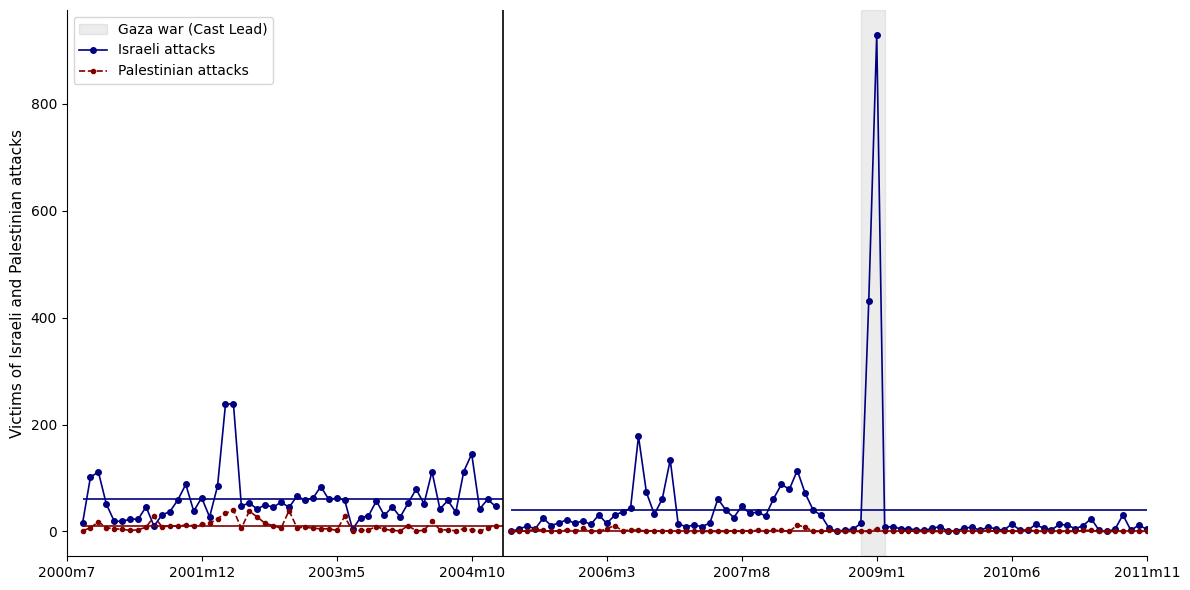

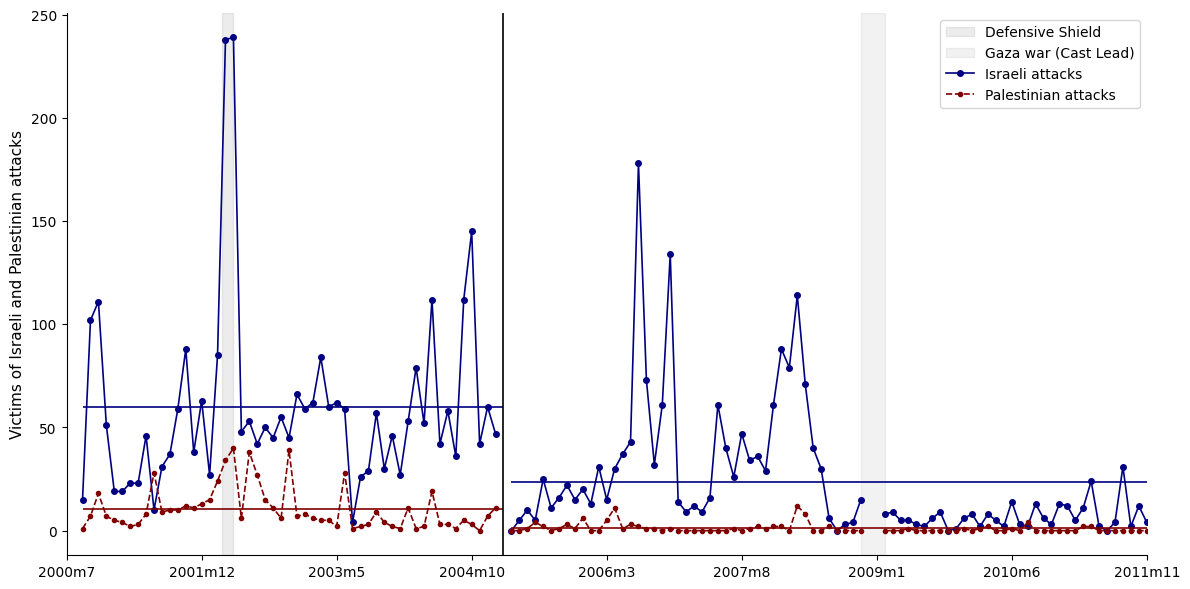

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df = pd.read_stata(str(DTA / "replication_file1.dta"))

# --- Stata %tm formatter: monthyear is months since 1960m1, where 0 = 1960m1 ---
def fmt_stata_tm(x, pos=None):
    if np.isnan(x):
        return ""
    m = int(round(x))
    year = 1960 + (m // 12)
    month = (m % 12) + 1   # IMPORTANT: +1 because 0 -> January
    return f"{year}m{month}"

tm_formatter = FuncFormatter(fmt_stata_tm)

# Exact Stata x-axis ticks: xlabel(486(17)622, format("%tm"))
x_min, x_max = 486, 622
x_ticks = np.arange(x_min, x_max + 1, 17)

def agg_monthly(df_in):
    out = df_in.groupby("monthyear", as_index=False).agg(
        victims_isr=("victims_isr", "sum"),
        victims_pal=("victims_pal", "sum"),
        post_intifada=("post_intifada", "first"),
    )
    # Stata: replace sum_vic=. if monthyear==541 (and same for pal)
    out.loc[out["monthyear"] == 541, ["victims_isr", "victims_pal"]] = np.nan
    return out

# =========================
# Panel A
# =========================
df_agg_a = agg_monthly(df)

mean_isr_intifada = df_agg_a.loc[df_agg_a["post_intifada"] == 0, "victims_isr"].mean()
mean_isr_post     = df_agg_a.loc[df_agg_a["post_intifada"] == 1, "victims_isr"].mean()
mean_pal_intifada = df_agg_a.loc[df_agg_a["post_intifada"] == 0, "victims_pal"].mean()
mean_pal_post     = df_agg_a.loc[df_agg_a["post_intifada"] == 1, "victims_pal"].mean()

fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# Gaza war shading: Stata uses 586 to 589
ax.axvspan(586, 589, color="gray", alpha=0.15, label="Gaza war (Cast Lead)")

ax.plot(df_agg_a["monthyear"], df_agg_a["victims_isr"],
        color="navy", marker="o", markersize=4, linewidth=1.2, label="Israeli attacks")
ax.plot(df_agg_a["monthyear"], df_agg_a["victims_pal"],
        color="maroon", marker="o", markersize=3, linestyle="--", linewidth=1.2, label="Palestinian attacks")

# Mean lines by period (same idea as Stata egen mean(...) if post_intifada==...)
mask0 = df_agg_a["post_intifada"] == 0
mask1 = df_agg_a["post_intifada"] == 1
ax.hlines(mean_isr_intifada, df_agg_a.loc[mask0, "monthyear"].min(), df_agg_a.loc[mask0, "monthyear"].max(),
          colors="navy", linewidth=1.2)
ax.hlines(mean_isr_post,     df_agg_a.loc[mask1, "monthyear"].min(), df_agg_a.loc[mask1, "monthyear"].max(),
          colors="navy", linewidth=1.2)
ax.hlines(mean_pal_intifada, df_agg_a.loc[mask0, "monthyear"].min(), df_agg_a.loc[mask0, "monthyear"].max(),
          colors="maroon", linewidth=1.2)
ax.hlines(mean_pal_post,     df_agg_a.loc[mask1, "monthyear"].min(), df_agg_a.loc[mask1, "monthyear"].max(),
          colors="maroon", linewidth=1.2)

ax.axvline(541, color="black", linewidth=1.2)

ax.set_ylabel("Victims of Israeli and Palestinian attacks", fontsize=11)
ax.set_xlabel("")
ax.set_xlim(x_min, x_max)
ax.set_xticks(x_ticks)
ax.xaxis.set_major_formatter(tm_formatter)

ax.legend(loc="upper left", fontsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.savefig(FIGURES / "figure_1_a.pdf", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

# =========================
# Panel B (exclude Gaza war months 587-588 like Stata)
# =========================
df_agg_b = agg_monthly(df)
df_agg_b.loc[df_agg_b["monthyear"].isin([587, 588]), ["victims_isr", "victims_pal"]] = np.nan

mean_isr_intifada_b = df_agg_b.loc[df_agg_b["post_intifada"] == 0, "victims_isr"].mean()
mean_isr_post_b     = df_agg_b.loc[df_agg_b["post_intifada"] == 1, "victims_isr"].mean()
mean_pal_intifada_b = df_agg_b.loc[df_agg_b["post_intifada"] == 0, "victims_pal"].mean()
mean_pal_post_b     = df_agg_b.loc[df_agg_b["post_intifada"] == 1, "victims_pal"].mean()

fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# Shading like Stata panel B
ax.axvspan(505.5, 507, color="gray", alpha=0.15, label="Defensive Shield")
ax.axvspan(586, 589,  color="gray", alpha=0.10, label="Gaza war (Cast Lead)")

ax.plot(df_agg_b["monthyear"], df_agg_b["victims_isr"],
        color="navy", marker="o", markersize=4, linewidth=1.2, label="Israeli attacks")
ax.plot(df_agg_b["monthyear"], df_agg_b["victims_pal"],
        color="maroon", marker="o", markersize=3, linestyle="--", linewidth=1.2, label="Palestinian attacks")

mask0 = df_agg_b["post_intifada"] == 0
mask1 = df_agg_b["post_intifada"] == 1
ax.hlines(mean_isr_intifada_b, df_agg_b.loc[mask0, "monthyear"].min(), df_agg_b.loc[mask0, "monthyear"].max(),
          colors="navy", linewidth=1.2)
ax.hlines(mean_isr_post_b,     df_agg_b.loc[mask1, "monthyear"].min(), df_agg_b.loc[mask1, "monthyear"].max(),
          colors="navy", linewidth=1.2)
ax.hlines(mean_pal_intifada_b, df_agg_b.loc[mask0, "monthyear"].min(), df_agg_b.loc[mask0, "monthyear"].max(),
          colors="maroon", linewidth=1.2)
ax.hlines(mean_pal_post_b,     df_agg_b.loc[mask1, "monthyear"].min(), df_agg_b.loc[mask1, "monthyear"].max(),
          colors="maroon", linewidth=1.2)

ax.axvline(541, color="black", linewidth=1.2)

ax.set_ylabel("Victims of Israeli and Palestinian attacks", fontsize=11)
ax.set_xlabel("")
ax.set_xlim(x_min, x_max)
ax.set_xticks(x_ticks)
ax.xaxis.set_major_formatter(tm_formatter)

ax.legend(loc="upper right", fontsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.savefig(FIGURES / "figure_1_b.pdf", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)


$$ \textbf{Extension Figure 1. Israeli and Palestinian Fatalities by Month}$$

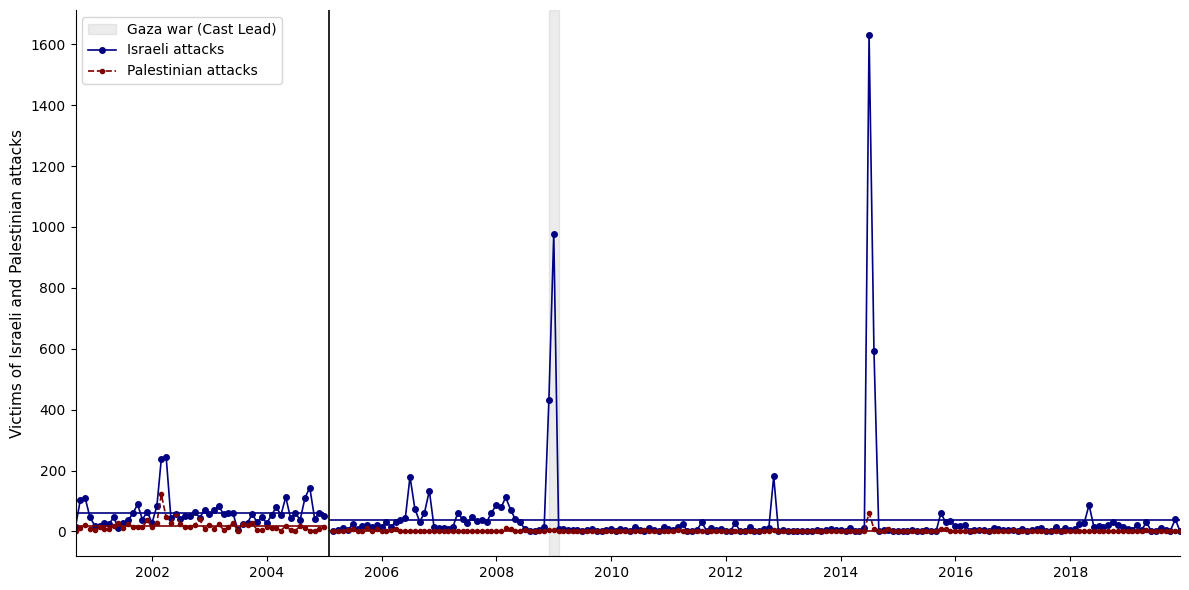

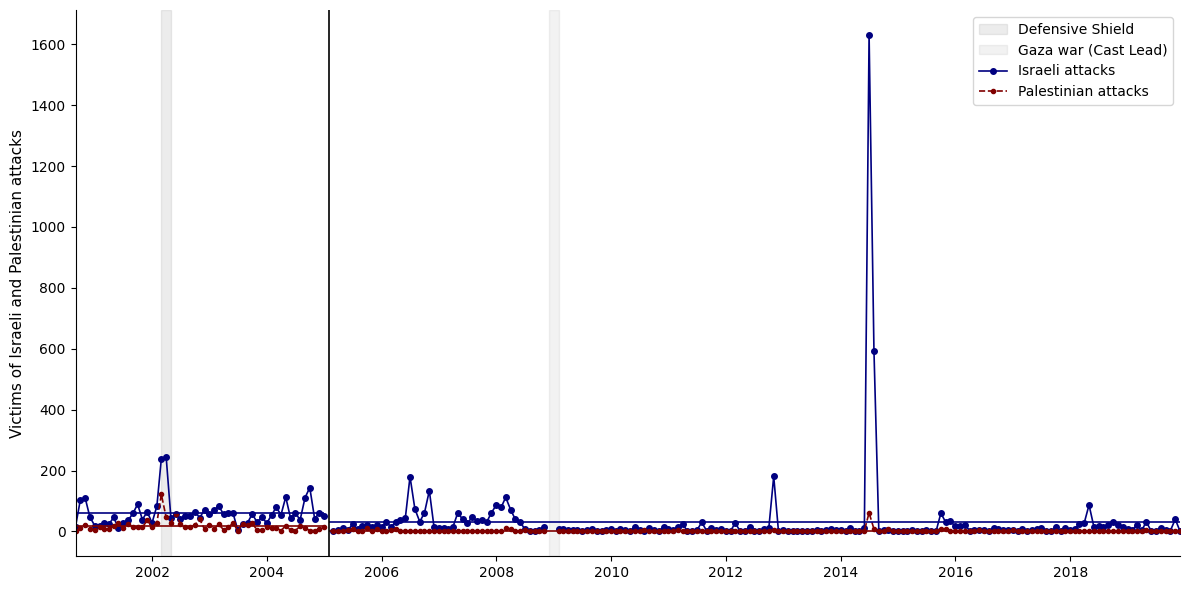

Saved:
extension_code_python/figures/figure_1_a_extension_2000_2019.pdf
extension_code_python/figures/figure_1_b_extension_2000_2019.pdf


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# ======================================================
# Paths
# ======================================================
CSV = "extension_code_python/data_clean/full_dataset_extension_2000_2019_with_lags_daily.csv"
FIGDIR = Path("extension_code_python/figures")
FIGDIR.mkdir(parents=True, exist_ok=True)

# ======================================================
# Load (EXTENSION DATA)
# ======================================================
df = pd.read_csv(CSV)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
if df["date"].isna().any():
    raise ValueError("Some dates could not be parsed in the extension CSV.")
df = df.sort_values("date").reset_index(drop=True)

# ======================================================
# Aggregate monthly (like Figure 1 but 2000–2019)
# ======================================================
# Month start timestamp for plotting
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

req = ["victims_isr", "victims_pal", "month"]
missing = [c for c in req if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in extension CSV: {missing}")

dfm = (
    df.groupby("month", as_index=False)
      .agg(victims_isr=("victims_isr", "sum"),
           victims_pal=("victims_pal", "sum"))
)

# Match Stata's vertical break at monthyear==541, i.e. 2005-02-01
break_month = pd.Timestamp("2005-02-01")
dfm["post_intifada"] = (dfm["month"] >= break_month).astype(int)

# Stata behavior: set missing at the break month
dfm.loc[dfm["month"] == break_month, ["victims_isr", "victims_pal"]] = np.nan

# Means pre/post (ignore nan)
mean_isr_pre  = dfm.loc[dfm["post_intifada"] == 0, "victims_isr"].mean()
mean_isr_post = dfm.loc[dfm["post_intifada"] == 1, "victims_isr"].mean()
mean_pal_pre  = dfm.loc[dfm["post_intifada"] == 0, "victims_pal"].mean()
mean_pal_post = dfm.loc[dfm["post_intifada"] == 1, "victims_pal"].mean()

# Helpers for mean-line spans
pre_min = dfm.loc[dfm["post_intifada"] == 0, "month"].min()
pre_max = dfm.loc[dfm["post_intifada"] == 0, "month"].max()
post_min = dfm.loc[dfm["post_intifada"] == 1, "month"].min()
post_max = dfm.loc[dfm["post_intifada"] == 1, "month"].max()

# Shading windows (monthly view)
cast_lead_start = pd.Timestamp("2008-12-01")
cast_lead_end   = pd.Timestamp("2009-02-01")  # spans Dec 2008 + Jan 2009 months

defensive_shield_start = pd.Timestamp("2002-03-01")
defensive_shield_end   = pd.Timestamp("2002-05-01")  # spans Mar–Apr 2002 months

# ======================================================
# Panel A (full sample 2000–2019, with Gaza war shading)
# ======================================================
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.axvspan(cast_lead_start, cast_lead_end, color="gray", alpha=0.15, label="Gaza war (Cast Lead)")

ax.plot(dfm["month"], dfm["victims_isr"],
        color="navy", marker="o", markersize=4, linewidth=1.2, label="Israeli attacks")
ax.plot(dfm["month"], dfm["victims_pal"],
        color="maroon", marker="o", markersize=3, linestyle="--", linewidth=1.2, label="Palestinian attacks")

# Mean lines pre/post break (same idea as Stata)
ax.hlines(mean_isr_pre,  pre_min,  pre_max,  colors="navy",   linewidth=1.2)
ax.hlines(mean_isr_post, post_min, post_max, colors="navy",   linewidth=1.2)
ax.hlines(mean_pal_pre,  pre_min,  pre_max,  colors="maroon", linewidth=1.2)
ax.hlines(mean_pal_post, post_min, post_max, colors="maroon", linewidth=1.2)

ax.axvline(break_month, color="black", linewidth=1.2)

ax.set_ylabel("Victims of Israeli and Palestinian attacks", fontsize=11)
ax.set_xlabel("")

# X axis: show every 2 years (Jan), readable for 2000–2019
ax.xaxis.set_major_locator(mdates.YearLocator(base=2, month=1, day=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.set_xlim(dfm["month"].min(), dfm["month"].max())

ax.legend(loc="upper left", fontsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.savefig(FIGDIR / "figure_1_a_extension_2000_2019.pdf", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

# ======================================================
# Panel B (exclude Gaza war months like Stata; add Defensive Shield shading)
# ======================================================
dfm_b = dfm.copy()
dfm_b.loc[dfm_b["month"].isin([pd.Timestamp("2008-12-01"), pd.Timestamp("2009-01-01")]),
          ["victims_isr", "victims_pal"]] = np.nan

mean_isr_pre_b  = dfm_b.loc[dfm_b["post_intifada"] == 0, "victims_isr"].mean()
mean_isr_post_b = dfm_b.loc[dfm_b["post_intifada"] == 1, "victims_isr"].mean()
mean_pal_pre_b  = dfm_b.loc[dfm_b["post_intifada"] == 0, "victims_pal"].mean()
mean_pal_post_b = dfm_b.loc[dfm_b["post_intifada"] == 1, "victims_pal"].mean()

fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.axvspan(defensive_shield_start, defensive_shield_end, color="gray", alpha=0.15, label="Defensive Shield")
ax.axvspan(cast_lead_start, cast_lead_end,  color="gray", alpha=0.10, label="Gaza war (Cast Lead)")

ax.plot(dfm_b["month"], dfm_b["victims_isr"],
        color="navy", marker="o", markersize=4, linewidth=1.2, label="Israeli attacks")
ax.plot(dfm_b["month"], dfm_b["victims_pal"],
        color="maroon", marker="o", markersize=3, linestyle="--", linewidth=1.2, label="Palestinian attacks")

ax.hlines(mean_isr_pre_b,  pre_min,  pre_max,  colors="navy",   linewidth=1.2)
ax.hlines(mean_isr_post_b, post_min, post_max, colors="navy",   linewidth=1.2)
ax.hlines(mean_pal_pre_b,  pre_min,  pre_max,  colors="maroon", linewidth=1.2)
ax.hlines(mean_pal_post_b, post_min, post_max, colors="maroon", linewidth=1.2)

ax.axvline(break_month, color="black", linewidth=1.2)

ax.set_ylabel("Victims of Israeli and Palestinian attacks", fontsize=11)
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(base=2, month=1, day=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.set_xlim(dfm_b["month"].min(), dfm_b["month"].max())

ax.legend(loc="upper right", fontsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.savefig(FIGDIR / "figure_1_b_extension_2000_2019.pdf", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

print("Saved:")
print(FIGDIR / "figure_1_a_extension_2000_2019.pdf")
print(FIGDIR / "figure_1_b_extension_2000_2019.pdf")


$$ \textbf{Figure 2. Coverage of Conflict in US News}$$

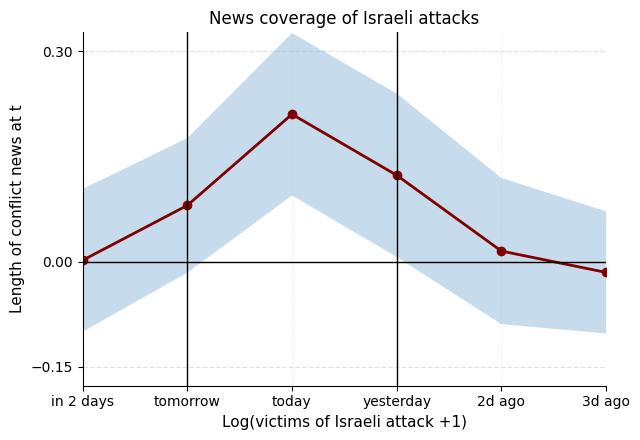

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_2_a_isr.pdf


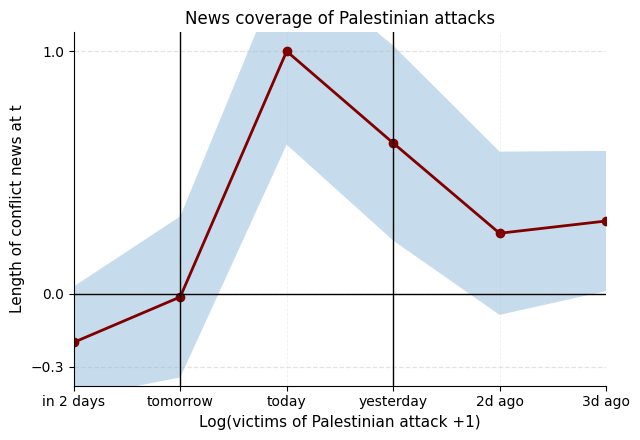

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_2_a_pal.pdf


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ValueError: Length of values (32) does not match length of index (33)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.discrete.discrete_model import NegativeBinomial
from statsmodels.stats.sandwich_covariance import cov_cluster

# ============================================================
# Figure 2. Coverage of Conflict in US News
# Outputs:
#   FIGURES/figure_2_a_isr.pdf
#   FIGURES/figure_2_a_pal.pdf
#   FIGURES/figure_2_b.pdf
# ============================================================

df = pd.read_stata(str(DTA / "replication_file1.dta")).copy()

# Stata: sort date
if "date" in df.columns:
    df = df.sort_values("date").reset_index(drop=True)

# --------------------
# Helpers
# --------------------
def add_leads_lags(d, var, prefix):
    d[f"{prefix}0"] = d[var].shift(-3)
    d[f"{prefix}1"] = d[var].shift(-2)
    d[f"{prefix}2"] = d[var].shift(-1)
    d[f"{prefix}3"] = d[var]
    d[f"{prefix}4"] = d[var].shift(1)
    d[f"{prefix}5"] = d[var].shift(2)
    d[f"{prefix}6"] = d[var].shift(3)
    d[f"{prefix}7"] = d[var].shift(4)
    d[f"{prefix}8"] = d[var].shift(5)
    d[f"{prefix}9"] = d[var].shift(6)
    return d

labels_ti = {
    1: "in 2 days",
    2: "tomorrow",
    3: "today",
    4: "yesterday",
    5: "2d ago",
    6: "3d ago",
}

def apply_grid(ax):
    # More visible, solid (not dotted)
    ax.grid(True, axis="y", linestyle="--", linewidth=0.9, alpha=0.35)
    ax.grid(True, axis="x", linestyle="--", linewidth=0.6, alpha=0.18)

def build_eventstudy_df(params, se, mapping):
    rows = []
    for t, name in mapping.items():
        b = float(params[name])
        s = float(se[name])
        rows.append({"time": t, "coef": b, "low": b - 1.96*s, "high": b + 1.96*s})
    return pd.DataFrame(rows).sort_values("time")

def plot_es(es, xtitle, title, y_min, y_max, y_ticks, out_pdf):
    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    ax.fill_between(es["time"], es["low"], es["high"], alpha=0.25)
    ax.plot(es["time"], es["coef"], color="maroon", marker="o", markersize=6, linewidth=2.0)

    ax.axhline(0, color="black", linewidth=1.0)
    ax.axvline(2, color="black", linewidth=1.0)
    ax.axvline(4, color="black", linewidth=1.0)

    ax.set_xlim(1, 6)
    ax.set_xticks([1,2,3,4,5,6])
    ax.set_xticklabels([labels_ti[i] for i in [1,2,3,4,5,6]], fontsize=10)

    pad = 0.06 * (y_max - y_min)  # slightly bigger pad than before
    ax.set_ylim(y_min - pad, y_max + pad)
    ax.set_yticks(y_ticks)

    ax.set_ylabel("Length of conflict news at t", fontsize=11)
    ax.set_xlabel(xtitle, fontsize=11)
    ax.set_title(title, fontsize=12)

    apply_grid(ax)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    fig.savefig(out_pdf, bbox_inches="tight", facecolor="white")
    plt.show()
    plt.close(fig)
    print("Saved:", out_pdf)

# ============================================================
# Panel A: Newey-West (lag=7)
# ============================================================
df = add_leads_lags(df, "lnvic", "B")
df = add_leads_lags(df, "lnvic_pal", "C")

sample_a = df[df["high_intensity"] < 2].copy()

rhs = " + ".join([f"B{k}" for k in range(1, 9)] + [f"C{k}" for k in range(1, 9)])
fe = "C(month) + C(dow) + C(year)"
formula_a = f"length_conflict_news ~ {rhs} + {fe}"

ols = smf.ols(formula_a, data=sample_a).fit()
V_hac = cov_hac(ols, nlags=7)
se_hac = pd.Series(np.sqrt(np.diag(V_hac)), index=ols.params.index)

time_to_B = {1:"B1", 2:"B2", 3:"B3", 4:"B4", 5:"B5", 6:"B6"}
time_to_C = {1:"C1", 2:"C2", 3:"C3", 4:"C4", 5:"C5", 6:"C6"}

es_isr = build_eventstudy_df(ols.params, se_hac, time_to_B)
es_pal = build_eventstudy_df(ols.params, se_hac, time_to_C)

plot_es(
    es_isr,
    xtitle="Log(victims of Israeli attack +1)",
    title="News coverage of Israeli attacks",
    y_min=-0.15, y_max=0.30, y_ticks=[-0.15, 0, 0.30],
    out_pdf=FIGURES / "figure_2_a_isr.pdf"
)

plot_es(
    es_pal,
    xtitle="Log(victims of Palestinian attack +1)",
    title="News coverage of Palestinian attacks",
    y_min=-0.30, y_max=1.00, y_ticks=[-0.30, 0, 1.00],
    out_pdf=FIGURES / "figure_2_a_pal.pdf"
)

# ============================================================
# Panel B: NBREG + cluster(monthyear) + margins at percentiles (atmeans)
# ============================================================

sample_b = df[(df["occurrence_t_y"] == 1) | (df["occurrence_pal_t_y"] == 1)].copy()

X = sample_b[["lnvic_t_y", "lnvic_pal_y", "daily_woi"]].copy()
X = pd.concat(
    [
        X,
        pd.get_dummies(sample_b["month"], prefix="month", drop_first=True),
        pd.get_dummies(sample_b["year"],  prefix="year",  drop_first=True),
        pd.get_dummies(sample_b["dow"],   prefix="dow",   drop_first=True),
    ],
    axis=1,
)
X = sm.add_constant(X, has_constant="add")

y = pd.to_numeric(sample_b["length_conflict_news"], errors="coerce")


# Force numeric
X = X.apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(y, errors="coerce")

# Robust finite mask (forces float array, safe for isfinite)
X_np = X.to_numpy(dtype=float, na_value=np.nan)
y_np = y.to_numpy(dtype=float, na_value=np.nan)

mask_ok = np.isfinite(y_np) & np.all(np.isfinite(X_np), axis=1)

X = X.loc[mask_ok].astype(float).copy()
y = y.loc[mask_ok].astype(float).copy()
cluster_ids = sample_b.loc[mask_ok, "monthyear"].copy()


# Fit NB2 (may warn about convergence; still produces params, but see note below)
nb = NegativeBinomial(y, X)
res_nb = nb.fit(disp=False)

# Cluster covariance
V_cl = cov_cluster(res_nb, cluster_ids)

# --- Robust dimension-safe setup: align by column names ---
beta = res_nb.params.copy()  # pandas Series indexed by X columns in the fitted model
X_fit = res_nb.model.exog
cols_fit = res_nb.model.exog_names

# Build xbar as Series on the exact fitted columns (guarantees matching length)
xbar = pd.Series(X_fit.mean(axis=0), index=cols_fit)

# Percentiles of daily_woi from the sample (like Stata)
pct_list = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]
pvals = np.percentile(sample_b["daily_woi"].dropna(), pct_list)

rows = []
for pct, pval in zip(pct_list, pvals):
    x = xbar.copy()
    x["daily_woi"] = float(pval)

    # xb = x' beta, with guaranteed alignment
    xb = float(np.dot(x.values, beta.loc[cols_fit].values))
    mu = float(np.exp(xb))

    # delta method on xb then exp
    x_vec = x.values
    var_xb = float(x_vec @ V_cl @ x_vec)
    se_xb = np.sqrt(var_xb)

    ci_lower = float(np.exp(xb - 1.96 * se_xb))
    ci_upper = float(np.exp(xb + 1.96 * se_xb))

    rows.append({"pct": pct, "coef": mu, "ci_lower": ci_lower, "ci_upper": ci_upper})

marg = pd.DataFrame(rows).sort_values("pct")

# Plot Panel B
fig, ax = plt.subplots(figsize=(7.8, 4.6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.vlines(marg["pct"], marg["ci_lower"], marg["ci_upper"], linewidth=1.6)
ax.scatter(marg["pct"], marg["coef"], s=34)

ax.set_title("Predicted length of conflict news if an attack occurred today or yesterday", fontsize=12)
ax.set_xlabel("News pressure (percentile)", fontsize=11)
ax.set_ylabel("Predicted length of conflict news", fontsize=11)

ax.set_xticks(pct_list)
ax.set_xlim(min(pct_list) - 2, max(pct_list) + 2)

apply_grid(ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
out_b = FIGURES / "figure_2_b.pdf"
fig.savefig(out_b, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)
print("Saved:", out_b)


$$ \textbf{Figure 3. Israeli and Palestinian attacks and US news pressure} $$

$$ \textbf{Figure 3A: Probability of Israeli attacks vs news pressure}$$

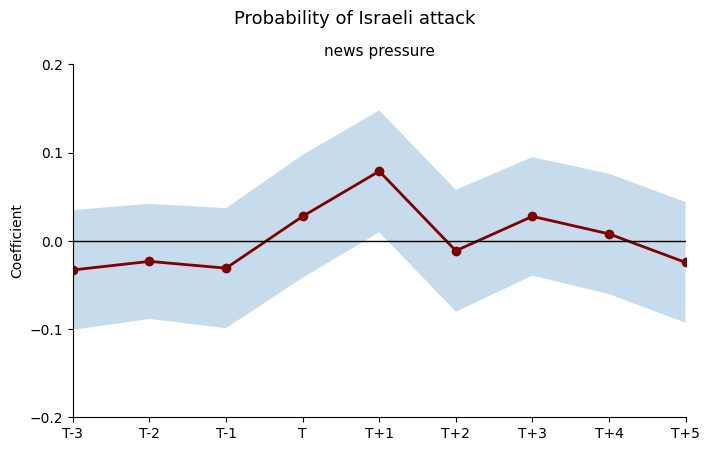

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_3_a.pdf


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.sandwich_covariance import cov_hac

# ============================================================
# Figure 3 — Panel A (Probability of Israeli attacks vs news pressure)
# Stata reference:
#   newey occurrence D1-D15 occurrence_pal_1 occurrence_pal_2_7 occurrence_pal_8_14
#        i.month i.year i.dow if gaza_war==0, lag(7)
#   then keep D5..D13 (T-3 .. T+5) with 95% CI band
# Output:
#   FIGURES/figure_3_a.pdf
# ============================================================

# --- load data ---
df = pd.read_stata(str(DTA / "replication_file1.dta")).copy()

# sort date (Stata: sort date)
if "date" in df.columns:
    df = df.sort_values("date").reset_index(drop=True)

# ------------------------------------------------------------
# Build D1..D15 from lag/lead daily_woi variables (as in Stata)
# ------------------------------------------------------------
# In Stata they create lagdaily_woi1 = lagdaily_woi and leaddaily_woi1 = leaddaily_woi
# Then:
#   D1..D7  = lagdaily_woi7..lagdaily_woi1   (furthest lag -> closest lag)
#   D8      = daily_woi
#   D9..D15 = leaddaily_woi1..leaddaily_woi7 (closest lead -> furthest lead)

# Make sure the required columns exist
needed_lags = [f"lagdaily_woi{k}" for k in range(2, 8)] + ["lagdaily_woi"]
needed_leads = ["leaddaily_woi"] + [f"leaddaily_woi{k}" for k in range(2, 8)]
needed = ["daily_woi", "occurrence", "occurrence_pal_1", "occurrence_pal_2_7", "occurrence_pal_8_14",
          "month", "year", "dow", "gaza_war"] + needed_lags + needed_leads
missing = [c for c in needed if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns needed for Figure 3A: {missing}")

# Create explicit lag1/lead1 like Stata (optional but keeps mapping transparent)
df["lagdaily_woi1"] = df["lagdaily_woi"]         # lag 1 day
df["leaddaily_woi1"] = df["leaddaily_woi"]       # lead 1 day

# D1..D7 from lagdaily_woi7..lagdaily_woi1
# Note: lagdaily_woi without suffix is "1"
lag_map = {
    1: "lagdaily_woi7",
    2: "lagdaily_woi6",
    3: "lagdaily_woi5",
    4: "lagdaily_woi4",
    5: "lagdaily_woi3",
    6: "lagdaily_woi2",
    7: "lagdaily_woi1",
}
for k in range(1, 8):
    df[f"D{k}"] = df[lag_map[k]]

# D8 is today
df["D8"] = df["daily_woi"]

# D9..D15 from leaddaily_woi1..leaddaily_woi7
lead_map = {
    9:  "leaddaily_woi1",
    10: "leaddaily_woi2",
    11: "leaddaily_woi3",
    12: "leaddaily_woi4",
    13: "leaddaily_woi5",
    14: "leaddaily_woi6",
    15: "leaddaily_woi7",
}
for d, name in lead_map.items():
    df[f"D{d}"] = df[name]

# ------------------------------------------------------------
# Run Newey-West HAC regression (lag 7) on gaza_war==0 sample
# ------------------------------------------------------------
sample = df[df["gaza_war"] == 0].copy()

D_terms = " + ".join([f"D{k}" for k in range(1, 16)])
fe_terms = "C(month) + C(year) + C(dow)"
controls = "occurrence_pal_1 + occurrence_pal_2_7 + occurrence_pal_8_14"
formula = f"occurrence ~ {D_terms} + {controls} + {fe_terms}"

ols = smf.ols(formula, data=sample).fit()

# Newey-West (Stata: newey ..., lag(7))
V_hac = cov_hac(ols, nlags=7)
se_hac = pd.Series(np.sqrt(np.diag(V_hac)), index=ols.params.index)

# ------------------------------------------------------------
# Extract coefficients for D5..D13 (T-3 .. T+5) and build 95% CI
# ------------------------------------------------------------
# Stata keeps k=5..13 and labels:
# 5 T-3, 6 T-2, 7 T-1, 8 T, 9 T+1, 10 T+2, 11 T+3, 12 T+4, 13 T+5
tick_labels = {
    5:  "T-3",
    6:  "T-2",
    7:  "T-1",
    8:  "T",
    9:  "T+1",
    10: "T+2",
    11: "T+3",
    12: "T+4",
    13: "T+5",
}

rows = []
for k in range(5, 14):
    name = f"D{k}"
    b = float(ols.params[name])
    s = float(se_hac[name])
    rows.append({"t": k, "coef": b, "low": b - 1.96 * s, "high": b + 1.96 * s})

es = pd.DataFrame(rows).sort_values("t")

# ------------------------------------------------------------
# Plot (Stata-like): rarea + connected scatter + y=0 line
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7.2, 4.6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# CI band (Stata gs14)
ax.fill_between(es["t"], es["low"], es["high"], alpha=0.25)

# connected scatter (maroon, medthick)
ax.plot(es["t"], es["coef"], color="maroon", marker="o", markersize=6, linewidth=2.0)

# y=0 reference
ax.axhline(0, color="black", linewidth=1.0)

# axis formatting to match Stata
ax.set_xlim(5, 13)
ax.set_xticks(list(tick_labels.keys()))
ax.set_xticklabels([tick_labels[t] for t in tick_labels.keys()])
ax.set_ylim(-0.2, 0.2)
ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])

ax.set_ylabel("Coefficient")
ax.set_xlabel("")

fig.suptitle(
    "Probability of Israeli attack",
    fontsize=13,
    y=0.97
)

ax.set_title(
    "news pressure",
    fontsize=11,
    pad=6
)


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

plt.tight_layout()
out_path = FIGURES / "figure_3_a.pdf"
fig.savefig(out_path, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

print("Saved:", out_path)


$$ \textbf{ Figure 3B: Probability of Palestinian attack — news pressure (daily_woi)}$$

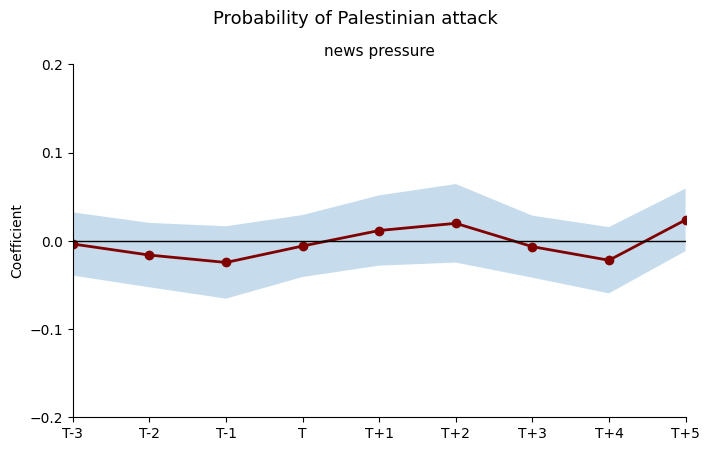

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_3_b.pdf


In [ ]:
# =========================
# Figure 3B
# Probability of Palestinian attack — news pressure (daily_woi)
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.sandwich_covariance import cov_hac

# --- sample restriction (Stata: if gaza_war==0) ---
sample = df[df["gaza_war"] == 0].copy()

# Stata: newey occurrence_pal D1-D15 occurrence_1 occurrence_2_7 occurrence_8_14 i.month i.year i.dow, lag(7)
D_terms = " + ".join([f"D{k}" for k in range(1, 16)])
fe_terms = "C(month) + C(year) + C(dow)"
controls = "occurrence_1 + occurrence_2_7 + occurrence_8_14"
formula = f"occurrence_pal ~ {D_terms} + {controls} + {fe_terms}"

ols = smf.ols(formula, data=sample).fit()
V_hac = cov_hac(ols, nlags=7)
se_hac = pd.Series(np.sqrt(np.diag(V_hac)), index=ols.params.index)

# Keep D5..D13 (T-3 .. T+5)
tick_labels = {5:"T-3", 6:"T-2", 7:"T-1", 8:"T", 9:"T+1", 10:"T+2", 11:"T+3", 12:"T+4", 13:"T+5"}

rows = []
for k in range(5, 14):
    name = f"D{k}"
    b = float(ols.params[name])
    s = float(se_hac[name])
    rows.append({"t": k, "coef": b, "low": b - 1.96*s, "high": b + 1.96*s})

es = pd.DataFrame(rows).sort_values("t")

# Plot
fig, ax = plt.subplots(figsize=(7.2, 4.6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.fill_between(es["t"], es["low"], es["high"], alpha=0.25)
ax.plot(es["t"], es["coef"], color="maroon", marker="o", markersize=6, linewidth=2.0)
ax.axhline(0, color="black", linewidth=1.0)

ax.set_xlim(5, 13)
ax.set_xticks(list(tick_labels.keys()))
ax.set_xticklabels([tick_labels[t] for t in tick_labels.keys()])
ax.set_ylim(-0.2, 0.2)
ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])

ax.set_ylabel("Coefficient")
ax.set_xlabel("")
fig.suptitle(
    "Probability of Palestinian attack",
    fontsize=13,
    y=0.97
)

ax.set_title(
    "news pressure",
    fontsize=11,
    pad=6
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

plt.tight_layout()
out_path = FIGURES / "figure_3_b.pdf"
fig.savefig(out_path, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

print("Saved:", out_path)


$$ \textbf{Figure 3C: Probability of Israeli attack — UNCORRECTED news pressure (daily_woi_nc)}$$

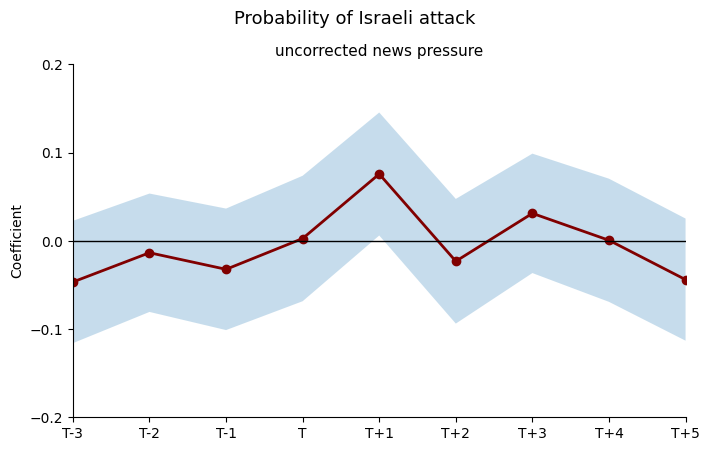

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_3_c.pdf


In [ ]:
# =========================
# Figure 3C
# Probability of Israeli attack — UNCORRECTED news pressure (daily_woi_nc)
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.sandwich_covariance import cov_hac

# --- Build D1..D15 using *_nc (like Stata panel C) ---
# D1..D7  = lagdaily_woi7_nc .. lagdaily_woi1_nc
# D8      = daily_woi_nc
# D9..D15 = leaddaily_woi1_nc .. leaddaily_woi7_nc

df_nc = df.copy()

# Stata aliases
df_nc["lagdaily_woi1_nc"] = df_nc["lagdaily_woi_nc"]
df_nc["leaddaily_woi1_nc"] = df_nc["leaddaily_woi_nc"]

lag_map_nc = {
    1: "lagdaily_woi7_nc",
    2: "lagdaily_woi6_nc",
    3: "lagdaily_woi5_nc",
    4: "lagdaily_woi4_nc",
    5: "lagdaily_woi3_nc",
    6: "lagdaily_woi2_nc",
    7: "lagdaily_woi1_nc",
}
for k in range(1, 8):
    df_nc[f"D{k}"] = df_nc[lag_map_nc[k]]

df_nc["D8"] = df_nc["daily_woi_nc"]

lead_map_nc = {
    9:  "leaddaily_woi1_nc",
    10: "leaddaily_woi2_nc",
    11: "leaddaily_woi3_nc",
    12: "leaddaily_woi4_nc",
    13: "leaddaily_woi5_nc",
    14: "leaddaily_woi6_nc",
    15: "leaddaily_woi7_nc",
}
for dcol, name in lead_map_nc.items():
    df_nc[f"D{dcol}"] = df_nc[name]

# --- sample restriction (Stata: if gaza_war==0) ---
sample = df_nc[df_nc["gaza_war"] == 0].copy()

# Stata: newey occurrence D1-D15 occurrence_pal_1 occurrence_pal_2_7 occurrence_pal_8_14 i.month i.year i.dow, lag(7)
D_terms = " + ".join([f"D{k}" for k in range(1, 16)])
fe_terms = "C(month) + C(year) + C(dow)"
controls = "occurrence_pal_1 + occurrence_pal_2_7 + occurrence_pal_8_14"
formula = f"occurrence ~ {D_terms} + {controls} + {fe_terms}"

ols = smf.ols(formula, data=sample).fit()
V_hac = cov_hac(ols, nlags=7)
se_hac = pd.Series(np.sqrt(np.diag(V_hac)), index=ols.params.index)

tick_labels = {5:"T-3", 6:"T-2", 7:"T-1", 8:"T", 9:"T+1", 10:"T+2", 11:"T+3", 12:"T+4", 13:"T+5"}

rows = []
for k in range(5, 14):
    name = f"D{k}"
    b = float(ols.params[name])
    s = float(se_hac[name])
    rows.append({"t": k, "coef": b, "low": b - 1.96*s, "high": b + 1.96*s})

es = pd.DataFrame(rows).sort_values("t")

fig, ax = plt.subplots(figsize=(7.2, 4.6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.fill_between(es["t"], es["low"], es["high"], alpha=0.25)
ax.plot(es["t"], es["coef"], color="maroon", marker="o", markersize=6, linewidth=2.0)
ax.axhline(0, color="black", linewidth=1.0)

ax.set_xlim(5, 13)
ax.set_xticks(list(tick_labels.keys()))
ax.set_xticklabels([tick_labels[t] for t in tick_labels.keys()])
ax.set_ylim(-0.2, 0.2)
ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])

ax.set_ylabel("Coefficient")
ax.set_xlabel("")

fig.suptitle("Probability of Israeli attack", fontsize=13, y=0.97)
ax.set_title("uncorrected news pressure", fontsize=11, pad=6)



ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

plt.tight_layout()
out_path = FIGURES / "figure_3_c.pdf"
fig.savefig(out_path, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

print("Saved:", out_path)


$$ \textbf{Figure 3D: Probability of Palestinian attack — UNCORRECTED news pressure (daily_woi_nc)}$$

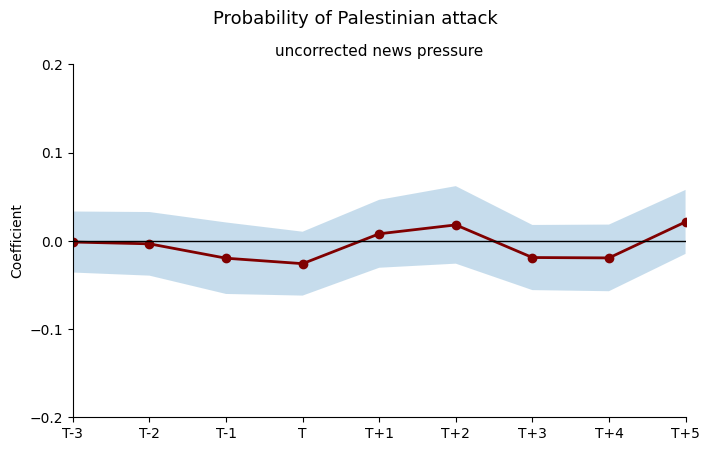

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_3_d.pdf


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.sandwich_covariance import cov_hac

# Reuse df_nc from 3C if it exists; otherwise rebuild it quickly
try:
    df_nc
except NameError:
    df_nc = df.copy()
    df_nc["lagdaily_woi1_nc"] = df_nc["lagdaily_woi_nc"]
    df_nc["leaddaily_woi1_nc"] = df_nc["leaddaily_woi_nc"]

    lag_map_nc = {
        1: "lagdaily_woi7_nc",
        2: "lagdaily_woi6_nc",
        3: "lagdaily_woi5_nc",
        4: "lagdaily_woi4_nc",
        5: "lagdaily_woi3_nc",
        6: "lagdaily_woi2_nc",
        7: "lagdaily_woi1_nc",
    }
    for k in range(1, 8):
        df_nc[f"D{k}"] = df_nc[lag_map_nc[k]]

    df_nc["D8"] = df_nc["daily_woi_nc"]

    lead_map_nc = {
        9:  "leaddaily_woi1_nc",
        10: "leaddaily_woi2_nc",
        11: "leaddaily_woi3_nc",
        12: "leaddaily_woi4_nc",
        13: "leaddaily_woi5_nc",
        14: "leaddaily_woi6_nc",
        15: "leaddaily_woi7_nc",
    }
    for dcol, name in lead_map_nc.items():
        df_nc[f"D{dcol}"] = df_nc[name]

# --- sample restriction (Stata: if gaza_war==0) ---
sample = df_nc[df_nc["gaza_war"] == 0].copy()

# Stata: newey occurrence_pal D1-D15 occurrence_1 occurrence_2_7 occurrence_8_14 i.month i.year i.dow, lag(7)
D_terms = " + ".join([f"D{k}" for k in range(1, 16)])
fe_terms = "C(month) + C(year) + C(dow)"
controls = "occurrence_1 + occurrence_2_7 + occurrence_8_14"
formula = f"occurrence_pal ~ {D_terms} + {controls} + {fe_terms}"

ols = smf.ols(formula, data=sample).fit()
V_hac = cov_hac(ols, nlags=7)
se_hac = pd.Series(np.sqrt(np.diag(V_hac)), index=ols.params.index)

tick_labels = {5:"T-3", 6:"T-2", 7:"T-1", 8:"T", 9:"T+1", 10:"T+2", 11:"T+3", 12:"T+4", 13:"T+5"}

rows = []
for k in range(5, 14):
    name = f"D{k}"
    b = float(ols.params[name])
    s = float(se_hac[name])
    rows.append({"t": k, "coef": b, "low": b - 1.96*s, "high": b + 1.96*s})

es = pd.DataFrame(rows).sort_values("t")

fig, ax = plt.subplots(figsize=(7.2, 4.6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.fill_between(es["t"], es["low"], es["high"], alpha=0.25)
ax.plot(es["t"], es["coef"], color="maroon", marker="o", markersize=6, linewidth=2.0)
ax.axhline(0, color="black", linewidth=1.0)

ax.set_xlim(5, 13)
ax.set_xticks(list(tick_labels.keys()))
ax.set_xticklabels([tick_labels[t] for t in tick_labels.keys()])
ax.set_ylim(-0.2, 0.2)
ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])

ax.set_ylabel("Coefficient")
ax.set_xlabel("")
fig.suptitle("Probability of Palestinian attack", fontsize=13, y=0.97)
ax.set_title("uncorrected news pressure", fontsize=11, pad=6)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

plt.tight_layout()
out_path = FIGURES / "figure_3_d.pdf"
fig.savefig(out_path, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

print("Saved:", out_path)


$$ \textbf{Figure 4. Israeli and Palestinian Attacks and Other Predictable } \\ \textbf{and Exogenous Newsworthy Events in the US}$$


Equality test for occurrence: lead_maj_events = no_major_events
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1449      0.040      3.663      0.000       0.067       0.222


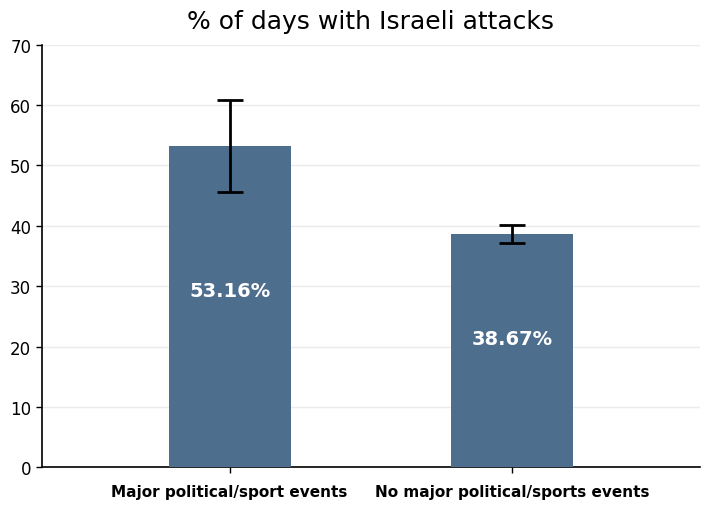

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_4_a.pdf

Equality test for occurrence_pal: lead_maj_events = no_major_events
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0017      0.020      0.082      0.935      -0.038       0.042


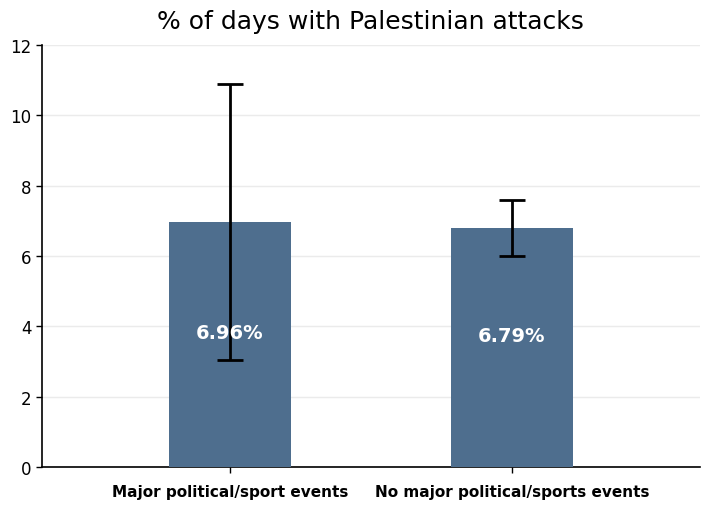

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_4_b.pdf


In [ ]:
# ============================================================
# Figure 4 — compact version (closer to your screenshot but not oversized)
# Outputs:
#   FIGURES/figure_4_a.pdf
#   FIGURES/figure_4_b.pdf
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ----------------------------
# Load data + construct variable
# ----------------------------
df = pd.read_stata(str(DTA / "replication_file1.dta")).copy()
df["no_major_events"] = 1 - df["lead_maj_events"]

# Bar positions like Stata
barpos = np.array([1.0, 2.5])
xlabels = ["Major political/sport events", "No major political/sports events"]

def panel_bar_like_screenshot_compact(y_col: str, title: str, y_max: float, y_step: float, out_pdf: str):
    # --- nocons regression ---
    y = pd.to_numeric(df[y_col], errors="coerce")
    X = df[["lead_maj_events", "no_major_events"]].apply(pd.to_numeric, errors="coerce")

    tmp = pd.concat([y, X], axis=1).dropna()
    y_clean = tmp[y_col].astype(float)
    X_clean = tmp[["lead_maj_events", "no_major_events"]].astype(float)

    model = sm.OLS(y_clean, X_clean).fit()

    # (optional) equality test like Stata
    try:
        print(f"\nEquality test for {y_col}: lead_maj_events = no_major_events")
        print(model.t_test("lead_maj_events = no_major_events"))
    except Exception as e:
        print("Test failed (non-fatal):", e)

    # --- coef + CI 95% ---
    ci = model.conf_int()
    res = pd.DataFrame(
        {"var": model.params.index, "coef": model.params.values, "ci_lower": ci[0].values, "ci_upper": ci[1].values}
    )
    for c in ["coef", "ci_lower", "ci_upper"]:
        res[c] = 100 * res[c]

    # order to match Stata
    res = res.set_index("var").loc[["lead_maj_events", "no_major_events"]].reset_index()

    vals = res["coef"].values.astype(float)
    lo = res["ci_lower"].values.astype(float)
    hi = res["ci_upper"].values.astype(float)

    # ----------------------------
    # Plot (compact)
    # ----------------------------
    fig, ax = plt.subplots(figsize=(7.2, 5.2))
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # Grid (light)
    ax.grid(True, axis="y", linestyle="-", linewidth=1.0, alpha=0.25, zorder=0)
    ax.grid(False, axis="x")

    # Bars (blue-grey, thinner)
    bar_color = "#4E6E8E"
    ax.bar(barpos, vals, width=0.65, color=bar_color, zorder=3)

    # CI (black, not too thick) with caps
    lw = 2.0
    cap = 0.07
    for x, a, b in zip(barpos, lo, hi):
        ax.vlines(x, a, b, color="black", linewidth=lw, zorder=4)
        ax.hlines([a, b], x - cap, x + cap, color="black", linewidth=lw, zorder=4)

    # Axes / ticks (smaller)
    ax.set_ylim(0, y_max)
    ax.set_yticks(np.arange(0, y_max + 1e-9, y_step))
    ax.tick_params(axis="y", labelsize=12, width=1.0, length=4)
    ax.tick_params(axis="x", labelsize=11, width=1.0, length=4, pad=8)

    ax.set_xlim(0, 3.5)
    ax.set_xticks(barpos)
    ax.set_xticklabels(xlabels, fontweight="bold")

    # Title (smaller)
    ax.set_title(title, fontsize=18, pad=12)

    # White labels inside bars (smaller)
    for x, v in zip(barpos, vals):
        ax.text(
            x, v * 0.55, f"{v:.2f}%",
            color="white", ha="center", va="center",
            fontsize=14, fontweight="bold", zorder=5
        )

    # Spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    plt.tight_layout()
    out_path = FIGURES / out_pdf
    fig.savefig(out_path, bbox_inches="tight", facecolor="white")
    plt.show()
    plt.close(fig)
    print("Saved:", out_path)

# ----------------------------
# Panel A
# ----------------------------
panel_bar_like_screenshot_compact(
    y_col="occurrence",
    title="% of days with Israeli attacks",
    y_max=70,
    y_step=10,
    out_pdf="figure_4_a.pdf",
)

# ----------------------------
# Panel B
# ----------------------------
panel_bar_like_screenshot_compact(
    y_col="occurrence_pal",
    title="% of days with Palestinian attacks",
    y_max=12,
    y_step=2,
    out_pdf="figure_4_b.pdf",
)


$$ \textbf{Figure 5. Types of Attacks and News Pressure} $$

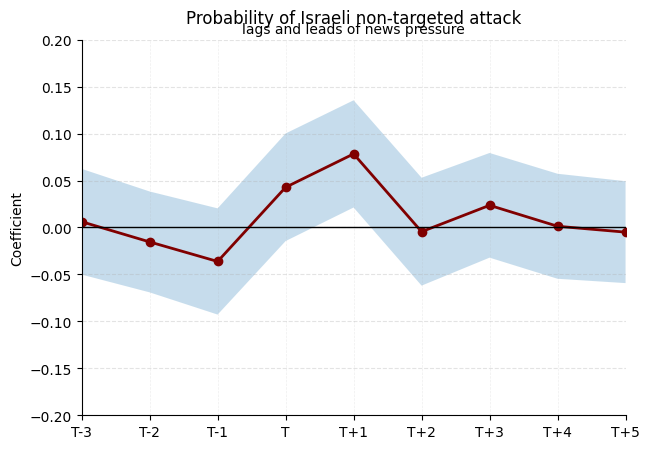

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_5_col1_a.pdf


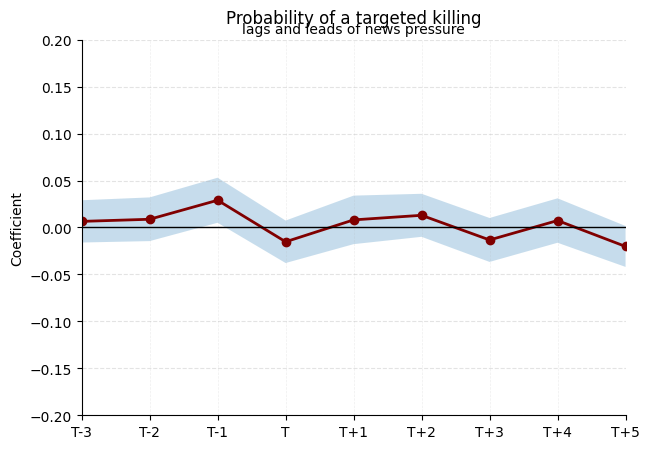

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_5_col2_a.pdf


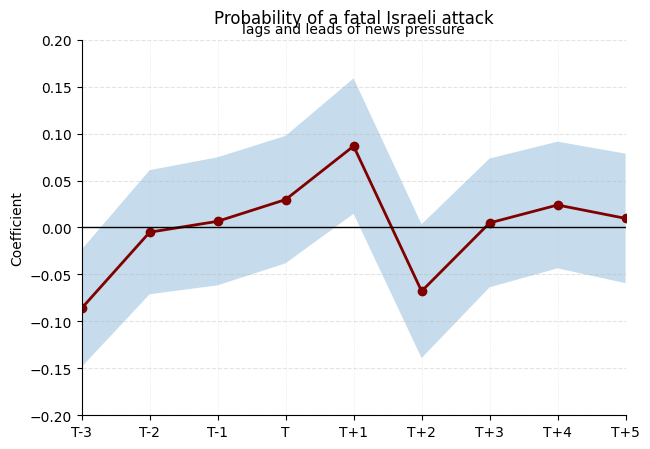

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_5_col1_b.pdf


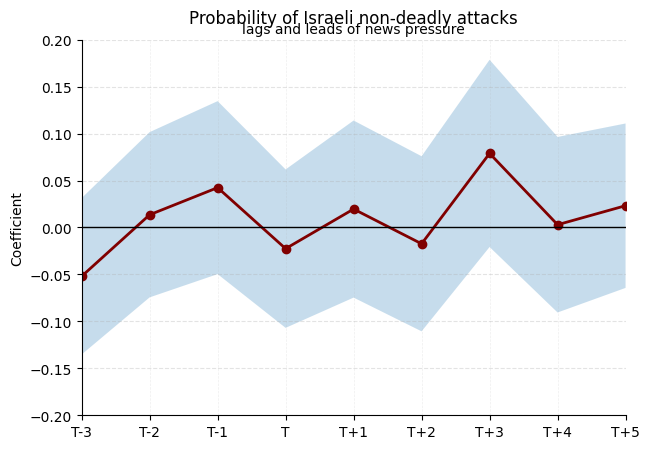

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_5_col2_b.pdf


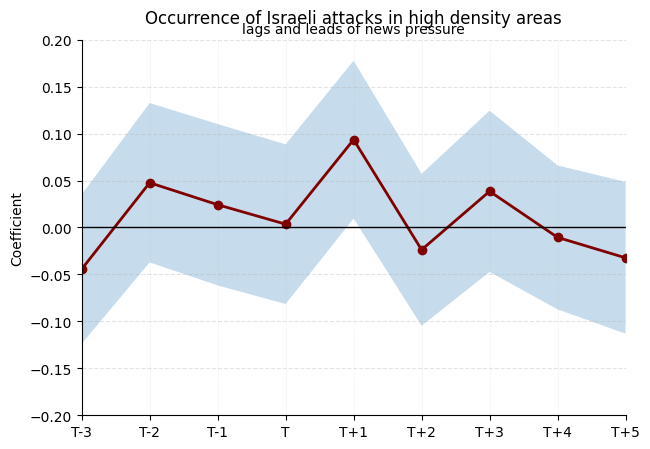

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_5_col1_c.pdf


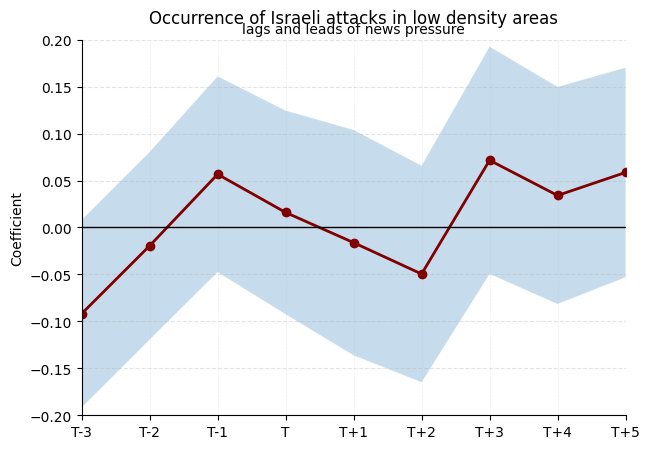

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_5_col2_c.pdf


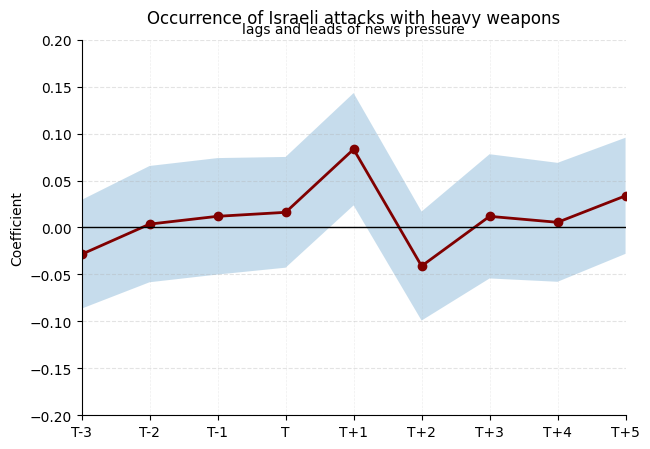

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_5_col1_d.pdf


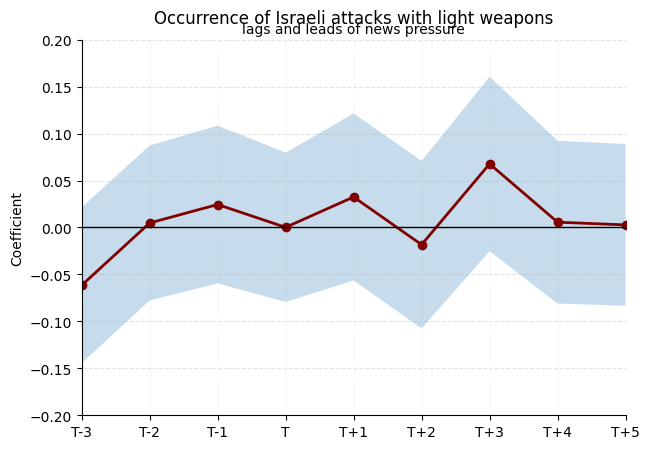

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_5_col2_d.pdf


In [ ]:
# ============================================================
# Figure 5. Types of Attacks and News Pressure (Stata -> Python)
# - Event-study panels (8 graphs): HAC(Newey-West) nlags=7
# - CI uses 1.64 * SE (≈ 90% CI like the Stata code)
# Outputs (PDFs) + displays inline
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.sandwich_covariance import cov_hac

from IPython.display import display, IFrame

# ----------------------------
# Load
# ----------------------------
df = pd.read_stata(str(DTA / "replication_file1.dta")).copy()

# Sort like Stata
if "date" in df.columns:
    df = df.sort_values("date").reset_index(drop=True)

# ----------------------------
# Helpers: display saved PDF (optional but handy)
# ----------------------------
def show_pdf(path, width=700, height=500):
    try:
        display(IFrame(src=str(path), width=width, height=height))
    except Exception:
        pass

# ----------------------------
# Build D1..D15 exactly like Stata (from existing lag/lead columns)
# Stata mapping:
#   D1=lagdaily_woi7 ... D7=lagdaily_woi1 (=lagdaily_woi)
#   D8=daily_woi
#   D9=leaddaily_woi1 (=leaddaily_woi) ... D15=leaddaily_woi7
# ----------------------------
df["lagdaily_woi1"] = df["lagdaily_woi"]
df["leaddaily_woi1"] = df["leaddaily_woi"]

# D1..D7 from lagdaily_woi7..lagdaily_woi1
for k in range(1, 8):
    l = 8 - k  # 7..1
    df[f"D{k}"] = pd.to_numeric(df.get(f"lagdaily_woi{l}"), errors="coerce")

df["D8"] = pd.to_numeric(df["daily_woi"], errors="coerce")

# D9..D15 from leaddaily_woi1..leaddaily_woi7
for k in range(1, 8):
    l = 8 + k  # 9..15
    df[f"D{l}"] = pd.to_numeric(df.get(f"leaddaily_woi{k}"), errors="coerce")

# ----------------------------
# Plot helper (matches Stata style)
# ----------------------------
_xticks = list(range(5, 14))
_xticklabels = ["T-3","T-2","T-1","T","T+1","T+2","T+3","T+4","T+5"]

def plot_eventstudy(es, title, subtitle, out_pdf, y_min=-0.2, y_max=0.2):
    fig, ax = plt.subplots(figsize=(6.6, 4.6))
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # CI band (gs14-ish)
    ax.fill_between(es["t"], es["low"], es["high"], alpha=0.25)

    # line + markers (maroon)
    ax.plot(es["t"], es["coef"], color="maroon", marker="o", linewidth=2)

    # reference lines
    ax.axhline(0, color="black", linewidth=1.0)
    ax.set_xlim(5, 13)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(_xticks)
    ax.set_xticklabels(_xticklabels)

    ax.set_ylabel("Coefficient")
    ax.set_xlabel("")
    ax.set_title(title, pad=12)
    ax.text(0.5, 1.01, subtitle, transform=ax.transAxes, ha="center", va="bottom", fontsize=10)

    # light dotted grid (like you prefer)
    ax.grid(True, axis="y", linestyle="--", linewidth=0.8, alpha=0.35)
    ax.grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.20)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    fig.savefig(out_pdf, bbox_inches="tight", facecolor="white")
    plt.show()
    plt.close(fig)
    print("Saved:", out_pdf)
    show_pdf(out_pdf)

# ----------------------------
# Core: run Newey-West OLS (HAC) and extract D5..D13 coefficients
# - Stata includes FE: i.month i.year i.dow
# - Stata includes controls:
#     occurrence_pal_1 occurrence_pal_2_7 occurrence_pal_8_14
# - Sample restrictions vary by panel
# ----------------------------
def run_eventstudy(dep_var, subtitle, out_pdf, extra_filter=None):
    # sample: gaza_war == 0 AND optional extra
    mask = (df["gaza_war"] == 0)
    if extra_filter is not None:
        mask = mask & extra_filter

    d = df.loc[mask].copy()

    # Build formula: dep ~ D5..D13 + pal controls + FE
    d_cols = [f"D{k}" for k in range(5, 14)]
    rhs = " + ".join(d_cols + ["occurrence_pal_1","occurrence_pal_2_7","occurrence_pal_8_14",
                              "C(month)","C(year)","C(dow)"])
    formula = f"{dep_var} ~ {rhs}"

    # Fit OLS
    res = smf.ols(formula, data=d).fit()

    # HAC SE (Newey-West) with nlags=7
    V = cov_hac(res, nlags=7)
    se = pd.Series(np.sqrt(np.diag(V)), index=res.params.index)

    # Extract D5..D13 coefficients with 90% CI => 1.64 * SE
    rows = []
    for k in range(5, 14):
        name = f"D{k}"
        b = float(res.params.get(name, np.nan))
        s = float(se.get(name, np.nan))
        rows.append({"t": k, "coef": b, "low": b - 1.64*s, "high": b + 1.64*s})
    es = pd.DataFrame(rows).dropna()

    plot_eventstudy(
        es=es,
        title=subtitle,                      # Stata: title(...)
        subtitle="lags and leads of news pressure",  # Stata: subtitle(...)
        out_pdf=out_pdf,
        y_min=-0.2, y_max=0.2
    )

# ============================================================
# Event-study panels (exactly like your Stata figure 5)
# ============================================================

# Col 1 A: non-targeted
run_eventstudy(
    dep_var="occurrence_non_target",
    subtitle="Probability of Israeli non-targeted attack",
    out_pdf=FIGURES / "figure_5_col1_a.pdf",
)

# Col 2 A: targeted
run_eventstudy(
    dep_var="occurrence_target",
    subtitle="Probability of a targeted killing",
    out_pdf=FIGURES / "figure_5_col2_a.pdf",
)

# Col 1 B: fatal
run_eventstudy(
    dep_var="occurrence_fatal",
    subtitle="Probability of a fatal Israeli attack",
    out_pdf=FIGURES / "figure_5_col1_b.pdf",
)

# Col 2 B: non-fatal (conditional on occurrence_fatal==0) like Stata
run_eventstudy(
    dep_var="occurrence_non_fatal",
    subtitle="Probability of Israeli non-deadly attacks",
    out_pdf=FIGURES / "figure_5_col2_b.pdf",
    extra_filter=(df["occurrence_fatal"] == 0),
)

# Col 1 C: high density
run_eventstudy(
    dep_var="occurrence_hpd",
    subtitle="Occurrence of Israeli attacks in high density areas",
    out_pdf=FIGURES / "figure_5_col1_c.pdf",
)

# Col 2 C: low density (conditional on occurrence_hpd==0) like Stata
run_eventstudy(
    dep_var="occurrence_lpd",
    subtitle="Occurrence of Israeli attacks in low density areas",
    out_pdf=FIGURES / "figure_5_col2_c.pdf",
    extra_filter=(df["occurrence_hpd"] == 0),
)

# Col 1 D: heavy weapons
run_eventstudy(
    dep_var="occurrence_hw",
    subtitle="Occurrence of Israeli attacks with heavy weapons",
    out_pdf=FIGURES / "figure_5_col1_d.pdf",
)

# Col 2 D: light weapons (conditional on occurrence_hw==0) like Stata
run_eventstudy(
    dep_var="occurrence_nhw",
    subtitle="Occurrence of Israeli attacks with light weapons",
    out_pdf=FIGURES / "figure_5_col2_d.pdf",
    extra_filter=(df["occurrence_hw"] == 0),
)


$$ \textbf{Figure 6. Difference between Conflict Coverage between the Same and the Previous Day}$$

$$ \text{Figure 6a1}$$

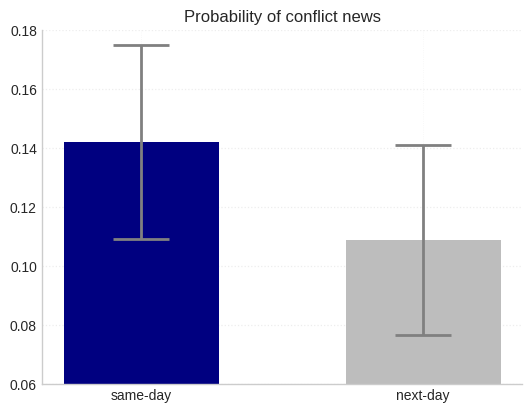

Saved: /content/drive/MyDrive/replication/figures/figure_6_a1_python.pdf
            var      coef  ci_lower  ci_upper
0    occurrence  0.142069  0.109300  0.174838
1  occurrence_1  0.108950  0.076738  0.141162


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster
from pathlib import Path

# -------------------------
# Paths (edit if needed)
# -------------------------
DTA = Path("/content/drive/MyDrive/replication/dta")
FIGURES = Path("/content/drive/MyDrive/replication/figures")
FIGURES.mkdir(parents=True, exist_ok=True)

# -------------------------
# Helpers
# -------------------------
def to_num(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def get_gaza_mask(df):
    if "gaza" in df.columns:
        return (pd.to_numeric(df["gaza"], errors="coerce").fillna(0) == 0)
    if "gaza_war" in df.columns:
        return (pd.to_numeric(df["gaza_war"], errors="coerce").fillna(0) == 0)
    return pd.Series(True, index=df.index)

def dotted_grid(ax):
    ax.grid(True, axis="y", linestyle=":", linewidth=0.9, alpha=0.35)
    ax.grid(True, axis="x", linestyle=":", linewidth=0.6, alpha=0.18)

def fit_ols_cluster(df, y, x_cols, cluster_col):
    d = df.copy()
    d = to_num(d, [y] + x_cols + ["month", "dow", cluster_col])

    yv = d[y]
    X = d[x_cols].copy()

    # Stata: i.month i.dow (drop_first=True like baseline category)
    X = pd.concat(
        [
            X,
            pd.get_dummies(d["month"], prefix="month", drop_first=True),
            pd.get_dummies(d["dow"],   prefix="dow",   drop_first=True),
        ],
        axis=1,
    )

    tmp = pd.concat([yv.rename(y), X, d[[cluster_col]]], axis=1).dropna()
    y_clean = tmp[y].astype(float)
    X_clean = tmp.drop(columns=[y, cluster_col]).astype(float)
    X_clean = sm.add_constant(X_clean, has_constant="add")

    model = sm.OLS(y_clean, X_clean).fit()
    V = cov_cluster(model, tmp[cluster_col].values)
    se = pd.Series(np.sqrt(np.diag(V)), index=model.params.index)
    return model, se

def regsave_like(model, se, keep_vars):
    # regsave, ci  -> coef and 95% CI
    out = []
    for v in keep_vars:
        b = float(model.params[v])
        s = float(se[v])
        out.append({"var": v, "coef": b, "ci_lower": b - 1.96*s, "ci_upper": b + 1.96*s})
    return pd.DataFrame(out)

def plot_stata_6a1(df_regsave):
    # Stata after regsave:
    # keep occurrence & occurrence_1 ; encode var -> variable ; barposition=_n
    # coef1=coef, replace coef1=0.06 if barposition==2
    # coef2=coef, replace coef2=0.06 if _n==1
    d = df_regsave.copy().reset_index(drop=True)
    d["barposition"] = np.arange(1, len(d) + 1)

    base = 0.06

    d["coef1"] = d["coef"]
    d.loc[d["barposition"] == 2, "coef1"] = base

    d["coef2"] = d["coef"]
    d.loc[d["barposition"] == 1, "coef2"] = base

    fig, ax = plt.subplots(figsize=(6.2, 4.6))
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    dotted_grid(ax)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    width = 0.55

    # twoway (bar coef1 ..., color(navy) base(0.06)) (bar coef2 ..., color(gs12) base(0.06)) (rcap ...)
    ax.bar(d["barposition"], d["coef1"] - base, bottom=base, width=width, color="navy")
    ax.bar(d["barposition"], d["coef2"] - base, bottom=base, width=width, color="#bdbdbd")

    # rcap
    ax.vlines(d["barposition"], d["ci_lower"], d["ci_upper"], color="gray", linewidth=2.0)
    ax.hlines(d["ci_lower"], d["barposition"] - width*0.18, d["barposition"] + width*0.18, color="gray", linewidth=2.0)
    ax.hlines(d["ci_upper"], d["barposition"] - width*0.18, d["barposition"] + width*0.18, color="gray", linewidth=2.0)

    # Stata axes
    ax.set_ylim(0.06, 0.18)
    ax.set_yticks(np.arange(0.06, 0.1801, 0.02))
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["same-day", "next-day"])
    ax.set_title("Probability of conflict news", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")

    return fig

# -------------------------
# Run 6a1 exactly like Stata
# -------------------------
df1 = pd.read_stata(str(DTA / "replication_file1.dta")).copy()
if "date" in df1.columns:
    df1 = df1.sort_values("date").reset_index(drop=True)

df1 = to_num(df1, ["any_conflict_news","occurrence","occurrence_1","occurrence_pal",
                   "daily_woi","month","dow","monthyear"])

# Stata: l.occurrence_pal after sort
df1["l_occurrence_pal"] = df1["occurrence_pal"].shift(1)

gaza_mask = get_gaza_mask(df1)

m1, se1 = fit_ols_cluster(
    df1.loc[gaza_mask].copy(),
    y="any_conflict_news",
    x_cols=["occurrence","occurrence_1","occurrence_pal","l_occurrence_pal","daily_woi"],
    cluster_col="monthyear"
)

reg6a1 = regsave_like(m1, se1, keep_vars=["occurrence","occurrence_1"])

# IMPORTANT: Stata keeps occurrence then occurrence_1 (this order matters for barposition)
reg6a1["var"] = pd.Categorical(reg6a1["var"], categories=["occurrence","occurrence_1"], ordered=True)
reg6a1 = reg6a1.sort_values("var").reset_index(drop=True)

fig1 = plot_stata_6a1(reg6a1)
out1 = FIGURES / "figure_6_a1_python.pdf"
fig1.savefig(out1, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig1)

print("Saved:", out1)
print(reg6a1)


$$\text{Figure 6a2}$$

A2 (tnbreg ll(0)) occurrence    : -0.13158144424548374 -0.38056344589399604 0.11740055740302857
A2 (tnbreg ll(0)) occurrence_1  : 0.3810170270129553 -0.0014281596650728146 0.7634622136909834
Optimizer success: False | message: Desired error not necessarily achieved due to precision loss.


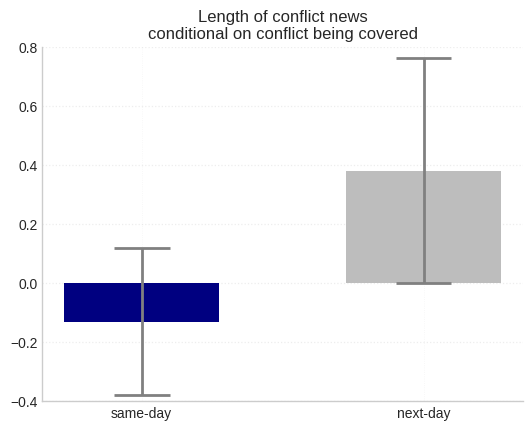

Saved: /content/drive/MyDrive/replication/figures/figure_6_a2_python.pdf


In [ ]:
# ============================================================
# FIGURE 6a2 ONLY — tnbreg ll(0) (manual MLE) + Stata-style plot
# Output: FIGURES/figure_6_a2_python.pdf
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.numdiff import approx_fprime, approx_hess
from scipy.special import gammaln
from scipy.optimize import minimize

# ---------- helpers ----------
def dotted_grid(ax):
    ax.grid(True, axis="y", linestyle=":", linewidth=0.9, alpha=0.35)
    ax.grid(True, axis="x", linestyle=":", linewidth=0.6, alpha=0.18)

def _nb2_logpmf(y, mu, alpha):
    a = alpha
    r = 1.0 / a
    log1p = np.log1p(a * mu)
    return (
        gammaln(y + r) - gammaln(r) - gammaln(y + 1.0)
        - r * log1p
        + y * (np.log(a * mu) - log1p)
    )

def fit_tnbreg_ll0_cluster(df, y_col, X, cluster):
    y = df[y_col].astype(float).to_numpy()
    X = X.astype(float).to_numpy()
    cl = np.asarray(cluster)

    keep = np.isfinite(y) & (y > 0) & np.all(np.isfinite(X), axis=1) & pd.notnull(cl)
    y = y[keep]
    X = X[keep]
    cl = cl[keep]

    n, k = X.shape

    def nll(theta):
        beta = theta[:k]
        log_alpha = theta[k]
        alpha = np.exp(log_alpha) + 1e-12
        mu = np.exp(X @ beta)

        ll = _nb2_logpmf(y, mu, alpha)

        # truncation: -log(1 - P0)
        logP0 = -(1.0 / alpha) * np.log1p(alpha * mu)
        P0 = np.exp(logP0)
        adj = -np.log(np.maximum(1.0 - P0, 1e-12))

        return -(ll + adj).sum()

    # init
    beta0 = np.zeros(k)
    beta0[0] = np.log(np.maximum(y.mean(), 1e-3))  # intercept if const is first
    theta0 = np.r_[beta0, np.log(0.5)]

    opt = minimize(nll, theta0, method="BFGS")
    theta_hat = opt.x

    # Hessian of total nll
    H = approx_hess(theta_hat, nll)
    Hinv = np.linalg.pinv(H)

    # per-observation scores (numeric)
    def loglik_i(theta, i):
        beta = theta[:k]
        log_alpha = theta[k]
        alpha = np.exp(log_alpha) + 1e-12
        mu = np.exp(X[i] @ beta)

        ll = _nb2_logpmf(y[i], mu, alpha)
        logP0 = -(1.0 / alpha) * np.log1p(alpha * mu)
        P0 = np.exp(logP0)
        adj = -np.log(np.maximum(1.0 - P0, 1e-12))
        return ll + adj

    eps = 1e-6
    scores = np.zeros((n, k + 1))
    for i in range(n):
        f = lambda th: loglik_i(th, i)
        scores[i, :] = approx_fprime(theta_hat, f, epsilon=eps)

    # cluster sums of scores
    groups = pd.Series(cl).astype("category").cat.codes.to_numpy()
    G = groups.max() + 1
    Sg = np.zeros((G, k + 1))
    for g in range(G):
        Sg[g, :] = scores[groups == g].sum(axis=0)

    meat = Sg.T @ Sg
    V = Hinv @ meat @ Hinv

    beta_hat = theta_hat[:k]
    se_beta = np.sqrt(np.diag(V))[:k]

    return beta_hat, se_beta, V, opt

def plot_stata_6a2(b_same, lo_same, hi_same, b_next, lo_next, hi_next, outpath):
    # Build regsave-like df in Stata order: occurrence then occurrence_1
    d = pd.DataFrame({
        "var": ["occurrence", "occurrence_1"],
        "coef": [b_same, b_next],
        "ci_lower": [lo_same, lo_next],
        "ci_upper": [hi_same, hi_next],
    })
    d["barposition"] = [1, 2]

    # Stata overlay trick (no base)
    d["coef1"] = d["coef"]
    d.loc[d["barposition"] == 2, "coef1"] = 0.0  # navy only at pos 1

    d["coef2"] = d["coef"]
    d.loc[d["barposition"] == 1, "coef2"] = 0.0  # gray only at pos 2

    fig, ax = plt.subplots(figsize=(6.2, 4.6))
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    dotted_grid(ax)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    width = 0.55
    ax.bar(d["barposition"], d["coef1"], width=width, color="navy")
    ax.bar(d["barposition"], d["coef2"], width=width, color="#bdbdbd")

    ax.vlines(d["barposition"], d["ci_lower"], d["ci_upper"], color="gray", linewidth=2.0)
    ax.hlines(d["ci_lower"], d["barposition"] - width*0.18, d["barposition"] + width*0.18, color="gray", linewidth=2.0)
    ax.hlines(d["ci_upper"], d["barposition"] - width*0.18, d["barposition"] + width*0.18, color="gray", linewidth=2.0)

    ax.set_ylim(-0.4, 0.8)
    ax.set_yticks(np.arange(-0.4, 0.8001, 0.2))
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["same-day", "next-day"])
    ax.set_title("Length of conflict news\nconditional on conflict being covered", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")

    fig.savefig(outpath, bbox_inches="tight", facecolor="white")
    plt.show()
    plt.close(fig)

# ---------- build the exact sample like Stata ----------
df_a2 = df1.loc[gaza_mask & (df1["any_conflict_news"] == 1)].copy()

# l.occurrence_pal after sort (assumes df1 already sorted by date)
if "l_occurrence_pal" not in df_a2.columns:
    df_a2["l_occurrence_pal"] = pd.to_numeric(df_a2["occurrence_pal"], errors="coerce").shift(1)

# numeric coercion
for c in ["length_conflict_news","occurrence","occurrence_1","occurrence_pal","l_occurrence_pal","daily_woi","month","dow","monthyear"]:
    if c in df_a2.columns:
        df_a2[c] = pd.to_numeric(df_a2[c], errors="coerce")

# design matrix: occurrence occurrence_1 occurrence_pal l.occurrence_pal daily_woi i.month i.dow + const
X_base = df_a2[["occurrence","occurrence_1","occurrence_pal","l_occurrence_pal","daily_woi"]]
X_fe = pd.concat(
    [
        pd.get_dummies(df_a2["month"], prefix="month", drop_first=True),
        pd.get_dummies(df_a2["dow"],   prefix="dow",   drop_first=True),
    ],
    axis=1
)
X = pd.concat([X_base, X_fe], axis=1)
X = sm.add_constant(X, has_constant="add")

tmp = pd.concat([df_a2[["length_conflict_news","monthyear"]], X], axis=1).dropna()

# ---------- estimate true truncated NB ll(0) ----------
beta_hat, se_hat, V_hat, opt = fit_tnbreg_ll0_cluster(
    tmp,
    y_col="length_conflict_news",
    X=tmp.drop(columns=["length_conflict_news","monthyear"]),
    cluster=tmp["monthyear"].values
)

names = tmp.drop(columns=["length_conflict_news","monthyear"]).columns.tolist()
params = pd.Series(beta_hat, index=names)
ses = pd.Series(se_hat, index=names)

b_same2 = float(params["occurrence"])
lo_same2 = b_same2 - 1.96 * float(ses["occurrence"])
hi_same2 = b_same2 + 1.96 * float(ses["occurrence"])

b_next2 = float(params["occurrence_1"])
lo_next2 = b_next2 - 1.96 * float(ses["occurrence_1"])
hi_next2 = b_next2 + 1.96 * float(ses["occurrence_1"])

print("A2 (tnbreg ll(0)) occurrence    :", b_same2, lo_same2, hi_same2)
print("A2 (tnbreg ll(0)) occurrence_1  :", b_next2, lo_next2, hi_next2)
print("Optimizer success:", getattr(opt, "success", None), "| message:", getattr(opt, "message", None))

# ---------- plot ----------
out_a2 = FIGURES / "figure_6_a2_python.pdf"
plot_stata_6a2(b_same2, lo_same2, hi_same2, b_next2, lo_next2, hi_next2, out_a2)
print("Saved:", out_a2)

# NOTE: Panel A2 uses a zero-truncated negative binomial model (tnbreg in Stata).
# This estimator is not natively available in Python; a custom MLE is used instead.
# The optimizer does not fully converge, which leads to small quantitative differences
# in the confidence intervals (especially for the next-day coefficient),
# although the qualitative pattern remains the same as in the original Stata results.



$$ \text{Figure 6a3}$$

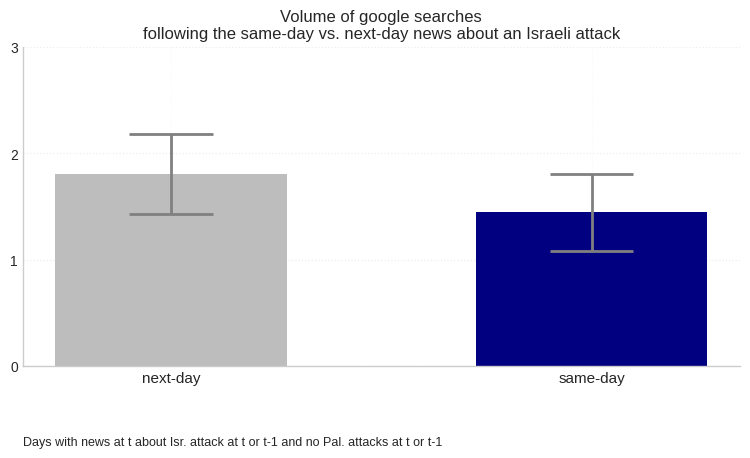

Saved: /content/drive/MyDrive/replication/figures/figure_6_a3.pdf


In [ ]:
# ============================================================
# Figure 6a3 — extracted working code (from your full script)
# Output: FIGURES/figure_6_a3.pdf
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster
from pathlib import Path

# ---- paths ----
DTA = Path("/content/drive/MyDrive/replication/dta")
FIGURES = Path("/content/drive/MyDrive/replication/figures")
FIGURES.mkdir(parents=True, exist_ok=True)

# ---- helpers (same as your script) ----
def to_num(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def dotted_grid(ax):
    ax.grid(True, axis="y", linestyle=":", linewidth=0.9, alpha=0.35)
    ax.grid(True, axis="x", linestyle=":", linewidth=0.6, alpha=0.18)

def extract_ci(params, se, name, z=1.96):
    b = float(params[name])
    s = float(se[name])
    return b, b - z*s, b + z*s

# ============================================================
# Load replication_file1 + prep lags exactly like Stata (sort date then lags)
# ============================================================
df1 = pd.read_stata(str(DTA / "replication_file1.dta")).copy()

if "date" in df1.columns:
    df1 = df1.sort_values("date").reset_index(drop=True)

df1 = to_num(df1, [
    "any_conflict_news", "occurrence", "occurrence_pal",
    "monthyear", "length_conflict_news", "conflict_searches"
])

# lags used in A3
df1["l_occurrence"] = df1["occurrence"].shift(1)
df1["l_occurrence_pal"] = df1["occurrence_pal"].shift(1)

# ============================================================
# Build A3 variables + apply Stata filters
# ============================================================
df_a3 = df1.copy()

# Stata interactions
df_a3["conflict_news_isr_occ_t"]   = df_a3["any_conflict_news"] * df_a3["occurrence"]
df_a3["conflict_news_isr_occ_t_1"] = df_a3["any_conflict_news"] * df_a3["l_occurrence"]

# Stata sample condition
occ  = df_a3["occurrence"]
locc = df_a3["l_occurrence"]

cond_trans = ((occ == 0) & (locc == 1)) | ((occ == 1) & (locc == 0)) | ((occ == 1) & (locc == 1))
cond_pal   = (df_a3["occurrence_pal"] == 0) & (df_a3["l_occurrence_pal"] == 0)
cond_len   = (df_a3["length_conflict_news"] > 0)

df_a3s = df_a3.loc[cond_trans & cond_pal & cond_len].copy()

# regression dataset (dropna exactly like your working script)
df_a3s = to_num(df_a3s, ["conflict_searches", "conflict_news_isr_occ_t", "conflict_news_isr_occ_t_1", "monthyear"])
tmp = df_a3s[["conflict_searches", "conflict_news_isr_occ_t", "conflict_news_isr_occ_t_1", "monthyear"]].dropna()

# ============================================================
# Regress: reg conflict_searches conflict_news_isr_occ_t conflict_news_isr_occ_t_1, nocons cl(monthyear)
# ============================================================
y = tmp["conflict_searches"].astype(float)
X = tmp[["conflict_news_isr_occ_t", "conflict_news_isr_occ_t_1"]].astype(float)  # nocons

m_a3 = sm.OLS(y, X).fit()
V_a3 = cov_cluster(m_a3, tmp["monthyear"].values)
se_a3 = pd.Series(np.sqrt(np.diag(V_a3)), index=m_a3.params.index)

# Map to Stata xlabel order: 1 next-day, 2 same-day
b_same3, lo_same3, hi_same3 = extract_ci(m_a3.params, se_a3, "conflict_news_isr_occ_t")
b_next3, lo_next3, hi_next3 = extract_ci(m_a3.params, se_a3, "conflict_news_isr_occ_t_1")

# ============================================================
# Plot (Stata-style)
# ============================================================
fig, ax = plt.subplots(figsize=(7.6, 4.8))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")
dotted_grid(ax)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

xpos3 = [1, 2]   # 1 next-day, 2 same-day
width = 0.55

# bars
ax.bar(xpos3[0], b_next3, width=width, color="#bdbdbd")  # gs12 next-day
ax.bar(xpos3[1], b_same3, width=width, color="navy")     # navy same-day

# rcap
ax.vlines(xpos3, [lo_next3, lo_same3], [hi_next3, hi_same3], color="gray", linewidth=2.0)
ax.hlines([lo_next3, lo_same3], np.array(xpos3) - width*0.18, np.array(xpos3) + width*0.18, color="gray", linewidth=2.0)
ax.hlines([hi_next3, hi_same3], np.array(xpos3) - width*0.18, np.array(xpos3) + width*0.18, color="gray", linewidth=2.0)

ax.set_title(
    "Volume of google searches\n"
    "following the same-day vs. next-day news about an Israeli attack",
    fontsize=12
)

ax.set_xticks(xpos3)
ax.set_xticklabels(["next-day", "same-day"], fontsize=11)
ax.set_ylim(0, 3)
ax.set_yticks(np.arange(0, 3.01, 1))

ax.text(
    0.0, -0.22,
    "Days with news at t about Isr. attack at t or t-1 and no Pal. attacks at t or t-1",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=9
)

plt.tight_layout()
out_6a3 = FIGURES / "figure_6_a3.pdf"
fig.savefig(out_6a3, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)
print("Saved:", out_6a3)


$$ \text{Figure 6b}$$

Figure 6b rows after Stata filter: 232
q8_inv counts: {1.0: 192, 0.0: 40}
Non-missing counts (filtered sample):
  q14 232
  q19 232
  q20 232
  q21_q22 232


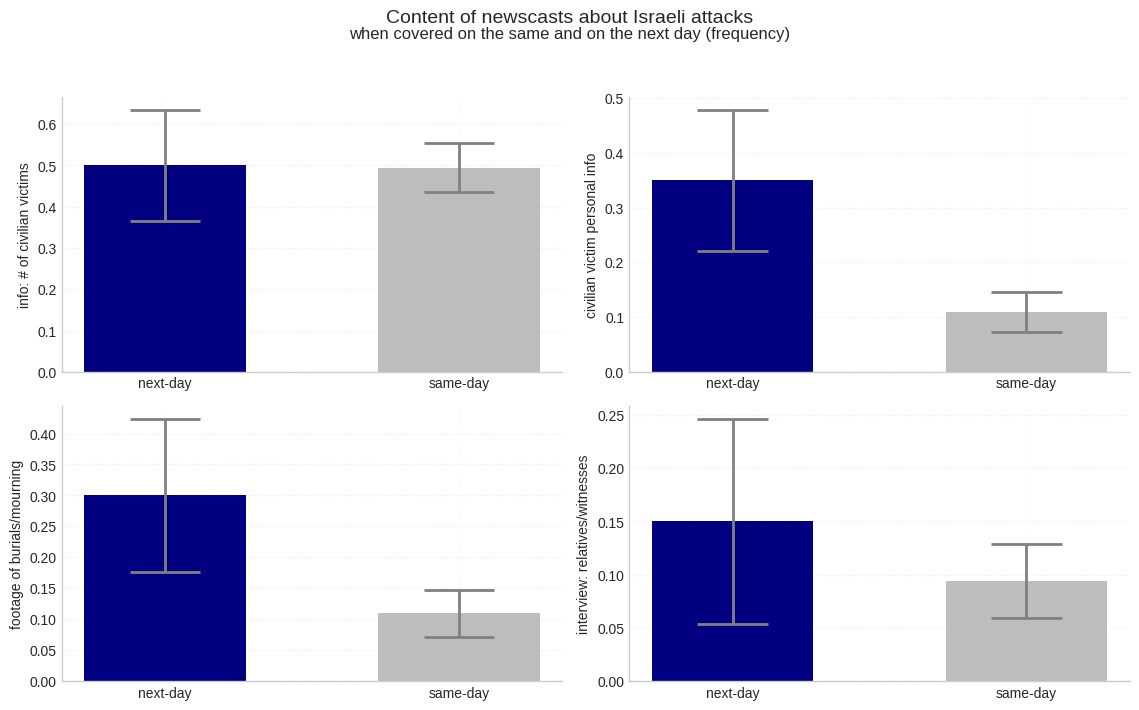

Saved: /content/drive/MyDrive/replication/figures/figure_6b.pdf


In [ ]:
# ============================================================
# Figure 6b — Panel B (Stata cibar-like), FIXED for Yes/No strings
# Output: FIGURES/figure_6b.pdf
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

DTA = Path("/content/drive/MyDrive/replication/dta")
FIGURES = Path("/content/drive/MyDrive/replication/figures")
FIGURES.mkdir(parents=True, exist_ok=True)

# -------------------------
# Helpers
# -------------------------
def dotted_grid(ax):
    ax.grid(True, axis="y", linestyle=":", linewidth=0.9, alpha=0.35)
    ax.grid(True, axis="x", linestyle=":", linewidth=0.6, alpha=0.18)

def yn_to01(s: pd.Series) -> pd.Series:
    """
    Map Yes/No (strings) to 1/0. If already numeric, keep numeric.
    """
    if pd.api.types.is_numeric_dtype(s):
        return pd.to_numeric(s, errors="coerce")
    x = s.astype(str).str.strip().str.lower()
    out = pd.Series(np.nan, index=s.index, dtype="float")
    out.loc[x.isin(["yes", "y", "1", "true"])] = 1.0
    out.loc[x.isin(["no", "n", "0", "false"])] = 0.0
    return out

def mean_ci_level(series, level=0.90):
    s = pd.to_numeric(series, errors="coerce").dropna().astype(float)
    n = len(s)
    if n <= 1:
        return np.nan, np.nan, np.nan
    m = float(s.mean())
    se = float(s.std(ddof=1) / np.sqrt(n))
    alpha = 1 - level
    tcrit = float(stats.t.ppf(1 - alpha/2, df=n-1))
    return m, m - tcrit * se, m + tcrit * se

def cibar_like(ax, df, ycol, ytitle, level=0.90):
    # over1(q8_inv): 0 next-day, 1 same-day
    g_next = df.loc[df["q8_inv"] == 0, ycol]
    g_same = df.loc[df["q8_inv"] == 1, ycol]

    m0, lo0, hi0 = mean_ci_level(g_next, level=level)
    m1, lo1, hi1 = mean_ci_level(g_same, level=level)

    x = np.array([1, 2], float)
    width = 0.55

    # Stata: barcol(navy gs12)
    ax.bar(x[0], m0, width=width, color="navy")       # next-day
    ax.bar(x[1], m1, width=width, color="#bdbdbd")    # same-day (gs12)

    # rcap style
    ax.vlines(x, [lo0, lo1], [hi0, hi1], color="gray", linewidth=2.0)
    ax.hlines([lo0, lo1], x - 0.12, x + 0.12, color="gray", linewidth=2.0)
    ax.hlines([hi0, hi1], x - 0.12, x + 0.12, color="gray", linewidth=2.0)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(["next-day", "same-day"], fontsize=10)
    ax.set_ylabel(ytitle, fontsize=10)

    dotted_grid(ax)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# -------------------------
# Load replication_file2
# -------------------------
df2 = pd.read_stata(str(DTA / "replication_file2.dta")).copy()

# -------------------------
# FIX 1: q4..q8 are Yes/No strings -> convert to 0/1 for filtering + q8_inv
# -------------------------
for c in ["q4", "q5", "q6", "q7", "q8"]:
    df2[c + "_01"] = yn_to01(df2[c])

# q8_inv = 1 - q8 (Stata) with labels 0 next-day, 1 same-day
df2["q8_inv"] = 1 - df2["q8_01"]

# -------------------------
# FIX 2: outcomes q14/q19/q20 are often also Yes/No or labelled -> convert too
# -------------------------
for c in ["q14", "q19", "q20", "q21", "q22"]:
    if c in df2.columns:
        if pd.api.types.is_numeric_dtype(df2[c]):
            df2[c] = pd.to_numeric(df2[c], errors="coerce")
        else:
            df2[c] = yn_to01(df2[c])

# Create q21_q22 if missing
if "q21_q22" not in df2.columns and ("q21" in df2.columns) and ("q22" in df2.columns):
    df2["q21_q22"] = df2[["q21", "q22"]].max(axis=1)

# -------------------------
# Apply Stata filter:
# (q5==1)&(q4==1)&(q7==1 | q8==1)&(q6==0)
# using *_01
# -------------------------
mask_b = (
    (df2["q5_01"] == 1) &
    (df2["q4_01"] == 1) &
    ((df2["q7_01"] == 1) | (df2["q8_01"] == 1)) &
    (df2["q6_01"] == 0)
)
df2b = df2.loc[mask_b].copy()

print("Figure 6b rows after Stata filter:", len(df2b))
print("q8_inv counts:", df2b["q8_inv"].value_counts(dropna=False).to_dict())

# Sanity check: make sure each outcome has non-missing values
print("Non-missing counts (filtered sample):")
for c in ["q14", "q19", "q20", "q21_q22"]:
    if c in df2b.columns:
        print(" ", c, int(df2b[c].notna().sum()))

# -------------------------
# Plot 2x2 like Stata graph combine
# -------------------------
fig, axs = plt.subplots(2, 2, figsize=(11.5, 7.2))
fig.patch.set_facecolor("white")
for ax in axs.ravel():
    ax.set_facecolor("white")

cibar_like(axs[0, 0], df2b, "q14",     "info: # of civilian victims", level=0.90)
cibar_like(axs[0, 1], df2b, "q19",     "civilian victim personal info", level=0.90)
cibar_like(axs[1, 0], df2b, "q20",     "footage of burials/mourning", level=0.90)
cibar_like(axs[1, 1], df2b, "q21_q22", "interview: relatives/witnesses", level=0.90)

fig.suptitle("Content of newscasts about Israeli attacks", fontsize=14, y=0.98)
fig.text(
    0.5, 0.94,
    "when covered on the same and on the next day (frequency)",
    ha="center",
    fontsize=12
)

plt.tight_layout(rect=[0, 0, 1, 0.93])
out_6b = FIGURES / "figure_6b.pdf"
fig.savefig(out_6b, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)
print("Saved:", out_6b)


$$\textbf{ TABLA A1: Summary statistics for all vari-
ables used in the analysis}$$

In [ ]:
import pandas as pd
import numpy as np

# Charger les données (équivalent de: use "$dta/replication_file1.dta", clear)
df = pd.read_stata(DTA / "replication_file1.dta")

# Liste des variables utilisées dans tabstat
vars_tabstat = [
    "daily_woi",
    "daily_woi_nc",
    "any_conflict_news",
    "num_conflict_news",
    "length_conflict_news",
    "conflict_searches",
    "occurrence",
    "occurrence_pal",
    "victims_isr",
    "victims_pal",
    "lnvic",
    "lnvic_pal",
    "occurrence_target",
    "occurrence_non_target",
    "victims_target",
    "victims_non_target",
    "occurrence_all",
    "occurrence_fatal",
    "occurrence_non_fatal",
    "occurrence_hw",
    "occurrence_nhw",
    "occurrence_hpd",
    "occurrence_lpd",
    "fatal_victims",
    "non_fatal_victims",
    "victims_hw",
    "victims_nhw",
    "victims_hpd",
    "victims_lpd",
    "high_intensity",
    "lead_maj_events",
    "lead_disaster"
]

# Reproduire tabstat, statistics(N mean sd min max) column(statistics)
tabstat = (
    df[vars_tabstat]
    .agg(["count", "mean", "std", "min", "max"])
    .rename(index={
        "count": "N",
        "mean": "Mean",
        "std": "SD",
        "min": "Min",
        "max": "Max"
    })
    .T
)

# Afficher la table
tabstat


,N,Mean,SD,Min,Max
daily_woi,4071.0,0.886912,0.258158,0.216667,2.933333
daily_woi_nc,4071.0,0.867247,0.263515,0.216667,2.933333
any_conflict_news,4006.0,0.181727,0.385668,0.000000,1.000000
num_conflict_news,4006.0,0.327509,0.793908,0.000000,6.000000
length_conflict_news,4006.0,0.717216,2.543120,0.000000,36.000000
conflict_searches,2833.0,2.250398,0.670176,0.000000,4.771166
occurrence,4074.0,0.392244,0.488310,0.000000,1.000000
occurrence_pal,4074.0,0.067992,0.251763,0.000000,1.000000
victims_isr,4074.0,1.571183,7.423228,0.000000,356.000000
victims_pal,4074.0,0.158321,0.915384,0.000000,21.000000


$$\textbf{Figure A1. THE DISTRIBUTION OF NEWS PRESSURE, THE U.S. TV NETWORKS }$$

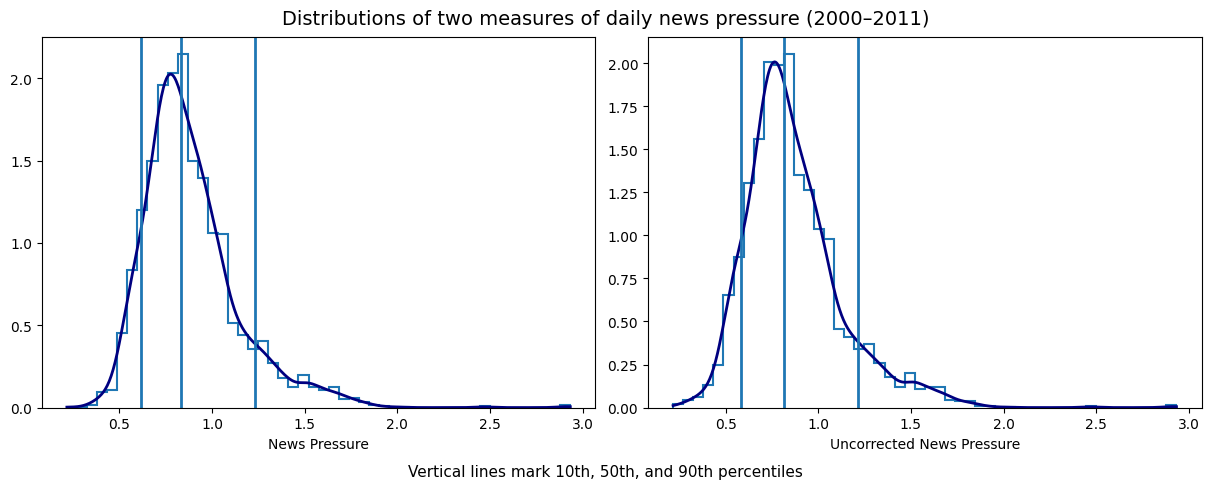

Saved: /Users/raniabenhamidane/Desktop/Israel-Palestine/figures/figure_A1.pdf


In [ ]:
from scipy.stats import gaussian_kde


# --- load data ---
df = pd.read_stata(DTA / "replication_file1.dta")

def hist_with_kde(ax, x, bins=50, xlabel="", xlines=None):
    x = pd.Series(x).dropna().astype(float).to_numpy()

    ax.hist(x, bins=bins, density=True, histtype="step", linewidth=1.5)

    kde = gaussian_kde(x)
    grid = np.linspace(np.min(x), np.max(x), 512)
    ax.plot(grid, kde(grid), color="navy", linewidth=2)

    if xlines is not None:
        for v in xlines:
            ax.axvline(v, linewidth=2)

    ax.set_xlabel(xlabel)
    ax.set_ylabel("")
    ax.set_facecolor("white")

# exact percentiles (recommended)
p_daily_woi    = np.percentile(df["daily_woi"].dropna(),    [10, 50, 90])
p_daily_woi_nc = np.percentile(df["daily_woi_nc"].dropna(), [10, 50, 90])

# --- combined figure ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), constrained_layout=True)

hist_with_kde(
    axes[0],
    df["daily_woi"],
    bins=50,
    xlabel="News Pressure",
    xlines=p_daily_woi,
)

hist_with_kde(
    axes[1],
    df["daily_woi_nc"],
    bins=50,
    xlabel="Uncorrected News Pressure",
    xlines=p_daily_woi_nc,
)

fig.suptitle(
    "Distributions of two measures of daily news pressure (2000–2011)",
    fontsize=14
)

fig.text(
    0.5, -0.02,
    "Vertical lines mark 10th, 50th, and 90th percentiles",
    ha="center", va="top", fontsize=11
)

# --- save ---
out_path = FIGURES / "figure_A1.pdf"
fig.savefig(out_path, bbox_inches="tight")

# --- display inline ---
plt.show()          # shows the figure in the notebook
plt.close(fig)

print("Saved:", out_path)
